## Tutorial on Triton

**NOTE:**

this tutorial is based on the official tutorials, which can be found [here](https://github.com/openai/triton/tree/main/python/tutorials)

this tutorial runs succeessfully with **torch==2.1.2, triton==2.1.0**

### step0. set up the environment and dependencies, with some utils funcs

#### step0-1. set up the environment and dependencies

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import os
import time
import math
from contextlib import contextmanager
from functools import partial
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from typing import Tuple, List, Union, Dict, Optional, Any, Callable
from copy import deepcopy

In [2]:
import torch
import torch.nn.functional as F

import triton
import triton.language as tl

print(torch.__version__)
print(triton.__version__)


2.1.2+cu121
2.1.0


In [131]:
try:
    # This is https://github.com/NVIDIA/apex, NOT the apex on PyPi, so it should not be added to extras_require in setup.py.
    import apex
    HAS_APEX = True
except ModuleNotFoundError:
    HAS_APEX = False

In [3]:
device = torch.device('cuda')

#### step0-2. define some utils funcs

In [4]:
class TimeManager():
    def __enter__(self):
        self.start_time = time.time()
        return self
    def __exit__(self, exc_type, exc_val, exc_tb):
        self.elapsed_time = time.time() - self.start_time
        print(f'elapsed time: {self.elapsed_time:.3e}')

In [5]:
def is_allclose(a, b):
    if torch.allclose(a, b):
        print("✅ All close!!")
    else:
        print(f'❌ Not all close! The maximum difference is {torch.max(torch.abs(a - b))}')

In [6]:
def compare_speed(s1, t1, s2, t2):
    if t1 > t2:
        print(f"The {s2} is {t1 / t2:.2f} times faster than {s1}!!")
    elif t1 < t2:
        print(f"The {s1} is {t2 / t1:.2f} times faster than {s2}!!")
    else:
        print(f"The {s1} and {s2} are the same fast!!")

In [7]:
# copied and modified from triton.testing.do_bench to add flops report with peak memory report
# see https://github.com/openai/triton/blob/ccc25eb0d6261587a61b8ce8cff6ff1ad1d579fd/python/triton/testing.py#L79
def do_bench(fn, 
            warmup=25, rep=100, 
            grad_to_none=None, 
            quantiles=None, 
            fast_flush=True, 
            return_mode="mean", 
            return_flops=True, 
            return_mem=True,
):
    """
    Benchmark the flops / peak memory of the provided function. 
    By default, return the median flops and peak memory
    
    Args:
        fn (Callable): Function to benchmark
        warmup (int): Warmup time (in ms)
        rep (int): Repetition time (in ms)
        grad_to_none (torch.tensor, optional): Reset the gradient of the provided tensor to None
        quantiles (list[float], optional): Performance percentile to return in addition to the median
        fast_flush (bool): Whether to use faster kernel to flush L2 between measurements
        return_mode (str): the statistics mode to return if `quantiles` is None, choosed from ["min", "max", "mean", "median"] 
        return_flops (bool): whether to return flops report
        return_mem (bool): whether to return mem report 
        
    Returns:
        ret (dict): the statistics of flops and / or peak memory
    """
    assert return_mode in ["min", "max", "mean", "median"]
    assert return_flops or return_mem
    import torch
    
    _get_ret = lambda flops, mem: dict(flops=flops, mem=mem) if return_flops and return_mem else (dict(flops=flops) if return_flops else dict(mem=mem))
    _get_item = lambda ret: ret[0] if len(ret) == 1 else ret

    fn()
    torch.cuda.synchronize()

    # We maintain a buffer of 256 MB that we clear
    # before each kernel call to make sure that the L2
    # doesn't contain any input data before the run
    if fast_flush: cache = torch.empty(int(256e6 // 4), dtype=torch.int, device='cuda')
    else: cache = torch.empty(int(256e6), dtype=torch.int8, device='cuda')

    # Estimate the runtime of the function
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    
    start_event.record()
    for _ in range(5):
        cache.zero_()
        fn()
    end_event.record()
    
    torch.cuda.synchronize()
    estimate_ms = start_event.elapsed_time(end_event) / 5

    # compute number of warmup and repeat
    n_warmup = max(1, int(warmup / estimate_ms))
    n_repeat = max(1, int(rep / estimate_ms))
    start_event = [torch.cuda.Event(enable_timing=True) for _ in range(n_repeat)]
    end_event = [torch.cuda.Event(enable_timing=True) for _ in range(n_repeat)]
    peak_mems = [0.] * n_repeat
    
    # Warm-up
    for _ in range(n_warmup): fn()
        
    # Benchmark
    for i in range(n_repeat):
        # we don't want `fn` to accumulate gradient values
        # if it contains a backward pass. So we clear the
        # provided gradients
        if grad_to_none is not None:
            for x in grad_to_none: x.grad = None
        # we clear the L2 cache before each run
        cache.zero_()
        
        # record mem of `fn`
        torch.cuda.reset_peak_memory_stats(); start_event[i].record()
        fn()
        peak_mems[i] = torch.cuda.max_memory_allocated(); end_event[i].record()
        
    # Record clocks
    torch.cuda.synchronize()
    times = torch.tensor([s.elapsed_time(e) for s, e in zip(start_event, end_event)], dtype=torch.float)
    mems = torch.tensor(peak_mems, dtype=torch.float)
    
    # get quantiles
    if quantiles is not None:
        ret_flops = _get_item(torch.quantile(times, torch.tensor(quantiles, dtype=torch.float)).tolist())
        ret_mem = _get_item(torch.quantile(mems, torch.tensor(quantiles, dtype=torch.float)).tolist())
        return _get_ret(ret_flops, ret_mem)
    
    return _get_ret(getattr(torch, return_mode)(times).item(), getattr(torch, return_mode)(mems).item())


def do_bench_flops(*args, **kwargs):
    # just use the same bench func from triton.testing
    # return triton.testing.do_bench(*args, **kwargs)
    
    return partial(do_bench, return_flops=True, return_mem=False)(*args, **kwargs)


def do_bench_mem(*args, **kwargs):
    # just use the same bench func from triton.testing
    # return triton.testing.do_bench(*args, **kwargs)
    
    return partial(do_bench, return_flops=False, return_mem=True)(*args, **kwargs)



In [8]:
# copied from triton.testing.Benchmark
# see https://github.com/openai/triton/blob/ccc25eb0d6261587a61b8ce8cff6ff1ad1d579fd/python/triton/testing.py#L192
class Benchmark:
    """
    This class is used by the :code:`perf_report` function to generate line plots with a concise API.
    """

    def __init__(
        self,
        x_names: List[str],
        x_vals: List[Any],
        line_arg: str,
        line_vals: List[Any],
        line_names: List[str],
        plot_name: str,
        args: Dict[str, Any],
        xlabel: str = '',
        ylabel: str = '',
        x_log: bool = False,
        y_log: bool = False,
        color=None,
        styles=None,
    ):
        """
        Constructor.
        x_vals can be a list of scalars or a list of tuples/lists. If x_vals is a list
        of scalars and there are multiple x_names, all arguments will have the same value.
        If x_vals is a list of tuples/lists, each element should have the same length as
        x_names.

        :param x_names: Name of the arguments that should appear on the x axis of the plot.
        :type x_names: List[str]
        :param x_vals: List of values to use for the arguments in :code:`x_names`.
        :type x_vals: List[Any]
        :param line_arg: Argument name for which different values correspond to different lines in the plot.
        :type line_arg: str
        :param line_vals: List of values to use for the arguments in :code:`line_arg`.
        :type line_vals: List[Any]
        :param line_names: Label names for the different lines.
        :type line_names: List[str]
        :param plot_name: Name of the plot.
        :type plot_name: str
        :param args: Dictionary of keyword arguments to remain fixed throughout the benchmark.
        :type args: Dict[str, Any]
        :param xlabel: Label for the x axis of the plot.
        :type xlabel: str, optional
        :param ylabel: Label for the y axis of the plot.
        :type ylabel: str, optional
        :param x_log: Whether the x axis should be log scale.
        :type x_log: bool, optional
        :param y_log: Whether the y axis should be log scale.
        :type y_log: bool, optional
        """
        self.x_names = x_names
        self.x_vals = x_vals
        self.x_log = x_log
        self.line_arg = line_arg
        self.line_vals = line_vals
        self.line_names = line_names
        self.y_log = y_log
        self.styles = styles
        # plot info
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.plot_name = plot_name
        self.args = args

# copied and modified from triton.testing.Mark to add flops report with peak memory report
# see https://github.com/openai/triton/blob/ccc25eb0d6261587a61b8ce8cff6ff1ad1d579fd/python/triton/testing.py#L258
class Mark(object):

    def __init__(self, fn, benchmarks):
        self.fn = fn
        self.benchmarks = benchmarks

    def _call(self, bench: Benchmark, **kwargs):
        y_mean = bench.line_names
        y_min = [f'{x}-min' for x in bench.line_names]
        y_max = [f'{x}-max' for x in bench.line_names]
        x_names = list(bench.x_names)
        df_init = pd.DataFrame(columns=x_names + y_mean + y_min + y_max)
        
        dfs = {}
        for x in bench.x_vals:
            # x can be a single value or a sequence of values.
            if not isinstance(x, (list, tuple)):
                x = [x for _ in x_names]

            if len(x) != len(x_names):
                raise ValueError(f"Expected {len(x_names)} values, got {x}")
            x_args = dict(zip(x_names, x))
            
            row_mean, row_min, row_max = {}, {}, {}
            for y in bench.line_vals:
                ret_dict = self.fn(**x_args, **{bench.line_arg: y}, **bench.args, **kwargs)
                for k,v in ret_dict.items():
                    try: y_mean, y_min, y_max = v
                    except TypeError: y_mean, y_min, y_max = v, None, None
                    row_mean.setdefault(k, []).append(y_mean)
                    row_min.setdefault(k, []).append(y_min)
                    row_max.setdefault(k, []).append(y_max)    
            for k in row_mean:
                if k not in dfs: dfs[k] = deepcopy(df_init)
                dfs[k].loc[len(dfs[k])] = list(x) + row_mean[k] + row_min[k] + row_max[k]
            
        return dfs, x_names

    def _run(self, bench: Benchmark, save_path: str, show_plots: bool, print_data: bool, diff_col=False,
             save_precision=6, **kwargs):
        # run the benchmark functions
        dfs, x_names = self._call(bench, **kwargs)
        
        # polish the results
        for k in dfs:
            if bench.plot_name:
                plt.figure(figsize=(12, 6))
                ax = plt.subplot()
                # Plot first x value on x axis if there are multiple.
                first_x = x_names[0]
                for i, y in enumerate(bench.line_names):
                    y_min, y_max = dfs[k][y + '-min'], dfs[k][y + '-max']
                    col = bench.styles[i][0] if bench.styles else None
                    sty = bench.styles[i][1] if bench.styles else None
                    ax.plot(dfs[k][first_x], dfs[k][y], label=y, color=col, ls=sty)
                    if not y_min.isnull().all() and not y_max.isnull().all():
                        y_min = y_min.astype(float)
                        y_max = y_max.astype(float)
                        ax.fill_between(dfs[k][first_x], y_min, y_max, alpha=0.15, color=col)
                
                ax.legend()
                ax.set_xlabel(bench.xlabel or first_x)
                ax.set_ylabel(bench.ylabel[k] if isinstance(bench.ylabel, dict) else bench.ylabel)
                ax.set_title(f"[{k}] {bench.plot_name}")
                ax.set_xscale("log" if bench.x_log else "linear")
                ax.set_yscale("log" if bench.y_log else "linear")
                
                if show_plots: plt.show()
                if save_path: plt.savefig(os.path.join(save_path, f"{k}_report.png"))
                plt.close()
            
            dfs[k] = dfs[k][x_names + bench.line_names]
            if diff_col and dfs[k].shape[1] == 2:
                col0, col1 = dfs[k].columns.tolist()
                dfs[k]['Diff'] = dfs[k][col1] - dfs[k][col0]

            if print_data: print(f"{bench.plot_name}:\n{dfs[k]}\n")
            if save_path: dfs[k].to_csv(os.path.join(save_path, f"{k}_report.csv"), float_format=f"%.{save_precision}f", index=False)
            
        return dfs

    def run(self, show_plots=False, print_data=False, save_path='', return_df=False, **kwargs):
        has_single_bench = isinstance(self.benchmarks, Benchmark)
        benchmarks = [self.benchmarks] if has_single_bench else self.benchmarks
        result_dfs = []
        
        if save_path:
            # Create directory if it doesn't exist
            os.makedirs(save_path, exist_ok=True)
            html = open(os.path.join(save_path, "perf_report.html"), "w")
            html.write("<html><body>\n")
        
        pbar = tqdm(benchmarks, total=len(benchmarks))
        for bench in pbar:
            bench_save_path = os.path.join(save_path, bench.plot_name) if save_path else save_path
            if bench_save_path: os.makedirs(bench_save_path, exist_ok=True)
            
            dfs = self._run(bench, bench_save_path, show_plots, print_data, **kwargs)
            result_dfs.append(dfs)
            
            if bench_save_path:
                for k in dfs: html.write(f"<image src=\"{bench.plot_name}/{k}_report.png\"/>\n")
        
        if save_path:
            html.write("</body></html>\n")
            html.close()
        
        if return_df:
            if has_single_bench:
                return result_dfs[0]
            else:
                return result_dfs
            
        return None

# copied from triton.testing.perf_report
# see https://github.com/openai/triton/blob/ccc25eb0d6261587a61b8ce8cff6ff1ad1d579fd/python/triton/testing.py#L357
def perf_report(benchmarks):
    """
    Mark a function for benchmarking. The benchmark can then be executed by using the :code:`.run` method on the return value.

    :param benchmarks: Benchmarking configurations.
    :type benchmarks: List of :class:`Benchmark`
    """
    wrapper = lambda fn: Mark(fn, benchmarks)
    return wrapper


### step1: write the kernel functions for some tensor operations (on chip)

#### step1-1. vector-add kernel

In [9]:
@triton.jit
def vector_add_kernel(
    x_ptr,
    y_ptr,
    o_ptr,
    vector_dim: tl.constexpr, # NOTE: to hint the compiler that this is a constant with some optimization applied
    block_size: tl.constexpr, 
    # num_warps: tl.constexpr, # NOTE: `num_warps` is one of the special parameters fused in triton to be absorded to the kernel meta-info, so the argument list of kernel should not contain it
):
    ## init the pointers
    block_idx = tl.program_id(0) # get the block idx
    block_start = block_idx * block_size # get the start pointer of current block, NOTE: for unidimensional tensor, we just use block size to jump
    block_ptrs = block_start + tl.arange(0, block_size) # get the ptrs of current block to load with mask
    mask = block_ptrs < vector_dim # get the ptrs mask to avoid load out of the dimension bound
    
    ## load the input data 
    # load the input data with mask of current block from HBM to SRAM
    # for each one, its start pointer is given in the arguments
    # and the pointers range is pointed by block_ptrs
    x = tl.load(x_ptr + block_ptrs, mask=mask)
    y = tl.load(y_ptr + block_ptrs, mask=mask)
    
    
    ## do the operations 
    o = x + y # vector element-wise add operation inside the SRAM
    
    ## store the output data 
    # store the output data with mask of current block from SRAM to HBM
    # where the start pointer is given in the arguments
    # and the pointers range is pointed by block_ptrs
    tl.store(o_ptr + block_ptrs, o, mask=mask)

#### step1-2. softmax kernel

In [10]:
@triton.jit
def softmax_kernel(
    x_ptr,
    x_row_stride, # NOTE: stride should not be the constant
    o_ptr,
    o_row_stride,
    vector_dim: tl.constexpr,
    block_size: tl.constexpr,
):
    ## init the pointers
    block_idx = tl.program_id(0) # get the block idx
    x_block_start = x_ptr + block_idx * x_row_stride # NOTE: for non-unidimensional tensor, we should use the dimension stride to jump, not the block size
    o_block_start = o_ptr + block_idx * o_row_stride
    block_offsets = tl.arange(0, block_size)
    mask = block_offsets < vector_dim # NOTE: for non-unidimensional tensor, just use block_offsets to compare with vector_dim, because the vector_dim is not the final end, but just the end of the column
    x_block_ptrs = x_block_start + block_offsets
    o_block_ptrs = o_block_start + block_offsets
    
    ### load the input data from HBM to SRAM
    x = tl.load(x_block_ptrs, mask=mask, other=-float('inf')) # the row vector, NOTE: for softmax, the 'zero' is -inf, so we should explicitly set the other value to -inf
    
    ## do the operations 
    x_ = x - tl.max(x, axis=0) # minus the maximum to be numerically stable
    e = tl.math.exp2(x_)
    se = tl.sum(e, axis=0)
    o = e / se # softmax(x) = exp(x) / sum[exp(x)]
    
    ## store the output data from SRAM to HBM
    tl.store(o_block_ptrs, o, mask=mask) # NOTE: for storing, we should and can not set the other value

#### step1-3. mat-mul kernel

`triton.jit`'ed functions can be auto-tuned by using the `triton.autotune` decorator, which consumes:
* A list of `triton.Config` objects that define different configurations of meta-parameters (e.g., `block_size_m`) and compilation options (e.g., `num_warps`) to try
* An auto-tuning *key* whose change in values will trigger evaluation of all the provided configs

In [11]:
@triton.autotune(configs=[
        triton.Config({'block_size_m': 128, 'block_size_n': 256, 'block_size_k': 64,}, num_stages=3, num_warps=8),
        triton.Config({'block_size_m': 64, 'block_size_n': 256, 'block_size_k': 32,}, num_stages=4, num_warps=4),
        triton.Config({'block_size_m': 128, 'block_size_n': 128, 'block_size_k': 32,}, num_stages=4, num_warps=4),
        triton.Config({'block_size_m': 128, 'block_size_n': 64, 'block_size_k': 32,}, num_stages=4, num_warps=4),
        triton.Config({'block_size_m': 64, 'block_size_n': 128, 'block_size_k': 32,}, num_stages=4, num_warps=4),
        triton.Config({'block_size_m': 128, 'block_size_n': 32, 'block_size_k': 32,}, num_stages=4, num_warps=4),
        triton.Config({'block_size_m': 64, 'block_size_n': 32, 'block_size_k': 32,}, num_stages=5, num_warps=2),
        triton.Config({'block_size_m': 32, 'block_size_n': 64, 'block_size_k': 32,}, num_stages=5, num_warps=2),
    ], key=['m', 'n', 'k'], # when m,n,k changes, triton will try each config to fine the best one
)
@triton.jit
def matmul_rmajor_kernel( # naive grid sequence organized in row-major order with fp16 precision
    x_ptr, x_stride_m, x_stride_k,
    y_ptr, y_stride_k, y_stride_n,
    o_ptr, o_stride_m, o_stride_n,
    m: tl.constexpr, n: tl.constexpr, k: tl.constexpr,
    # meta parameters
    block_size_m: tl.constexpr, block_size_n: tl.constexpr, block_size_k: tl.constexpr,
):
    ### init the pointers
    
    ## get the (row,col) block idxs in a natural row-major order
    block_idx = tl.program_id(axis=0) # 1d block idx in the 2d matrix
    num_blocks_m = tl.cdiv(m, block_size_m) # the number of blocks in row dim
    num_blocks_n = tl.cdiv(n, block_size_n) # the number of blocks in col dim
    block_idx_m = block_idx // num_blocks_n # the row block idx
    block_idx_n = block_idx % num_blocks_n # the col block idx
    
    ## get the 2d block pointers for o: shape=(block_size_m, block_size_n)
    block_ptrs_m = (block_idx_m * block_size_m + tl.arange(0, block_size_m)) % m # NOTE: mod m to avoid oob row offsets during computaion, but may leave redundant last row block idx: (m-1) and compute repeatitive values
    block_ptrs_n = (block_idx_n * block_size_n + tl.arange(0, block_size_n)) % n # NOTE: mod n to avoid oob col offsets during computaion, but may leave redundant last col block idx: (n-1) and compute repeatitive values
    
    ## get each 2d block pointers for x: shape=(block_size_m, block_size_k), y: shape=(block_size_k, block_size_n)
    offsets_k = tl.arange(0, block_size_k) # split inner dimk by blocks with size `block_size_k`
    x_block_ptrs = x_ptr + (block_ptrs_m[:, None] * x_stride_m + offsets_k[None, :] * x_stride_k) # the start block along dimk for x
    y_block_ptrs = y_ptr + (offsets_k[:, None] * y_stride_k + block_ptrs_n[None, :] * y_stride_n) # the start block along dimk for y
    
    
    ### do the operations
    # we iterate the kdim to compute a `[block_size_m, block_size_n]` block of the otuput matrix.
    # to get higher accuracy, we accumulate each block along dimk into a upcasted fp32 values `accumulator`
    # and the `accumulator` will be downcasted back to fp16 after the loop.
    acc = tl.zeros((block_size_m, block_size_n), dtype=tl.float32) # upcast to fp32
    for block_idx_k in range(0, tl.cdiv(k, block_size_k)):
        # load current block of x and y along dimk with mask to avoid oob, where oob values are set to 0.
        x = tl.load(x_block_ptrs, mask=block_idx_k * block_size_k + offsets_k[None, :] <  k, other=0.)
        y = tl.load(y_block_ptrs, mask=block_idx_k * block_size_k + offsets_k[:, None] <  k, other=0.)
        
        # compute x @ y for this block along dimk and add to `accumulator`
        acc += tl.dot(x, y)
        
        # move x,y pointers to next block along dimk
        x_block_ptrs += block_size_k * x_stride_k
        y_block_ptrs += block_size_k * y_stride_k
    o = acc.to(tl.float16) # downcast to fl16
        
    ### store the output data from SRAM to HBM
    block_ptrs_m_ = block_idx_m * block_size_m + tl.arange(0, block_size_m)[:, None] # NOTE: here to store right output value, we need to remove the redundant (m-1) idx but use the real idx awith mask to avoid oob
    block_ptrs_n_ = block_idx_n * block_size_n + tl.arange(0, block_size_n)[None, :] # NOTE: here to store right output value, we need to remove the redundant (m-1) idx but use the real idx with mask to avoid oob
    o_ptrs = o_ptr + (block_ptrs_m_ * o_stride_m + block_ptrs_n_ * o_stride_n)
    block_mask_mn = (block_ptrs_m_  < m) & (block_ptrs_n_ < n) # 2d block mask to avoid oob
    tl.store(o_ptrs, o, mask=block_mask_mn)   

In [43]:
@triton.autotune(configs=[
        triton.Config({'block_size_m': 128, 'block_size_n': 256, 'block_size_k': 64,}, num_stages=3, num_warps=8),
        triton.Config({'block_size_m': 64, 'block_size_n': 256, 'block_size_k': 32,}, num_stages=4, num_warps=4),
        triton.Config({'block_size_m': 128, 'block_size_n': 128, 'block_size_k': 32,}, num_stages=4, num_warps=4),
        triton.Config({'block_size_m': 128, 'block_size_n': 64, 'block_size_k': 32,}, num_stages=4, num_warps=4),
        triton.Config({'block_size_m': 64, 'block_size_n': 128, 'block_size_k': 32,}, num_stages=4, num_warps=4),
        triton.Config({'block_size_m': 128, 'block_size_n': 32, 'block_size_k': 32,}, num_stages=4, num_warps=4),
        triton.Config({'block_size_m': 64, 'block_size_n': 32, 'block_size_k': 32,}, num_stages=5, num_warps=2),
        triton.Config({'block_size_m': 32, 'block_size_n': 64, 'block_size_k': 32,}, num_stages=5, num_warps=2),
    ], key=['m', 'n', 'k'], # when m,n,k changes, triton will try each config to fine the best one
)
@triton.jit
def matmul_cmajor_kernel( # naive grid sequence organized in col-major order with fp16 precision
    x_ptr, x_stride_m, x_stride_k,
    y_ptr, y_stride_k, y_stride_n,
    o_ptr, o_stride_m, o_stride_n,
    m: tl.constexpr, n: tl.constexpr, k: tl.constexpr,
    # meta parameters
    block_size_m: tl.constexpr, block_size_n: tl.constexpr, block_size_k: tl.constexpr,
):
    ### init the pointers
    
    ## get the (row,col) block idxs in a natural row-major order
    block_idx = tl.program_id(axis=0) # 1d block idx in the 2d matrix
    num_blocks_m = tl.cdiv(m, block_size_m) # the number of blocks in row dim
    num_blocks_n = tl.cdiv(n, block_size_n) # the number of blocks in col dim
    block_idx_m = block_idx % num_blocks_m # the row block idx
    block_idx_n = block_idx // num_blocks_m # the col block idx
    
    ## get the 2d block pointers for o: shape=(block_size_m, block_size_n)
    block_ptrs_m = (block_idx_m * block_size_m + tl.arange(0, block_size_m)) % m # NOTE: mod m to avoid oob row offsets during computaion, but may leave redundant last row block idx: (m-1) and compute repeatitive values
    block_ptrs_n = (block_idx_n * block_size_n + tl.arange(0, block_size_n)) % n # NOTE: mod n to avoid oob col offsets during computaion, but may leave redundant last col block idx: (n-1) and compute repeatitive values
    
    ## get each 2d block pointers for x: shape=(block_size_m, block_size_k), y: shape=(block_size_k, block_size_n)
    offsets_k = tl.arange(0, block_size_k) # split inner dimk by blocks with size `block_size_k`
    x_block_ptrs = x_ptr + (block_ptrs_m[:, None] * x_stride_m + offsets_k[None, :] * x_stride_k) # the start block along dimk for x
    y_block_ptrs = y_ptr + (offsets_k[:, None] * y_stride_k + block_ptrs_n[None, :] * y_stride_n) # the start block along dimk for y
    
    
    ### do the operations
    # we iterate the kdim to compute a `[block_size_m, block_size_n]` block of the otuput matrix.
    # to get higher accuracy, we accumulate each block along dimk into a upcasted fp32 values `accumulator`
    # and the `accumulator` will be downcasted back to fp16 after the loop.
    acc = tl.zeros((block_size_m, block_size_n), dtype=tl.float32) # upcast to fp32
    for block_idx_k in range(0, tl.cdiv(k, block_size_k)):
        # load current block of x and y along dimk with mask to avoid oob, where oob values are set to 0.
        x = tl.load(x_block_ptrs, mask=block_idx_k * block_size_k + offsets_k[None, :] <  k, other=0.)
        y = tl.load(y_block_ptrs, mask=block_idx_k * block_size_k + offsets_k[:, None] <  k, other=0.)
        
        # compute x @ y for this block along dimk and add to `accumulator`
        acc += tl.dot(x, y)
        
        # move x,y pointers to next block along dimk
        x_block_ptrs += block_size_k * x_stride_k
        y_block_ptrs += block_size_k * y_stride_k
    o = acc.to(tl.float16) # downcast to fl16
        
    ### store the output data from SRAM to HBM
    block_ptrs_m_ = block_idx_m * block_size_m + tl.arange(0, block_size_m)[:, None] # NOTE: here to store right output value, we need to remove the redundant (m-1) idx but use the real idx awith mask to avoid oob
    block_ptrs_n_ = block_idx_n * block_size_n + tl.arange(0, block_size_n)[None, :] # NOTE: here to store right output value, we need to remove the redundant (m-1) idx but use the real idx with mask to avoid oob
    o_ptrs = o_ptr + (block_ptrs_m_ * o_stride_m + block_ptrs_n_ * o_stride_n)
    block_mask_mn = (block_ptrs_m_  < m) & (block_ptrs_n_ < n) # 2d block mask to avoid oob
    tl.store(o_ptrs, o, mask=block_mask_mn)

In [12]:
@triton.autotune(configs=[
        triton.Config({'block_size_m': 128, 'block_size_n': 256, 'block_size_k': 64, 'group_size_m': 8}, num_stages=3, num_warps=8),
        triton.Config({'block_size_m': 64, 'block_size_n': 256, 'block_size_k': 32, 'group_size_m': 8}, num_stages=4, num_warps=4),
        triton.Config({'block_size_m': 128, 'block_size_n': 128, 'block_size_k': 32, 'group_size_m': 8}, num_stages=4, num_warps=4),
        triton.Config({'block_size_m': 128, 'block_size_n': 64, 'block_size_k': 32, 'group_size_m': 8}, num_stages=4, num_warps=4),
        triton.Config({'block_size_m': 64, 'block_size_n': 128, 'block_size_k': 32, 'group_size_m': 8}, num_stages=4, num_warps=4),
        triton.Config({'block_size_m': 128, 'block_size_n': 32, 'block_size_k': 32, 'group_size_m': 8}, num_stages=4, num_warps=4),
        triton.Config({'block_size_m': 64, 'block_size_n': 32, 'block_size_k': 32, 'group_size_m': 8}, num_stages=5, num_warps=2),
        triton.Config({'block_size_m': 32, 'block_size_n': 64, 'block_size_k': 32, 'group_size_m': 8}, num_stages=5, num_warps=2),
    ], key=['m', 'n', 'k'], # when m,n,k changes, triton will try each config to fine the best one
)
@triton.jit
def matmul_group_kernel( # naive grid sequence organized in row-major order inter-group, and column-major order intra-group, with fp16 precision
    x_ptr, x_stride_m, x_stride_k,
    y_ptr, y_stride_k, y_stride_n,
    o_ptr, o_stride_m, o_stride_n,
    m: tl.constexpr, n: tl.constexpr, k: tl.constexpr,
    # meta parameters
    block_size_m: tl.constexpr, block_size_n: tl.constexpr, block_size_k: tl.constexpr,
    group_size_m: tl.constexpr,
):
    ### init the pointers
    
    ## get the (row,col) block idxs by groups in an inter-group row-major order and an intra-group col-major order 
    block_idx = tl.program_id(axis=0) # 1d block idx in the 2d matrix
    num_blocks_m = tl.cdiv(m, block_size_m) # the number of blocks in row dim
    num_blocks_n = tl.cdiv(n, block_size_n) # the number of blocks in col dim
    num_blocks_g = group_size_m * num_blocks_n # the number of 2d blocks in a group
    group_idx = block_idx // num_blocks_g # 1d group idx
    first_block_m = group_idx * group_size_m # the row block idx of the first block in that group
    group_size_m_ = min(num_blocks_m - first_block_m , group_size_m) # get the group size of that group, normally it equals `group_size_m`, but the last group may be less
    block_idx_m = first_block_m + (block_idx % group_size_m_) # get the row block idx of current block in that group in a col-major order
    block_idx_n = (block_idx % num_blocks_g) // group_size_m_ # get the col block idx of current block in that group in a col-major order
    
    ## get the 2d block pointers for o: shape=(block_size_m, block_size_n)
    block_ptrs_m = (block_idx_m * block_size_m + tl.arange(0, block_size_m)) % m # NOTE: mod m to avoid oob row offsets during computaion, but may leave redundant last row block idx: (m-1) and compute repeatitive values
    block_ptrs_n = (block_idx_n * block_size_n + tl.arange(0, block_size_n)) % n # NOTE: mod n to avoid oob col offsets during computaion, but may leave redundant last col block idx: (n-1) and compute repeatitive values
    
    ## get each 2d block pointers for x: shape=(block_size_m, block_size_k), y: shape=(block_size_k, block_size_n)
    offsets_k = tl.arange(0, block_size_k) # split inner dimk by blocks with size `block_size_k`
    x_block_ptrs = x_ptr + (block_ptrs_m[:, None] * x_stride_m + offsets_k[None, :] * x_stride_k) # the start block along dimk for x
    y_block_ptrs = y_ptr + (offsets_k[:, None] * y_stride_k + block_ptrs_n[None, :] * y_stride_n) # the start block along dimk for y
    
    
    ### do the operations
    # we iterate the kdim to compute a `[block_size_m, block_size_n]` block of the otuput matrix.
    # to get higher accuracy, we accumulate each block along dimk into a upcasted fp32 values `accumulator`
    # and the `accumulator` will be downcasted back to fp16 after the loop.
    acc = tl.zeros((block_size_m, block_size_n), dtype=tl.float32) # upcast to fp32
    for block_idx_k in range(0, tl.cdiv(k, block_size_k)):
        # load current block of x and y along dimk with mask to avoid oob, where oob values are set to 0.
        x = tl.load(x_block_ptrs, mask=block_idx_k * block_size_k + offsets_k[None, :] <  k, other=0.)
        y = tl.load(y_block_ptrs, mask=block_idx_k * block_size_k + offsets_k[:, None] <  k, other=0.)
        
        # compute x @ y for this block along dimk and add to `accumulator`
        acc += tl.dot(x, y)
        
        # move x,y pointers to next block along dimk
        x_block_ptrs += block_size_k * x_stride_k
        y_block_ptrs += block_size_k * y_stride_k
    o = acc.to(tl.float16) # downcast to fl16
        
    ### store the output data from SRAM to HBM
    block_ptrs_m_ = block_idx_m * block_size_m + tl.arange(0, block_size_m)[:, None] # NOTE: here to store right output value, we need to remove the redundant (m-1) idx but use the real idx awith mask to avoid oob
    block_ptrs_n_ = block_idx_n * block_size_n + tl.arange(0, block_size_n)[None, :] # NOTE: here to store right output value, we need to remove the redundant (m-1) idx but use the real idx with mask to avoid oob
    o_ptrs = o_ptr + (block_ptrs_m_ * o_stride_m + block_ptrs_n_ * o_stride_n)
    block_mask_mn = (block_ptrs_m_  < m) & (block_ptrs_n_ < n) # 2d block mask to avoid oob
    tl.store(o_ptrs, o, mask=block_mask_mn)

#### step1-4. dropout kernel

In [13]:
@triton.jit
def dropout_kernel(
    x_ptr, o_ptr, 
    p, seed,
    vector_dim: tl.constexpr, 
    block_size: tl.constexpr,
):
    ## init the pointers
    block_idx = tl.program_id(axis=0) # get the block idx
    block_start = block_idx * block_size
    block_ptrs = block_start + tl.arange(0, block_size)
    block_mask = block_ptrs < vector_dim
    
    ## load the input data from HBM to SRAM
    x = tl.load(x_ptr + block_ptrs, mask=block_mask)
    
    ## do the operations
    block_dropout_mask = tl.rand(seed, block_ptrs) > p # NOTE: triton pseudo randomness, type: triton.bool, where True means keep, False means drop
    o = tl.where(block_dropout_mask, x / (1-p), 0.) # dropped cell will be set to 0., and to keep the norm stable, we divide x by 1-p
    
    ## store the output data from SRAM to HBM
    tl.store(o_ptr + block_ptrs, o, mask=block_mask) 

#### step1-5. layer-norm kernel

For forward:

$\begin{align}\hat{x} = \frac{ x - \mu }{ \sqrt{\sigma^2 + \epsilon} }, \quad where\; \mu = \text{E}[x] = \frac{1}{N}\sum\limits_{i=1}^N x_i, \; \sigma^2 = \text{Var}(x) = \frac{1}{N}\sum\limits_{i=1}^N (x_i-\mu)^2 \notag\end{align}$

$\begin{align}o = \hat{x} * w + b \notag\end{align}$

For backward:

$\begin{cases}
\begin{align}\mathrm{d}{x} = \frac{1}{\sigma}\Big( c_0 - c_1 \odot \hat{x} - c_2 \Big) \notag\end{align}, & where\; c_o = \mathrm{d}{o} \odot w, \quad c_1 = \big( \frac{1}{N} \hat{x} \cdot c_o \big),\quad c_2 =  \frac{1}{N} \mathrm{d}{o} \cdot w = \frac{1}{N} \bold{1} \cdot c_0 \\ 
\begin{align}\mathrm{d}{w} = \mathrm{d}{o} \odot \hat{x} \notag\end{align} \\ 
\begin{align}\mathrm{d}{b} = \mathrm{d}{o} \notag\end{align}
\end{cases}$

where $\odot$ denotes the vector element-wise multiplication: $x\odot y = (x_1y_1, x_2y_2,..,x_ny_n)^\text{T}$, 

and $\cdot$ denotes the vector dot product: $x\cdot y = \sum\limits_{i=1}^n x_iy_i = \bold{1} \cdot (x\odot y)$

In [14]:
@triton.jit
def layernorm_fwd_kernel(
    x_ptr, x_row_stride, 
    o_ptr,
    mean_ptr, mean_row_stride,
    rstd_ptr, rstd_row_stride,
    weight_ptr, bias_ptr, 
    eps: tl.constexpr, n: tl.constexpr, block_size: tl.constexpr,
):
    ## init the pointers
    block_idx = tl.program_id(axis=0) # get the block idx, i.e. the row idx
    x_block_start = x_ptr + block_idx * x_row_stride # get the start pointer of x
    o_block_start = o_ptr + block_idx * x_row_stride # get the start pointer of o
    block_offsets = tl.arange(0, block_size)
    block_mask = block_offsets < n
    
    x_block_ptrs = x_block_start + block_offsets # get the pointers of x
    o_block_ptrs = o_block_start + block_offsets # get the pointers of o
    mean_block_ptr = mean_ptr + block_idx * mean_row_stride # get the pointer of mean, NOTE: it has no a range of pointers in the block, i.e. block_size_mean=1
    rstd_block_ptr = rstd_ptr + block_idx * rstd_row_stride # get the pointer of rstd, NOTE: it has no a range of pointers in the block, i.e. block_size_mean=1
    weight_block_ptrs = weight_ptr + block_offsets # get the pointers of weight, NOTE: it has no start pointer w.r.t block_idx, i.e. it's the same across all blocks
    bias_block_ptrs = bias_ptr + block_offsets # get the pointers of bias, NOTE: it has no start pointer w.r.t block_idx, i.e. it's the same across all blocks
    
    
    ## load the input data from HBM to SRAM
    x = tl.load(x_block_ptrs, mask=block_mask, other=0.).to(tl.float32) # load the x block, i.e. certain row vector
    weight = tl.load(weight_block_ptrs, mask=block_mask, other=0.) # load the weight block, i.e. the same row vector
    bias = tl.load(bias_block_ptrs, mask=block_mask, other=0.) # load the bias block, i.e. the same row vector
    
    ## do the operations
    mean = tl.sum(x, axis=0) / n # compute the mean of x
    x_decentr = tl.where(block_mask, x-mean, 0.) # compute the decentralized x
    var = tl.sum(x_decentr * x_decentr, axis=0) / n # compute the variance of x
    rstd = 1 / tl.sqrt(var + eps) # compute the root of std of x, with eps tolerance
    x_hat = (x - mean) * rstd # compute the x_hat
    o = x_hat * weight + bias # compute the output block, i.e. the row vector corresponding to the row of x
    
    ## store the output data from SRAM to HBM
    tl.store(mean_block_ptr, mean)
    tl.store(rstd_block_ptr, rstd)
    tl.store(o_block_ptrs, o, mask=block_mask)
    

In [61]:
@triton.jit
def layernorm_bwd_kernel_stage1(
    do_ptr, dx_ptr, 
    weight_ptr,
    mean_ptr, rstd_ptr, 
    dw_group_ptr, dw_group_stride, db_group_ptr,  db_group_stride, 
    lock_ptr,
    x_ptr, x_row_stride,
    n: tl.constexpr, block_size_n: tl.constexpr, group_size_m: tl.constexpr,
):
    ### init the pointers
    
    ## block pointers
    block_idx = tl.program_id(axis=0) # get the block idx, i.e. the row idx
    block_offsets = tl.arange(0, block_size_n)
    block_mask = block_offsets < n
    block_ptrs = block_idx * x_row_stride + block_offsets
    ## normal variable pointers
    x_ptrs = x_ptr + block_ptrs # the pointers of x in the block, i.e. one row of x
    do_ptrs = do_ptr + block_ptrs # the pointers of do in the block, i.e. one row of do
    dx_ptrs = dx_ptr + block_ptrs # the pointers of dx in the block, i.e. one row of dx
    weight_ptrs = weight_ptr + block_offsets # NOTE: weight has only one block shared by each row
    mean_ptr += block_idx # NOTE: mean and rstd are one scalar for each row / block, so the stride = 1
    rstd_ptr += block_idx
    ## lock pointers for grouped accumulation of gradients of weight and bias
    group_idx = block_idx % group_size_m # to get the idx of current row in this group
    lock_ptr += group_idx # get the lock ptr for the buffer this row writes to
    count_ptr = lock_ptr + group_size_m # get the count ptr for the buffer this row writes to
    ## grouped dw / db pointers
    dw_group_ptrs = dw_group_ptr + group_idx * dw_group_stride + block_offsets
    db_group_ptrs = db_group_ptr + group_idx * db_group_stride + block_offsets
    
    
    ### load the input data from HBM to SRAM
    x = tl.load(x_ptrs, mask=block_mask, other=0.).to(tl.float32)
    do = tl.load(do_ptrs, mask=block_mask, other=0.).to(tl.float32)
    weight = tl.load(weight_ptrs, mask=block_mask, other=0.).to(tl.float32)
    mean = tl.load(mean_ptr)
    rstd = tl.load(rstd_ptr)
    
    ### do the operations
    
    ## compute gradient of x
    # compute the x_hat
    x_hat = (x - mean) * rstd # NOTE: we ignore eps here for simplicity
    tl.where(block_mask, x_hat, 0.) # NOTE: do not forget to use mask to reset the oob zero values
    # compute c0 = w * do
    c0 = tl.where(block_mask, weight * do, 0.) 
    # compute c1 = (x_hat · c0) / n
    c1 = tl.sum(x_hat * c0, axis=0) / n
    # compute c2 = (1 · c0) / n
    c2 = tl.sum(c0, axis=0) / n
    # compute dx = (c0 - c1 * x_hat - c2) / std
    dx = (c0 - c1 * x_hat - c2) * rstd
    
    ## accumulate grouped sums for dw / db
    # compute the dw / db for current row / block
    dw = (do * x_hat).to(weight.dtype)
    db = (do).to(weight.dtype)
    # wait for the lock to be released by any other thread that shares the same buffer
    # and if released, we close the buffer with this lock
    while tl.atomic_cas(lock_ptr, 0, 1) == 1: pass
    # after released, we get the count for this buffer
    count = tl.load(count_ptr)
    # if count == 0, it means this buffer is empty, 
    # then we do not have to load the acc dw / db from the buffer, just write
    # and we set this count to 1, to warn the rest threads to load the acc dw / db first before writing
    if count == 0: tl.atomic_xchg(count_ptr, 1)
    else:
        dw += tl.load(dw_group_ptrs, mask=block_mask)
        db += tl.load(db_group_ptrs, mask=block_mask)
    
    ### store the output data from SRAM to HBM
    
    ## store dx
    tl.store(dx_ptrs, dx, mask=block_mask)
    ## store accumulated group dw, db
    tl.store(dw_group_ptrs, dw, mask=block_mask)
    tl.store(db_group_ptrs, db, mask=block_mask)
    
    ## NOTE: do not forget to release the lock
    tl.atomic_xchg(lock_ptr, 0)

In [62]:
@triton.jit
def layernorm_bwd_kernel_stage2(
    dw_group_ptr, db_group_ptr, 
    dw_ptr, db_ptr,
    group_size_m: tl.constexpr, n: tl.constexpr,
    block_size_m: tl.constexpr, block_size_n: tl.constexpr,
):
    ## init the pointers
    block_idx_n = tl.program_id(axis=0)
    block_ptrs_n = block_idx_n * block_size_n + tl.arange(0, block_size_n)
    block_mask_n = block_ptrs_n < n
    
    ## do the operations
    # init the acc buffers for dw / db
    dw = tl.zeros((block_size_m, block_size_n), dtype=tl.float32)
    db = tl.zeros((block_size_m, block_size_n), dtype=tl.float32)
    # iterate the rows by blocks, and accumulate dw / db
    for block_start_m in range(0, group_size_m, block_size_m):
        # generate the pointers / mask for the row block
        block_ptrs_m = block_start_m + tl.arange(0, block_size_m)
        block_mask_m = block_ptrs_m < group_size_m
        # get the 2d block pointers / mask by row & col cross broadcasting
        block_mask = block_mask_m[:, None] & block_mask_n[None, :]
        block_ptrs = (block_ptrs_m[:, None] * n + block_ptrs_n[None, :]) # NOTE: here for 2d block, we do not scal row idxs by any stride, but just by the block size of the col
        # accumulate dw / db in the group
        dw += tl.load(dw_group_ptr + block_ptrs, mask=block_mask, other=0.)
        db += tl.load(db_group_ptr + block_ptrs, mask=block_mask, other=0.)
    # sum the acc buffers for dw / db
    dw = tl.sum(dw, axis=0)
    db = tl.sum(db, axis=0)
    
    ## store the output data
    tl.store(dw_ptr + block_ptrs_n, dw, mask=block_mask_n)
    tl.store(db_ptr + block_ptrs_n, db, mask=block_mask_n)
    

#### step1-6. attention kernel

##### For standard attn forward:

$$
\begin{cases}
\begin{align} P &= \mathrm{mask}(QK^{\mathrm{T}} + bias)  \in \mathbb{R}^{N\times N} \notag\end{align}\\
\begin{align} A &= \mathrm{softmax}_{row\text{-}wise}(P) = \mathrm{diag}(l)^{-1}S  \in \mathbb{R}^{N\times N}\notag\end{align}, \quad where \; l = \mathrm{rowsum}(S) \in \mathbb{R}^{N}, \quad S = \exp{(P \!- \mathrm{rowmax}(P))} \in \mathbb{R}^{N\times N} \\ 
\begin{align} O &= AV \in \mathbb{R}^{N\times d} \notag\end{align}
\end{cases}
$$

given $Q,K,V \in \mathbb{R}^{N\times d}$

##### For flash-attn forward:

**step0. the basic attention row-decomposition**:
$\begin{cases}
\begin{align} P &= \left[ P_1\quad P_2 \right] \in \mathbb{R}^{B_q\times 2B_k},\quad where\; P_i = \mathrm{mask}(QK_i^{\mathrm{T}} + bias) \in \mathbb{R}^{B_q\times B_k}, Q \in \mathbb{R}^{B_q\times d}, K_i \in \mathbb{R}^{B_k\times d},\;i \in \{1,2\} \notag\end{align}\\
\begin{align} m &= \max\big( \mathrm{rowmax}(P_1), \mathrm{rowmax}(P_2) \big) \in \mathbb{R}^{B_q} \notag\end{align}\\
\begin{align} S &= \left[ S_1\quad S_2 \right] \in \mathbb{R}^{B_q\times 2B_k},\quad where\; S_i = \exp(P_i \!- m) \in \mathbb{R}^{B_q\times B_k}, \;i \in \{1,2\}  \notag\end{align}\\
\begin{align} l &= \mathrm{rowsum}(S_1) + \mathrm{rowsum}(S_2) \in \mathbb{R}^{B_q} \notag\end{align}\\
\begin{align} A &= \left[ A_1\quad A_2 \right] = \mathrm{diag}(l)^{-1}\left[ S_1\quad S_2 \right] \in \mathbb{R}^{B_q\times 2B_k} \notag\end{align}\\
\begin{align} O &= \left[ A_1\quad A_2 \right] \left[ \begin{matrix}V_1\\ V_2 \end{matrix}\right] = \mathrm{diag}(l)^{-1} \big( S_1V_1 + S_2V_2 \big) \in \mathbb{R}^{B_q\times d} \notag\end{align}\\
\end{cases}$

**step1. the online-softmax attention**:

$\text{base}: \begin{cases}
\begin{align} m_1 &= \mathrm{rowmax}(P_1) \in \mathbb{R}^{B_q},\quad S_1 = \exp(P_1\!- m_1) \in \mathbb{R}^{B_q\times B_k}\notag\end{align}\\
\begin{align} l_1 &= \mathrm{rowsum}(S_1)\in \mathbb{R}^{B_q},\quad A_1 = \mathrm{diag}(l_1)^{-1}S_1\in \mathbb{R}^{B_q\times B_k}  \notag\end{align}\\
\begin{align} O_1 &= A_1V_1\in \mathbb{R}^{B_q\times d} \notag\end{align}\\
\end{cases}$

$\text{update}: \begin{cases}
\begin{align} m_2 &= \max(m_1, \mathrm{rowmax}(P_2)) \in \mathbb{R}^{B_q},\quad S_2 = \exp(P_2\!- m_2) \in \mathbb{R}^{B_q\times B_k}\notag\end{align}\\
\begin{align} l_2 &= \delta_m l_1 + \mathrm{rowsum}(S_2)\in \mathbb{R}^{B_q},\quad A_2 = \mathrm{diag}(l_2)^{-1}S_2\in \mathbb{R}^{B_q\times B_k}  \notag\end{align}\\
\begin{align} O_2 &= \mathrm{diag}(l_1/l_2)^{-1}\delta_m O_1 + A_2V_2 \in \mathbb{R}^{B_q\times d} \notag\end{align}\\
\end{cases}$

where $\delta_m := \exp(m_1\!-m_2)$

**step2: flash-attn forward algorithm with tiling**:

double-loop:
* the outer loop runs through $i := 1 \rightarrow N_q$ for each block of $Q_i$ to compute $O_i$,  where $N_q = \lceil\frac{N}{B_q}\rceil$

$\text{in one i-th outer iteration}: \begin{cases}
\begin{align} \text{load}\; Q_i \in \mathbb{R}^{B_q\times d}\; \text{from HBM to SRAM}\notag\end{align}\\
\begin{align} \text{initialize}\; \tilde{O_i}^{(0)} = (0)_{B_q\times d} \in \mathbb{R}^{B_q\times d},\; l_i^{(0)} = (0)_{B_q} \in \mathbb{R}^{B_q},\; m_i^{(0)} = (-\infty)_{B_q} \in \mathbb{R}^{B_q}  \notag\end{align}\\
\begin{align} \text{loop over}\; j := 1 \rightarrow N_k\; \text{for each j-th inner iteration} \notag\end{align}\\
\begin{align} \text{compute}\; O_i = \mathrm{diag}(l_{i}^{(N_k)})^{-1} \tilde{O_i}^{(N_k)}\in \mathbb{R}^{B_q\times d}\; \text{and write it to HBM to return as output} \notag\end{align}\\
\begin{align} \text{compute}\; \text{LSE}_i = m_i^{(N_k)} + \log(l_i^{(N_k)})\in \mathbb{R}^{B_q}\; \text{and write it to HBM to save for backward} \notag\end{align}\\
\end{cases}$

where $\text{LSE}(\bold{x}) := \log\big(\sum\limits_{i=1}^n \exp(x_i)\big) = \max(\bold x) + \text{LSE}(\bold{x}-\max(\bold x)),\; \bold x \in \mathbb{R}^{n}$, and $\tilde{O_i}$ is the un-normalized $O_i$, i.e. $O_i = \mathrm{diag}(l_{i})^{-1}\tilde{O_i}$

* in which each inner loop goes across $j := 1 \rightarrow N_k$ for each block of $K_j,V_j$ to update $\tilde{O_i}^{(j)}, l_i^{(j)}, m_i^{(j)}$, where $N_k = \lceil\frac{N}{B_k}\rceil$

$\text{in one j-th inner iteration}: \begin{cases}
\begin{align} \text{load}\; K_j, V_j \in \mathbb{R}^{B_k\times d}\; \text{from HBM to SRAM} \notag\end{align}\\
\begin{align} \text{compute}\; P_{i}^{(j)} = \text{mask}(Q_iK_j^{\mathrm T} + bias) \in \mathbb{R}^{B_q\times B_k} \notag\end{align}\\
\begin{align} \text{update}\; m_i^{(j)} &= \max\big(m_i^{(j-1)}, \mathrm{rowmax}(P_{i}^{(j)})\big) \in \mathbb{R}^{B_q} \notag\end{align}\\
\begin{align} \text{compute}\;S_i^{(j)} &= \exp(P_i^{(j)}\!- m_i^{(j)}) \in \mathbb{R}^{B_q\times B_k} \notag\end{align}\\
\begin{align} \text{update}\; l_i^{(j)} &= \delta_{m_i^{(j)}}l_i^{(j-1)} + \mathrm{rowsum}(S_i^{(j)})\in \mathbb{R}^{B_q}  \notag\end{align}\\
\begin{align} \text{update}\; \tilde{O_i}^{(j)} &= \mathrm{diag}(\delta_{m_i^{(j)}})^{-1}\tilde{O_i}^{(j-1)} + S_i^{(j)}V_j\in \mathbb{R}^{B_q\times d} \notag\end{align}\\
\end{cases}$

where $\delta_{m_i^{(j)}} := \exp(m_i^{(j-1)}\!-m_i^{(j)})$

In [15]:
# v0: mostly copied from the tridao's trion flash-attn impl in https://github.com/Dao-AILab/flash-attention/blob/main/flash_attn/flash_attn_triton.py
@triton.jit
def flash_attn_fwd_kernel_v0(
    # inputs and outputs (ptr + strides)
    q_ptr, q_stride_b, q_stride_h, q_stride_s, 
    k_ptr, k_stride_b, k_stride_h, k_stride_s,
    v_ptr, v_stride_b, v_stride_h, v_stride_s, 
    o_ptr, o_stride_b, o_stride_h, o_stride_s, 
    # auxiliary variables (ptr)
    lse_ptr, m_scale_ptr,
    # arguments (ptr + stride + const)
    bias_ptr, bias_stride_b, bias_stride_h, bias_stride_s, bias_type: tl.constexpr,
    causal: tl.constexpr, softmax_scale: tl.constexpr,
    # shapes (value)
    b, h, d, sq, sk, sqr,
    # flags (const)
    ed: tl.constexpr, esq: tl.constexpr, esk: tl.constexpr,
    # block sizes (const)
    block_size_d: tl.constexpr, block_size_sq: tl.constexpr, block_size_sk: tl.constexpr,
):
    ##################################     init the pointers       #################################
    ## init the idxs of each grid dim: sq, (b, h)
    block_idx_sq = tl.program_id(axis=0)
    block_idx_bh = tl.program_id(axis=1)
    block_idx_b, block_idx_h = block_idx_bh // h, block_idx_bh % h
    
    ## init the block offsets of each seqlen dim and headdim dim, i.e. sq, (sk, sv), and d
    block_offs_sq = block_idx_sq * block_size_sq + tl.arange(0, block_size_sq)
    block_offs_sk = tl.arange(0, block_size_sk) # the start block before iterating
    block_offs_d = tl.arange(0, block_size_d) # the only block
    
    ## init the block pointers of qkv, o and lse
    # NOTE: 
    #   1. d doesn't need stride since we make sure it is contiguous in the last dim, i.e. d_stride == 1
    #   2. b and h don't need offsets since we parallel each (b,h), i.e. block_size_bh == 1
    #   3. k,v is always synchronized, such as: block_size_k == block_size_v
    q_block_ptrs = q_ptr + block_idx_b * q_stride_b + block_idx_h * q_stride_h + \
        (block_offs_sq[:, None] * q_stride_s + block_offs_d[None, :]) # shape = (block_size_sq, block_size_d) for each (b,h) 
    k0_block_ptrs = k_ptr + block_idx_b * k_stride_b + block_idx_h * k_stride_h + \
        (block_offs_sk[:, None] * k_stride_s + block_offs_d[None, :]) # shape = (block_size_sk, block_size_d) for each (b,h) 
    v0_block_ptrs = v_ptr + block_idx_b * v_stride_b + block_idx_h * v_stride_h + \
        (block_offs_sk[:, None] * v_stride_s + block_offs_d[None, :]) # shape = (block_size_sk, block_size_d) for each (b,h) 
    o_block_ptrs = o_ptr + block_idx_b * o_stride_b + block_idx_h * o_stride_h + \
        (block_offs_sq[:, None] * o_stride_s + block_offs_d[None, :]) # shape = (block_size_sq, block_size_d) for each (b,h) 
    
    ## init the block pointers of scale coefficient for old output in the online softmax
    lse_block_ptrs = lse_ptr + block_idx_bh * sqr + block_offs_sq  # shape = (b, h, sqr), it's contigunous so no need to use stride for sq, and bh_stride = sqr     
    m_scale_ptrs = m_scale_ptr + block_idx_bh * sqr + block_offs_sq # shape = (b, h, sqr), it's contigunous so no need to use stride for sq, and bh_stride = sqr
    
    ## init the block pointers of bias
    # NOTE:
    #   1. for vector bias, the origianl shape = (b, h, 1, sk), i.e. the same row vector across all querys, so we only need to load the block of the vector along sk dim
    #   2. for matrix bias, the shape = (b, h, sq, sk), so we need to load the 2d block, and since we make sure bias is contiguous in the last dim, so here sk_stride == 1
    if bias_type == "vector":
        bias_block_ptrs = bias_ptr + block_idx_b * bias_stride_b + block_idx_h * bias_stride_h + \
            block_offs_sk
    elif bias_type == "matrix":
        bias_block_ptrs = bias_ptr + block_idx_b * bias_stride_b + block_idx_h * bias_stride_h + \
            (block_offs_sq[:, None] * bias_stride_s + block_offs_sk[None, :])
    
    # scale sm_scale by log_2(e) and use
    # 2^x instead of exp in the loop because CSE and LICM
    # don't work as expected with `exp` in the loop
    # softmax_scale *= 1.44269504
            
    ##################################     load the input data from HBM to SRAM and do the operations       #################################

    ## load qi, where i denotes the ith block of query, which will stay in SRAM throughout, shape=(block_size_sq, block_size_d)
    if esq & esk:  # FIXME: why bother?
        if ed: qi = tl.load(q_block_ptrs)
        else: qi = tl.load(q_block_ptrs, mask=block_offs_d[None, :] < d, other=0.)
    else: # FIXME: why bother?
        if ed: qi = tl.load(q_block_ptrs, mask=block_offs_sq[:, None] < sq, other=0.)
        else: qi = tl.load(q_block_ptrs, mask=(block_offs_sq[:, None] < sq) & (block_offs_d[None, :] < d), other=0.)
    
    ## init the stats variables and the output buffer
    li = tl.zeros([block_size_sq], dtype=tl.float32) # all zeros, l.shape = (block_size_sq,)
    mi = tl.zeros([block_size_sq], dtype=tl.float32) - float("inf") # all -inf, m.shape = (block_size_sq,)
    oi = tl.zeros([block_size_sq, block_size_d], dtype=tl.float32) # all zero, o_block.shape = (block_size_sq, block_size_d)
    
    ## loop over kj, vj, where j goes through [0,endj) to get output oi
    # init the endj, if causal, we can only reach to the end of this qi block, else we can reach the whole sk dim
    endj = tl.minimum((block_idx_sq + 1) * block_size_sq, sk) if causal else sk
    for block_start_skj in range(0, endj, block_size_sk):
        
        #################   compute P = QK^T   #################
        # load kj / vj, where j denotes the jth block of key / value, shape = (block_size_sk, block_size_d)
        block_start_skj = tl.multiple_of(block_start_skj, block_size_sk) # FIXME: why bother?
        block_offs_skj = block_start_skj + block_offs_sk
        kj_block_ptrs = k0_block_ptrs + block_start_skj * k_stride_s
        vj_block_ptrs = v0_block_ptrs + block_start_skj * v_stride_s
        if esq & esk: # FIXME: why bother?
            if ed: 
                kj = tl.load(kj_block_ptrs)
                vj = tl.load(vj_block_ptrs)
            else: 
                kj = tl.load(kj_block_ptrs, mask=block_offs_d[None, :] < d, other=0.)
                vj = tl.load(vj_block_ptrs, mask=block_offs_d[None, :] < d, other=0.)
        else:
            if ed: 
                kj = tl.load(kj_block_ptrs, mask=block_offs_sk[:, None] < sk, other=0.)
                vj = tl.load(vj_block_ptrs, mask=block_offs_sk[:, None] < sk, other=0.)
            else: 
                kj = tl.load(kj_block_ptrs, mask=(block_offs_sk[:, None] < sk) & (block_offs_d[None, :] < d), other=0.)
                vj = tl.load(vj_block_ptrs, mask=(block_offs_sk[:, None] < sk) & (block_offs_d[None, :] < d), other=0.)
        # compute pij = qi * kj^T / scale
        pij = tl.zeros([block_size_sq, block_size_sk], dtype=tl.float32) # FIXME: why bother?
        pij += tl.dot(qi, tl.trans(kj)) # shape = (block_size_sq, block_size_sk)
        
        #################   add mask into P before softmax   #################
        # add attention mask
        if not esk: pij += tl.where(block_offs_skj[None, :] < sk, 0., float("-inf")) # FIXME: why bother?
        if causal: pij += tl.where((block_offs_sq[:, None] >= block_offs_skj[None, :]), 0., float("-inf")) # causal mask (sqi >= skj)
        
        #################   add bias into P before softmax   #################
        # load and add attetion bias
        if bias_type == "vector":
            if esk: bias = tl.load(bias_block_ptrs + block_start_skj).to(tl.float32)
            else: bias = tl.load(bias_block_ptrs + block_start_skj, mask=block_offs_skj < sk, other=0.).to(tl.float32) # NOTE: bias is not mask, so the `zero` is zero itself, not -inf
            bias = bias[None, :]
        elif bias_type == "matrix":
            if esq & esk: bias = tl.load(bias_block_ptrs + block_start_skj).to(tl.float32)
            else: bias = tl.load(bias_block_ptrs + block_start_skj, mask=(block_offs_sq[:, None] < sq) & (block_offs_skj[None, :] < sk), other=0.).to(tl.float32)
            # pij += bias
            
        #################   update the stats variables   #################
        
        if bias_type != "none":
            pij = pij * softmax_scale + bias
            mij = tl.maximum(tl.max(pij, 1), mi) # compute new row maximum mij = max(mi, rm(pij))
            sij = tl.exp(pij - mij[:, None]) # compute sij = exp(pij - mij)
        else:
            mij = tl.maximum(tl.max(pij, 1) * softmax_scale, mi) # compute new row maximum mij = max(mi, rm(pij))
            sij = tl.exp(pij * softmax_scale - mij[:, None]) # compute sij = exp(pij - mij)
        
        # compute the scaling factor m_scale = exp(mi-mij), used twice later
        m_scale = tl.exp(mi - mij)
        # BUG: have to store m_scale and immediately load
        tl.store(m_scale_ptrs, m_scale)
        m_scale = tl.load(m_scale_ptrs)
        # update row maximum mi <- mij, since we do not need the old oi any more
        mi = mij
        # update row sum lij = exp(mi-mij) * li + rs(sij), since we do not need the old li, so assign li <- lij immediately
        li = m_scale * li + tl.sum(sij, axis=1)
        
        #################   update the output oi   #################
        # scale old oi with m_scale
        oi *= m_scale[:, None]
        # oij = sij * vj, since we do not need the old scaled oi, so add oij to update oi immediately
        sij = sij.to(vj.dtype)
        oi += tl.dot(sij, vj) # NOTE: here we keep the unnormalized output until the loop ends to avoid redundant `divide li` and `re-muliply li` operations
         
    ## normalize the output oi with li
    oi /= li[:, None]
    
    ## compute lsei for backward and store it back
    lsei = mi + tl.log(li) # logsumexp(x) = m + log(sumexp(x-m)), m = max(x)
    
    
    ##################################     store the output data from SRAM to HBM       #################################
    # store output oi
    if esq & esk:  # FIXME: why bother?
        if ed: oi = tl.store(o_block_ptrs, oi)
        else: oi = tl.store(o_block_ptrs, oi, mask=block_offs_d[None, :] < d)
    else: # FIXME: why bother?
        if ed: oi = tl.store(o_block_ptrs, oi, mask=block_offs_sq[:, None] < sq)
        else: oi = tl.store(o_block_ptrs, oi, mask=(block_offs_sq[:, None] < sq) & (block_offs_d[None, :] < d))
    # store log-sum-exp lsei for backward
    tl.store(lse_block_ptrs, lsei)
    

In [16]:
# v1: pruned v0 to be more concise, recommended
@triton.jit
def flash_attn_fwd_kernel_v1(
    # inputs and outputs (ptr + strides)
    q_ptr, q_stride_b, q_stride_h, q_stride_s, 
    k_ptr, k_stride_b, k_stride_h, k_stride_s,
    v_ptr, v_stride_b, v_stride_h, v_stride_s, 
    o_ptr, o_stride_b, o_stride_h, o_stride_s, 
    # auxiliary variables (ptr)
    lse_ptr,
    # arguments (ptr + stride + const)
    bias_ptr, bias_stride_b, bias_stride_h, bias_stride_s, bias_type: tl.constexpr,
    causal: tl.constexpr, softmax_scale: tl.constexpr,
    # shapes (value)
    b, h, d, sq, sk, sqr,
    # block sizes (const)
    block_size_d: tl.constexpr, block_size_sq: tl.constexpr, block_size_sk: tl.constexpr,
):
    ##################################     init the pointers       #################################
    ## init the idxs of each grid dim: sq, (b, h)
    block_idx_sq = tl.program_id(axis=0)
    block_idx_bh = tl.program_id(axis=1)
    block_idx_b, block_idx_h = block_idx_bh // h, block_idx_bh % h
    
    ## init the block offsets of each seqlen dim and headdim dim, i.e. sq, (sk, sv), and d
    block_offs_sq = block_idx_sq * block_size_sq + tl.arange(0, block_size_sq)
    block_offs_sk = tl.arange(0, block_size_sk) # the start block before iterating
    block_offs_d = tl.arange(0, block_size_d) # the only block
    
    ## init the block pointers of qkv, o and lse
    # NOTE: 
    #   1. d doesn't need stride since we make sure it is contiguous in the last dim, i.e. d_stride == 1
    #   2. b and h don't need offsets since we parallel each (b,h), i.e. block_size_bh == 1
    #   3. k,v is always synchronized, such as: block_size_k == block_size_v
    q_block_ptrs = q_ptr + block_idx_b * q_stride_b + block_idx_h * q_stride_h + \
        (block_offs_sq[:, None] * q_stride_s + block_offs_d[None, :]) # shape = (block_size_sq, block_size_d) for each (b,h) 
    k0_block_ptrs = k_ptr + block_idx_b * k_stride_b + block_idx_h * k_stride_h + \
        (block_offs_sk[:, None] * k_stride_s + block_offs_d[None, :]) # shape = (block_size_sk, block_size_d) for each (b,h) 
    v0_block_ptrs = v_ptr + block_idx_b * v_stride_b + block_idx_h * v_stride_h + \
        (block_offs_sk[:, None] * v_stride_s + block_offs_d[None, :]) # shape = (block_size_sk, block_size_d) for each (b,h) 
    o_block_ptrs = o_ptr + block_idx_b * o_stride_b + block_idx_h * o_stride_h + \
        (block_offs_sq[:, None] * o_stride_s + block_offs_d[None, :]) # shape = (block_size_sq, block_size_d) for each (b,h) 
    
    ## init the block pointers of scale coefficient for old output in the online softmax
    lse_block_ptrs = lse_ptr + block_idx_bh * sqr + block_offs_sq  # shape = (b, h, sqr), it's contigunous so no need to use stride for sq, and bh_stride = sqr     
    
    ## init the block pointers of bias
    # NOTE:
    #   1. if bias is not None, bias.shape = (b, h, sq, sk), so we need to load the 2d block, 
    #   2. since we make sure bias is contiguous in the last dim, so here sk_stride == 1
    if bias_type != "none": 
        bias_block_ptrs = bias_ptr + block_idx_b * bias_stride_b + block_idx_h * bias_stride_h + \
            (block_offs_sq[:, None] * bias_stride_s + block_offs_sk[None, :])
            
            
    ##################################     load the input data from HBM to SRAM and do the operations       #################################

    ## load qi, where i denotes the ith block of query, which will stay in SRAM throughout, shape=(block_size_sq, block_size_d)
    qi = tl.load(q_block_ptrs, mask=(block_offs_sq[:, None] < sq) & (block_offs_d[None, :] < d), other=0.)
    
    ## init the stats variables and the output buffer
    li = tl.zeros([block_size_sq], dtype=tl.float32) # all zeros, l.shape = (block_size_sq,)
    mi = tl.zeros([block_size_sq], dtype=tl.float32) - float("inf") # all -inf, m.shape = (block_size_sq,)
    oi = tl.zeros([block_size_sq, block_size_d], dtype=tl.float32) # all zero, o_block.shape = (block_size_sq, block_size_d)
    
    ## loop over kj, vj, where j goes through [0,endj) to get output oi
    # init the endj, if causal, we can only reach to the end of this qi block, else we can reach the whole sk dim
    endj = tl.minimum((block_idx_sq + 1) * block_size_sq, sk) if causal else sk
    for block_start_skj in range(0, endj, block_size_sk):
        
        #################   compute P = QK^T * scale + mask + bias   #################
        # load kj / vj, where j denotes the jth block of key / value, shape = (block_size_sk, block_size_d)
        block_offs_skj = block_start_skj + block_offs_sk
        kj_block_ptrs = k0_block_ptrs + block_start_skj * k_stride_s
        vj_block_ptrs = v0_block_ptrs + block_start_skj * v_stride_s
        kj = tl.load(kj_block_ptrs, mask=(block_offs_sk[:, None] < sk) & (block_offs_d[None, :] < d), other=0.)
        vj = tl.load(vj_block_ptrs, mask=(block_offs_sk[:, None] < sk) & (block_offs_d[None, :] < d), other=0.)
                
        # compute pij = qi * kj^T * scale, with 
        pij = tl.dot(qi, tl.trans(kj)) * softmax_scale # shape = (block_size_sq, block_size_sk)
        # add casual mask into P before softmax
        if causal: pij += tl.where((block_offs_sq[:, None] >= block_offs_skj[None, :]), 0., float("-inf")) # causal mask (sqi >= skj)
        #  add attention bias into P like Alibi
        if bias_type != "none":
            bias = tl.load(bias_block_ptrs + block_start_skj, mask=(block_offs_sq[:, None] < sq) & (block_offs_skj[None, :] < sk), other=0.).to(tl.float32)
            pij += bias
        # add out-of-boundary mask to P 
        pij += tl.where((block_offs_sq[:, None] < sq) & (block_offs_skj[None, :] < sk), 0., float("-inf"))
            
        #################   update the stats variables   #################
        
        # compute new row maximum mij = max(mi, rm(pij))
        mij = tl.maximum(mi, tl.max(pij, axis=1)) # NOTE: do not assign mi <- mij right now, since we need the old mi to compute m_scale later
        # compute the scaling factor m_scale = exp(mi-mij), used twice later
        m_scale = tl.exp(mi - mij)
        # update row maximum mi <- mij, since we do not need the old oi any more
        mi = mij
        # compute sij = exp(pij - mij)
        sij = tl.exp(pij - mij[:, None])
        # update row sum lij = exp(mi-mij) * li + rs(sij), since we do not need the old li, so assign li <- lij immediately
        li = m_scale * li + tl.sum(sij, axis=1)
        
        #################   update the output oi   #################
        # scale old oi with m_scale
        oi *= m_scale[:, None]
        # oij = sij * vj, since we do not need the old scaled oi, so add oij to update oi immediately
        sij = sij.to(vj.dtype)
        oi += tl.dot(sij, vj) # NOTE: here we keep the unnormalized output until the loop ends to avoid redundant `divide li` and `re-muliply li` operations
         
    ## normalize the output oi with li
    oi /= li[:, None]
    
    ## compute lsei for backward and store it back
    lsei = mi + tl.log(li) # logsumexp(x) = m + log(sumexp(x-m)), m = max(x)
    
    
    ##################################     store the output data from SRAM to HBM       #################################
    # store output oi
    oi = tl.store(o_block_ptrs, oi, mask=(block_offs_sq[:, None] < sq) & (block_offs_d[None, :] < d))
    # store log-sum-exp lsei for backward
    tl.store(lse_block_ptrs, lsei)
    

##### For standard attn backward:

$$
\begin{cases} 
\begin{align}\mathrm{d}{V} &= A^{\mathrm T} \mathrm{d}{O} \in \mathbb{R}^{N\times d}, \quad \mathrm{d}{A} = \mathrm{d}{O}V^{\mathrm T} \in \mathbb{R}^{N\times N} \notag\end{align} \\
\begin{align} \mathrm{d}{P}_{i:} = \cfrac{\partial A_{i:}}{\partial P_{i:}}\cdot\mathrm{d}{A}_{i:}\in \mathbb{R}^{N}, \quad
where\; \cfrac{\partial A_{i:}}{\partial P_{i:}} = J_{softmax} = \mathrm{diag}(A_{i:}) - A_{i:}A_{i:}^{\mathrm T} \in \mathbb{R}^{N\times N} \notag\end{align} \\
\begin{align}\mathrm{d}{Q} &= \mathrm{d}{P}K \in \mathbb{R}^{N\times d}, \quad \mathrm{d}{K} = \mathrm{d}{P}^{\mathrm T}Q \in \mathbb{R}^{N\times d} \notag\end{align}
\end{cases}
$$

given $\mathrm{d}{O} \in \mathbb{R}^{N\times d}$, where $\mathrm{d}X$ denotes $\cfrac{\partial{\mathbb{loss}}}{\partial{X}}$, and $X_{i:}$ gets the column vector made of the $i$-th row of $X$, for any matrix $X$

##### For flash-attn backward:

**step0. store LSE during forward to save memory**:

$\text{for i-th row}: \begin{cases}
\begin{align} \text{since}\; A_{i:} &= \cfrac{S_{i:}}{l_{i:}} \in \mathbb{R}^{B_k}, \quad l_{i} = \mathrm{sum}(S_{i:}) \in \mathbb{R}, \quad S_{i:} = \exp(P_{i:} - m_{i}) \in \mathbb{R}^{B_k}, \quad m_{i} = \max(P_{i:})\in \mathbb{R} \notag\end{align}\\
\begin{align} \text{therefore}\; A_{i:} &= \cfrac{\exp(P_{i:} - m_{i})}{\mathrm{sum}(\exp(P_{i:} - m_{i}))} = \cfrac{\exp(P_{i:} - m_{i})}{\exp(\mathrm{LSE}(P_{i:} - m_{i}))} = \exp(P_{i:} - (m_{i} + \mathrm{LSE}(P_{i:} - m_i))) \notag\end{align}\\
\begin{align} \text{and according to}\; \text{LSE}(\bold{x}) = \max(\bold x) + \text{LSE}(\bold{x}-\max(\bold x)) \notag\end{align}\\
\begin{align} \text{therefore}\; A_{i:} &= \exp(P_{i:} - (m_{i} + \mathrm{LSE}(P_{i:} - m_i))) = \exp(P_{i:} - \mathrm{LSE}(P_{i:})) = \exp(P_{i:} - \mathrm{LSE}_i)\notag\end{align}\\
\end{cases}$

so we can jump storing $m_i, l_i$ to compute $S_{i:}$, but computing $A_{i:}$ from $P_{i:}$ directly with only $\mathrm{LSE}_i$

**step1. compute Delta during preprocessing to save memory**:

$\text{for i-th row}: \begin{cases}
\begin{align} \text{since}\; \mathrm{d}{P}_{i:} &= \cfrac{\partial A_{i:}}{\partial P_{i:}}\cdot\mathrm{d}{A}_{i:} = (\mathrm{diag}(A_{i:}) - A_{i:}A_{i:}^{\mathrm T} )\cdot\mathrm{d}{A}_{i:} = A_{i:}\odot\mathrm{d}{A}_{i:} - (A_{i:}A_{i:}^{\mathrm T})\mathrm{d}{A}_{i:}  \in \mathbb{R}^{B_k}\notag\end{align}\\
\begin{align} \text{then}\; \mathrm{d}{P}_{i:} &= A_{i:}\odot\mathrm{d}{A}_{i:} - A_{i:}(A_{i:}^{\mathrm T}\mathrm{d}{A}_{i:}) = A_{i:}\odot\mathrm{d}{A}_{i:} - (A_{i:}^{\mathrm T}\mathrm{d}{A}_{i:})A_{i:}\notag\end{align}\\
\begin{align} \text{define}\; \Delta_{i} = A_{i:}^{\mathrm T}\mathrm{d}{A}_{i:}  \in \mathbb{R}, \; \text{and because}\; \mathrm{d}{A}_{i:} = (\mathrm{d}{O}_{i:}^{\mathrm T}V^{\mathrm T})^{\mathrm T} = VdO_{i:}  \in \mathbb{R}^{B_k}\notag\end{align}\\
\begin{align} \text{so}\; \Delta_{i} = A_{i:}^{\mathrm T}\mathrm{d}{A}_{i:} = A_{i:}^{\mathrm T}(VdO_{i:}) = (A_{i:}^{\mathrm T}V)dO_{i:} = O_{i:}^{\mathrm T}dO_{i:}\notag\end{align}\\
\begin{align} \text{therefore}\; \mathrm{d}{P}_{i:} = A_{i:}\odot\mathrm{d}{A}_{i:} - (A_{i:}^{\mathrm T}\mathrm{d}{A}_{i:})A_{i:} = A_{i:}\odot\mathrm{d}{A}_{i:} - \Delta_{i}A_{i:} = A_{i:}\odot (\mathrm{d}{A}_{i:} - \Delta_{i}) \notag\end{align}\\
\begin{align} \text{then for all rows, we compute }\; \Delta = \mathrm{rowsum}(O\odot dO)\in \mathbb{R}^{B_q}\; \text{during preprocessing} \notag\end{align}\\
\end{cases}$

so we can avoid massive matrix computing like $A_{i:}A_{i:}^{\mathrm T} \in \mathbb{R}^{B_k\times B_k}$

**step2. flash-attn backward algorithm with recomputation**:

double-loop:
* the outer loop runs through $j := 1 \rightarrow N_k$ for each block of $K_j, V_j$ to compute $dK_j, dV_j$,  where $N_k = \lceil\frac{N}{B_k}\rceil$

$\text{in one j-th outer iteration}: \begin{cases}
\begin{align} \text{load}\; K_j, V_j \in \mathbb{R}^{B_k\times d}\; \text{from HBM to SRAM, and initialize}\; dK_j^{(0)}, dV_j^{(0)} = (0)_{B_c\times d} \in \mathbb{R}^{B_k\times d} \notag\end{align} \\
\begin{align} \text{loop over}\; i := 1 \rightarrow N_q\; \text{for each i-th inner iteration} \notag\end{align} \\
\begin{align} \text{write}\; dK_j = dK_j^{(N_q)}, dV_j = dV_j^{(N_q)} \;\text{back to HBM to return as output} \notag\end{align} \\
\end{cases}$


* in which each inner loop goes across $i := 1 \rightarrow N_q$ for each block of $Q_i, O_i, dO_i$ to update $dQ_i, dK_j^{(i)}, dV_j^{(i)}$, where $N_q = \lceil\frac{N}{B_q}\rceil$

$\text{in one i-th inner iteration}: \begin{cases} 
\begin{align} \text{load}\; Q_i, O_i, dO_i, \mathrm{LSE}_i, \Delta_i\; \text{from HBM to SRAM} \notag\end{align} \\
\begin{align} \text{recompute}\; P_j^{(i)} &= Q_iK_j^{\mathrm T} \in \mathbb{R}^{B_q\times B_k} \notag\end{align} \\
\begin{align} \text{recompute}\; A_j^{(i)} &= \exp(P_j^{(i)}\!- \mathrm{LSE}_i) \in \mathbb{R}^{B_q\times B_k} \notag\end{align} \\
\begin{align} \text{update}\; dV_j^{(i)} &= dV_j^{(i-1)} + (A_j^{(i)})^{\mathrm T} dO_i \in \mathbb{R}^{B_k\times d} \notag\end{align} \\
\begin{align} \text{compute}\; dA_j^{(i)} &= dO_iV_j^{\mathrm T} \in \mathbb{R}^{B_q\times B_k} \notag\end{align} \\
\begin{align} \text{compute}\; dP_j^{(i)} &= A_j^{(i)}\odot (dA_j^{(i)} - \Delta_i) \in \mathbb{R}^{B_q\times B_k} \notag\end{align} \\
\begin{align} \text{update}\; dK_j^{(i)} &= dK_j^{(i-1)} + (dP_j^{(i)})^{\mathrm T} Q_i \in \mathbb{R}^{B_k\times d} \notag\end{align} \\
\begin{align} \text{load}\; dQ_i \;\text{from HBM to SRAM, then update}\; dQ_i \leftarrow dQ_i + dP_j^{(i)}K_j \in \mathbb{R}^{B_q\times d},\; \text{write it back to HBM} \notag\end{align} \\
\end{cases}$

In [17]:
# preprocess to get the delta for backward computation
@triton.jit
def flash_attn_bwd_preprocess_kernel(
    # inputs and outputs (ptr + strides)
    do_ptr, do_stride_b, do_stride_h, do_stride_s, 
    o_ptr, o_stride_b, o_stride_h, o_stride_s, 
    # auxiliary variables (ptr)
    delta_ptr,
    # shapes (value)
    b, h, d, sq, sk, sqr,
    # block sizes (const)
    block_size_d: tl.constexpr, block_size_sq: tl.constexpr, block_size_sk: tl.constexpr,
):
    ##################################     init the pointers       #################################
    ## init the idxs of each grid dim: sq, (b, h)
    block_idx_sq = tl.program_id(axis=0)
    block_idx_bh = tl.program_id(axis=1)
    block_idx_b, block_idx_h = block_idx_bh // h, block_idx_bh % h
    
    ## init the block offsets of sq and d
    block_offs_sq = block_idx_sq * block_size_sq + tl.arange(0, block_size_sq)
    block_offs_d = tl.arange(0, block_size_d)
    
    ## init the block pointers of o and do
    o_block_ptrs = o_ptr + block_idx_b * o_stride_b + block_idx_h * o_stride_h + \
        (block_offs_sq[:, None] * o_stride_s + block_offs_d[None, :]) # shape = (block_size_sq, block_size_d) for each (b,h) 
    do_block_ptrs = do_ptr + block_idx_b * do_stride_b + block_idx_h * do_stride_h + \
        (block_offs_sq[:, None] * do_stride_s + block_offs_d[None, :]) # shape = (block_size_sq, block_size_d) for each (b,h) 
        
    ## init the block pointers of delta
    delta_block_ptrs = delta_ptr + block_idx_bh * sqr + block_offs_sq # shape = (block_size_sqr,) for each (b,h) 
    
    ##################################     load the input data from HBM to SRAM       #################################
    # load o block
    o = tl.load(o_block_ptrs, mask=(block_offs_sq[:, None] < sq) & (block_offs_d[None, :] < d), other=0.).to(tl.float32)
    # load do block
    do = tl.load(do_block_ptrs, mask=(block_offs_sq[:, None] < sq) & (block_offs_d[None, :] < d), other=0.).to(tl.float32)
    
    ##################################           do the operations       #################################
    # compute Δ = rowsum(O · dO), an auxiliary variable used in the main kernel later 
    delta = tl.sum(o * do, axis=1) # shape = (block_size_sq,)
    
    ##################################     store the output data from SRAM to HBM       #################################
    # store delta to HBM for the convenience of the main kernel
    tl.store(delta_block_ptrs, delta) 
    

In [18]:
# v0: mostly copied from the tridao's trion flash-attn impl in https://github.com/Dao-AILab/flash-attention/blob/main/flash_attn/flash_attn_triton.py
def init_to_zero(name):
    return lambda nargs: nargs[name].zero_()


@triton.jit
def flash_attn_bwd_main_inner_kernel_v0(
    # the current jth block along sk dim
    block_idx_skj,
    # inputs and outputs
    do_ptr, do_stride_s, 
    q_ptr, q_stride_s, 
    k_ptr, k_stride_s,
    v_ptr, v_stride_s, 
    dq_ptr, dq_stride_s, 
    dk_ptr, dk_stride_s,
    dv_ptr, dv_stride_s, 
    # auxiliary variables (ptr)
    lse_ptr, delta_ptr,
    # arguments (ptr + stride + const)
    bias_ptr, bias_stride_s, bias_type: tl.constexpr,
    causal: tl.constexpr, softmax_scale: tl.constexpr,
    # shapes (value)
    b, h, d, sq, sk, sqr,
    # flags (const)
    ed: tl.constexpr, esq: tl.constexpr, esk: tl.constexpr, atomic_add: tl.constexpr,
    # block sizes (const)
    block_size_d: tl.constexpr, block_size_sq: tl.constexpr, block_size_sk: tl.constexpr,
):
    ##################################     init the pointers       #################################
    
    ## init the start point along the sq dim and make sure it is a multiple of block_size_sq
    #   1. if causal, then the start point should atleast larger than the one along sk dim
    #   2. otherwise, start from the very beginning
    block_start_skj = block_idx_skj * block_size_sk
    block_start_sq0 = ((block_start_skj // block_size_sq) * block_size_sq) if causal else 0
    
    ## init the block offsets along each seq dim
    block_offs_sk = tl.arange(0, block_size_sk)
    block_offs_sq = tl.arange(0, block_size_sq)
    
    ## init the block pointers along sk and d dim
    block_ptrs_skj = block_start_skj + block_offs_sk
    block_ptrs_sq0 = block_start_sq0 + block_offs_sq
    block_ptrs_d = tl.arange(0, block_size_d) # NOTE: the same as forward, the block_size_d >= d, so there's only one block along this dim
    
    ## init the block pointers for the input data to load
    # the jth block along sk dim, NOTE: only set once, since this kernel only compute for one block along sk dim
    kj_block_ptrs = k_ptr + (block_ptrs_skj[:, None] * k_stride_s + block_ptrs_d[None, :])
    vj_block_ptrs = v_ptr + (block_ptrs_skj[:, None] * v_stride_s + block_ptrs_d[None, :])
    # the ith block along sq dim, NOTE: we will iterate i in the loop below
    doi_block_ptrs = do_ptr + (block_ptrs_sq0[:, None] * do_stride_s + block_ptrs_d[None, :])
    qi_block_ptrs = q_ptr + (block_ptrs_sq0[:, None] * q_stride_s + block_ptrs_d[None, :])
    lsei_block_ptrs = lse_ptr + block_ptrs_sq0
    deltai_block_ptrs = delta_ptr + block_ptrs_sq0
    
    ## init the block pointers for the output data to store
    # the jth block along sk dim, NOTE: only set once, since this kernel only compute for one block along sk dim
    dkj_block_ptrs = dk_ptr + (block_ptrs_skj[:, None] * dk_stride_s + block_ptrs_d[None, :])
    dvj_block_ptrs = dv_ptr + (block_ptrs_skj[:, None] * dv_stride_s + block_ptrs_d[None, :])
    # the ith block along sq dim, NOTE: we will iterate i in the loop below
    dqi_block_ptrs = dq_ptr + (block_ptrs_sq0[:, None] * dq_stride_s + block_ptrs_d[None, :])
    
    ## init the block pointers for the attention bias, NOTE: we will also iterate it in the loop below
    if bias_type == "vector": # FIXME: why bother?
        bias_block_ptrs = bias_ptr + block_ptrs_skj
    elif bias_type == "matrix":
        bias_block_ptrs = bias_ptr + (block_ptrs_sq0[:, None] * bias_stride_s + block_ptrs_skj[None, :])
    
    
    ##################################     do the operations       #################################
    
    ## init the dk, dv buffer
    dkj = tl.zeros([block_size_sk, block_size_d], dtype=tl.float32)
    dvj = tl.zeros([block_size_sk, block_size_d], dtype=tl.float32)
    
    # BUG: There seems to be some problem with Triton pipelining that makes results wrong for headdim=64, seqlen=(113, 255), bias_type='matrix'. 
    # In this case the for loop may have zero step, and pipelining with the bias matrix could screw it up. So we just exit early.
    if block_start_sq0 >= sq:
        if esk & esq: # FIXME: why bother?
            if ed:
                tl.store(dkj_block_ptrs, dkj)
                tl.store(dvj_block_ptrs, dvj)
            else:
                tl.store(dkj_block_ptrs, dkj, mask=block_ptrs_d[None, :] < d)
                tl.store(dvj_block_ptrs, dvj, mask=block_ptrs_d[None, :] < d)
        else:
            if ed:
                tl.store(dkj_block_ptrs, dkj, mask=block_ptrs_skj[:, None] < sk)
                tl.store(dvj_block_ptrs, dvj, mask=block_ptrs_skj[:, None] < sk)
            else:
                tl.store(dkj_block_ptrs, dkj, mask=(block_ptrs_skj[:, None] < sk) & (block_ptrs_d[None, :] < d))
                tl.store(dvj_block_ptrs, dvj, mask=(block_ptrs_skj[:, None] < sk) & (block_ptrs_d[None, :] < d))
        return
    
    ## load the k,v, which will stay in SRAM throughout
    if esk & esq: # FIXME: why bother?
        if ed:
            kj = tl.load(kj_block_ptrs)
            vj = tl.load(vj_block_ptrs)
        else:
            kj = tl.load(kj_block_ptrs, mask=block_ptrs_d[None, :] < d, other=0.)
            vj = tl.load(vj_block_ptrs, mask=block_ptrs_d[None, :] < d, other=0.)
    else:
        if ed:
            kj = tl.load(kj_block_ptrs, mask=block_ptrs_skj[:, None] < sk, other=0.)
            vj = tl.load(vj_block_ptrs, mask=block_ptrs_skj[:, None] < sk, other=0.)
        else:
            kj = tl.load(kj_block_ptrs, mask=(block_ptrs_skj[:, None] < sk) & (block_ptrs_d[None, :] < d), other=0.)
            vj = tl.load(vj_block_ptrs, mask=(block_ptrs_skj[:, None] < sk) & (block_ptrs_d[None, :] < d), other=0.)
            
    ## loop over each qi along the sq dim
    num_blocks_sq = tl.cdiv(sq, block_size_sq)
    for block_start_sqi in range(block_start_sq0, num_blocks_sq * block_size_sq, block_size_sq):
        block_start_sqi = tl.multiple_of(block_start_sqi, block_size_sq) # FIXME: why bother?
        block_ptrs_sqi = block_start_sqi + block_offs_sq
        
        ####################     load the values for ith block along sq dim    ####################
        
        ## load qi
        if esq & ed: qi = tl.load(qi_block_ptrs) # FIXME: why bother?
        else:
            if ed: qi = tl.load(qi_block_ptrs, mask=block_ptrs_sqi[:, None] < sq, other=0.)
            else: qi = tl.load(qi_block_ptrs, mask=(block_ptrs_sqi[:, None] < sq) & (block_ptrs_d[None, :] < d), other=0.)
        ## load bias
        if bias_type == "vector": # FIXME: why bother?
            if esk: bias = tl.load(bias_block_ptrs).to(tl.float32)
            else: bias = tl.load(bias_block_ptrs, mask=block_ptrs_skj < sk, other=0.0).to(tl.float32)
            bias = bias[None, :]
        elif bias_type == "matrix":
            if esq & esk: bias = tl.load(bias_block_ptrs).to(tl.float32)
            else: bias = tl.load(bias_block_ptrs, mask=(block_ptrs_sqi[:, None] < sq) & (block_ptrs_skj[None, :] < sk), other=0.).to(tl.float32)
        ## load lsei and deltai
        lsei = tl.load(lsei_block_ptrs)
        deltai = tl.load(deltai_block_ptrs)
        ## load doi
        if esq & ed: doi = tl.load(doi_block_ptrs) # FIXME: why bother?
        else: doi = tl.load(doi_block_ptrs, mask=(block_ptrs_sqi[:, None] < sq) & (block_ptrs_d[None, :] < d), other=0.)
        
        
        ####################     recompute the values for ith block along sq dim during forward    ####################
        
        ## recompute pij = qi * kj^T * scale
        pij = tl.dot(qi, tl.trans(kj)) * softmax_scale # shape = (block_size_sq, block_size_sk)
        ## apply mask and bias to pij
        if not esk: pij = tl.where(block_ptrs_skj[:, None] < sk, pij, float("-inf")) # oob mask
        if causal: pij = tl.where(block_ptrs_sqi[:, None] >= (block_ptrs_skj[None, :]), pij, float("-inf")) # causal mask
        ## add bias to pij
        if bias_type != "none": pij += bias
        ## recompute aij = exp(pij - lsei) directly
        #   NOTE: we prove the equation above as follows: 
        #       1. since sij = exp(pij - mi), aij = sij / li, so: 
        #       2. aij = exp(pij - mi) / li = exp(pij - mi - log(li)) = exp(pij - (mi + log(li)))
        #       3. and according to lse: lse(x) = m(x) + lse(x - m(x)), then in this case: lsei = mi + log(li)
        #       4. therefore, aij = exp(pij - (mi + log(li))) = exp(pij - lsei), Q.E.D.
        aij = tl.exp(pij - lsei[:, None]) # shape=(block_size_sq, block_size_sk)
        
        
        ####################     update gradients with the values for ith block along sq dim   ####################
        
        ## update dvj = dvj + aij^T * doi   (dV = A^T * dO)
        dvj += tl.dot(tl.trans(aij.to(doi.dtype)), doi) # shape=(block_size_sk, block_size_d)
        ## compute daij = doi * vj^T    (dA = dO * V^T)
        daij = tl.dot(doi, tl.trans(vj)) # shape=(block_size_sq, block_size_sk)
        
        ## compute dpij = aij · (daij - deltai)    (dPi = Ai · (dAi - Δi), note that `Xi` denotes the column vector made by the i-th row of `X`)
        #   NOTE: we prove the equation above as follows: 
        #       1. since Ai = softmax(Pi), and y = softmax(x) => ∂y/∂x = diag(y) - yy^T, so:
        #       2. dPi = (∂Ai / ∂Pi) * dAi = (diag(Ai) - AiAi^T) * dAi = Ai · dAi - (AiAi^T)dAi = Ai · dAi - Ai(Ai^TdAi) = Ai · dAi - (Ai^TdAi) · Ai
        #       3. we denote `Δi = Ai^T * dAi`, with applying the equation `dA = dO * V^T` mentioned above, we got:
        #       4. Δi = Ai^T * dAi = Ai^T * (dOi^T * V^T)^T = Ai^T * (V * dOi) = (Ai^T * V) * dOi = Oi^T * dOi
        #       5. so for the whole matrix, we got Δ = rowsum(O · dO), which is the auxiliary variable we prepare in the preprocess kernel
        #       6. therefore, dPi = Ai · dAi - (Ai^TdAi) · Ai = Ai · dAi - Δi · Ai = Ai · (dAi - Δi), Q.E.D
        #  NOTE: however, the current dPi we compute above omits the softmax_scale, i.e. the final version is:
        #       dPi = scale * d(Pi * scale)  = scale * (Ai · (dAi - Δi))
        dpij = (aij * (daij - deltai[:, None]) * softmax_scale).to(qi.dtype) # shape=(block_size_sq, block_size_sk)
        
        ## update dkj = dkj + dpij^T * qi   (dK = dP^T * Q)
        dkj += tl.dot(tl.trans(dpij), qi) # shape=(block_size_sk, block_size_d)
        
        ## update dqi = dqi + dpij * kj     (dQ = dP * K)
        
        # method1: using sequencial parallel for each jth block along sk dim
        # NOTE: since we use sequencial parallelism here, we should use atomic add for updating dqi to avoid r/r inconsistency or r/w, w/w conflicts
        # cuz dqi is shared across all parallelized blocks along sk dim 
        if atomic_add: 
            dqi = tl.dot(dpij, kj)
            if esq & ed: tl.atomic_add(dqi_block_ptrs, dqi) # FIXME: why bother?
            else:
                if ed: tl.atomic_add(dqi_block_ptrs, dqi, mask=block_ptrs_sqi[:, None] < sq)
                else: tl.atomic_add(dqi_block_ptrs, dqi, mask=(block_ptrs_sqi[:, None] < sq) & (block_ptrs_d[None, :] < d))
        
        # method2: do not use sequencial parallel along sk dim but iterate it
        # NOTE: 
        #   1. we have to load the dqi, update it and store it back immediately, 
        #      since i is iterated, we cannot set a buffer and store it back after the loop ends, 
        #      cuz in that case, the buffer's shape should be as large as (sq, block_size_d), which is beyond the SRAM size
        #   2. another point is that we use 'evict_last' as the eviction policy for loading and storing, 
        #      since dqi swaps frequently between HBM and SRAM
        else: 
            if esq & ed: 
                dqi = tl.load(dqi_block_ptrs)
                dqi += tl.dot(dpij, kj)
                tl.store(dqi_block_ptrs, dqi, eviction_policy="evict_last")
            else:
                if ed: # FIXME: why bother?
                    dqi = tl.load(dqi_block_ptrs, mask=block_ptrs_sqi[:, None] < sq, other=0., eviction_policy="evict_last")
                    dqi += tl.dot(dpij, kj)
                    tl.store(dqi_block_ptrs, dqi, mask=block_ptrs_sqi[:, None] < sq, eviction_policy="evict_last")
                else:
                    dqi = tl.load(dqi_block_ptrs, mask=(block_ptrs_sqi[:, None] < sq) & (block_ptrs_d[None, :] < d), other=0., eviction_policy="evict_last")
                    dqi += tl.dot(dpij, kj)
                    tl.store(dqi_block_ptrs, dqi, mask=(block_ptrs_sqi[:, None] < sq) & (block_ptrs_d[None, :] < d), eviction_policy="evict_last")
            
        
        ####################     update the value pointers for (i+1)th block along sq dim    ####################
        
        # update input value pointers for (i+1)th block along sq dim
        doi_block_ptrs += block_size_sq * do_stride_s
        qi_block_ptrs += block_size_sq * q_stride_s
        lsei_block_ptrs += block_size_sq
        deltai_block_ptrs += block_size_sq
        # update output value pointers for (i+1)th block along sq dim
        dqi_block_ptrs += block_size_sq * dq_stride_s
        # update attention bias pointers for (i+1)th block along sq dim
        if bias_type == "matrix": bias_block_ptrs += block_size_sq * bias_stride_s
     
     
    ## store the updated jth block output, i.e. dkj and dvj
    if esk & esq: # FIXME: why bother?
        if ed:
            tl.store(dkj_block_ptrs, dkj)
            tl.store(dvj_block_ptrs, dvj)
        else:
            tl.store(dkj_block_ptrs, dkj, mask=block_ptrs_d[None, :] < d)
            tl.store(dvj_block_ptrs, dvj, mask=block_ptrs_d[None, :] < d)
    else:
        if ed:
            tl.store(dkj_block_ptrs, dkj, mask=block_ptrs_skj[:, None] < sk)
            tl.store(dvj_block_ptrs, dvj, mask=block_ptrs_skj[:, None] < sk)
        else:
            tl.store(dkj_block_ptrs, dkj, mask=(block_ptrs_skj[:, None] < sk) & (block_ptrs_d[None, :] < d))
            tl.store(dvj_block_ptrs, dvj, mask=(block_ptrs_skj[:, None] < sk) & (block_ptrs_d[None, :] < d))
            

@triton.autotune(
    configs=[triton.Config({}, num_warps=8, num_stages=1, pre_hook=init_to_zero("dq_ptr"))],
    key=["bias_type", "causal", "block_size_d"],
)
@triton.jit
def flash_attn_bwd_main_kernel_v0(
    # inputs and outputs
    do_ptr, do_stride_b, do_stride_h, do_stride_s, 
    q_ptr, q_stride_b, q_stride_h, q_stride_s, 
    k_ptr, k_stride_b, k_stride_h, k_stride_s,
    v_ptr, v_stride_b, v_stride_h, v_stride_s, 
    dq_ptr, dq_stride_b, dq_stride_h, dq_stride_s, 
    dk_ptr, dk_stride_b, dk_stride_h, dk_stride_s,
    dv_ptr, dv_stride_b, dv_stride_h, dv_stride_s, 
    # auxiliary variables (ptr)
    lse_ptr, delta_ptr,
    # arguments (ptr + stride + const)
    bias_ptr, bias_stride_b, bias_stride_h, bias_stride_s, bias_type: tl.constexpr,
    causal: tl.constexpr, softmax_scale: tl.constexpr,
    # shapes (value)
    b, h, d, sq, sk, sqr,
    # flags (const)
    ed: tl.constexpr, esq: tl.constexpr, esk: tl.constexpr, seq_parallel: tl.constexpr,
    # block sizes (const)
    block_size_d: tl.constexpr, block_size_sq: tl.constexpr, block_size_sk: tl.constexpr,
):
    ##################################     init the pointers       #################################
    ## init the idxs of each grid dim, i.e. sk (b, h)
    block_idx_bh = tl.program_id(axis=1)
    block_idx_b, block_idx_h = block_idx_bh // h, block_idx_bh % h
    
    ## shift the pointers of inputs (q,k,v, do) by offsets of bh
    q_ptr += block_idx_b * q_stride_b + block_idx_h * q_stride_h
    k_ptr += block_idx_b * k_stride_b + block_idx_h * k_stride_h
    v_ptr += block_idx_b * v_stride_b + block_idx_h * v_stride_h
    do_ptr += block_idx_b * do_stride_b + block_idx_h * do_stride_h
    # shift the pointers of outputs (q,k,v) by offsets of bh
    dq_ptr += block_idx_b * dq_stride_b + block_idx_h * dq_stride_h
    dk_ptr += block_idx_b * dk_stride_b + block_idx_h * dk_stride_h
    dv_ptr += block_idx_b * dv_stride_b + block_idx_h * dv_stride_h
    # shift the pointers of bias by offsets of bh
    if bias_type != "none": bias_ptr += block_idx_b * bias_stride_b + block_idx_h * bias_stride_h
    # shift the pointers of auxiliary vairables (lse, delta) by offsets of bh
    lse_ptr += block_idx_bh * sqr
    delta_ptr += block_idx_bh * sqr
    
    ##################################     do the operations       #################################
    if seq_parallel:
        block_idx_sk = tl.program_id(0)
        flash_attn_bwd_main_inner_kernel_v0( # call the inner kernel for one block along the sk dim with sp
            block_idx_sk,
            # inputs and outputs
            do_ptr, do_stride_s, 
            q_ptr, q_stride_s, 
            k_ptr, k_stride_s,
            v_ptr, v_stride_s, 
            dq_ptr, dq_stride_s, 
            dk_ptr, dk_stride_s,
            dv_ptr, dv_stride_s, 
            # auxiliary variables (ptr)
            lse_ptr, delta_ptr,
            # arguments (ptr + stride + const)
            bias_ptr, bias_stride_s, bias_type,
            causal, softmax_scale,
            # shapes (value)
            b, h, d, sq, sk, sqr,
            # flags (const)
            ed, esq, esk, True, # NOTE: atomic add = True
            # block sizes (const)
            block_size_d, block_size_sq, block_size_sk,
        )
    else:
        num_blocks_sk = tl.cdiv(sk, block_size_sk)
        for block_idx_sk in range(0, num_blocks_sk):
            flash_attn_bwd_main_inner_kernel_v0( # call the inner kernel for each block along the sk dim
                block_idx_sk,
                # inputs and outputs
                do_ptr, do_stride_s, 
                q_ptr, q_stride_s, 
                k_ptr, k_stride_s,
                v_ptr, v_stride_s, 
                dq_ptr, dq_stride_s, 
                dk_ptr, dk_stride_s,
                dv_ptr, dv_stride_s, 
                # auxiliary variables (ptr)
                lse_ptr, delta_ptr,
                # arguments (ptr + stride + const)
                bias_ptr, bias_stride_s, bias_type,
                causal, softmax_scale,
                # shapes (value)
                b, h, d, sq, sk, sqr,
                # flags (const)
                ed, esq, esk, False, # NOTE: atomic add = False
                # block sizes (const)
                block_size_d, block_size_sq, block_size_sk,
        )
    

In [19]:
# v1: pruned v0 to be more concise, recommended
def init_to_zero(name):
    return lambda nargs: nargs[name].zero_()


@triton.jit
def flash_attn_bwd_main_inner_kernel_v1(
    # the current jth block along sk dim
    block_idx_skj,
    # inputs and outputs
    do_ptr, do_stride_s, 
    q_ptr, q_stride_s, 
    k_ptr, k_stride_s,
    v_ptr, v_stride_s, 
    dq_ptr, dq_stride_s, 
    dk_ptr, dk_stride_s,
    dv_ptr, dv_stride_s, 
    # auxiliary variables (ptr)
    lse_ptr, delta_ptr,
    # arguments (ptr + stride + const)
    bias_ptr, bias_stride_s, bias_type: tl.constexpr,
    causal: tl.constexpr, softmax_scale: tl.constexpr,
    # shapes (value)
    b, h, d, sq, sk, sqr,
    # block sizes (const)
    block_size_d: tl.constexpr, block_size_sq: tl.constexpr, block_size_sk: tl.constexpr,
):
    ##################################     init the pointers       #################################
    
    ## init the start point along the sq dim and make sure it is a multiple of block_size_sq
    #   1. if causal, then the start point should atleast larger than the one along sk dim
    #   2. otherwise, start from the very beginning
    block_start_skj = block_idx_skj * block_size_sk
    block_start_sq0 = ((block_start_skj // block_size_sq) * block_size_sq) if causal else 0
    
    ## init the block offsets along each seq dim
    block_offs_sk = tl.arange(0, block_size_sk)
    block_offs_sq = tl.arange(0, block_size_sq)
    
    ## init the block pointers along sk and d dim
    block_ptrs_skj = block_start_skj + block_offs_sk
    block_ptrs_sq0 = block_start_sq0 + block_offs_sq
    block_ptrs_d = tl.arange(0, block_size_d) # NOTE: the same as forward, the block_size_d >= d, so there's only one block along this dim
    
    ## init the block masks
    block_mask_skd = (block_ptrs_skj[:, None] < sk) & (block_ptrs_d[None, :] < d)
    
    ## init the block pointers for the input data to load
    # the jth block along sk dim, NOTE: only set once, since this kernel only compute for one block along sk dim
    kj_block_ptrs = k_ptr + (block_ptrs_skj[:, None] * k_stride_s + block_ptrs_d[None, :])
    vj_block_ptrs = v_ptr + (block_ptrs_skj[:, None] * v_stride_s + block_ptrs_d[None, :])
    # the ith block along sq dim, NOTE: we will iterate i in the loop below
    doi_block_ptrs = do_ptr + (block_ptrs_sq0[:, None] * do_stride_s + block_ptrs_d[None, :])
    qi_block_ptrs = q_ptr + (block_ptrs_sq0[:, None] * q_stride_s + block_ptrs_d[None, :])
    lsei_block_ptrs = lse_ptr + block_ptrs_sq0
    deltai_block_ptrs = delta_ptr + block_ptrs_sq0
    
    ## init the block pointers for the output data to store
    # the jth block along sk dim, NOTE: only set once, since this kernel only compute for one block along sk dim
    dkj_block_ptrs = dk_ptr + (block_ptrs_skj[:, None] * dk_stride_s + block_ptrs_d[None, :])
    dvj_block_ptrs = dv_ptr + (block_ptrs_skj[:, None] * dv_stride_s + block_ptrs_d[None, :])
    # the ith block along sq dim, NOTE: we will iterate i in the loop below
    dqi_block_ptrs = dq_ptr + (block_ptrs_sq0[:, None] * dq_stride_s + block_ptrs_d[None, :])
    
    ## init the block pointers for the attention bias, NOTE: we will also iterate it in the loop below
    if bias_type != "none": bias_block_ptrs = bias_ptr + (block_ptrs_sq0[:, None] * bias_stride_s + block_ptrs_skj[None, :])
    
    
    ##################################     do the operations       #################################
    
    ## init the dk, dv buffer
    dkj = tl.zeros([block_size_sk, block_size_d], dtype=tl.float32)
    dvj = tl.zeros([block_size_sk, block_size_d], dtype=tl.float32)
    
    # BUG: There seems to be some problem with Triton pipelining that makes results wrong for headdim=64, seqlen=(113, 255), bias_type='matrix'. 
    # In this case the for loop may have zero step, and pipelining with the bias matrix could screw it up. So we just exit early.
    if block_start_sq0 >= sq:
        tl.store(dkj_block_ptrs, dkj, mask=block_mask_skd)
        tl.store(dvj_block_ptrs, dvj, mask=block_mask_skd)
        return
    
    ## load the k,v, which will stay in SRAM throughout
    kj = tl.load(kj_block_ptrs, mask=block_mask_skd, other=0.)
    vj = tl.load(vj_block_ptrs, mask=block_mask_skd, other=0.)
            
    ## loop over each qi along the sq dim
    num_blocks_sq = tl.cdiv(sq, block_size_sq)
    for block_start_sqi in range(block_start_sq0, num_blocks_sq * block_size_sq, block_size_sq):
        ####################     init the pointers for ith block along sq dim    ####################
        
        block_start_sqi = tl.multiple_of(block_start_sqi, block_size_sq) # NOTE: let the compiler know that each start point is the multiple of block_size_sq
        block_ptrs_sqi = block_start_sqi + block_offs_sq
        block_mask_sqd = (block_ptrs_sqi[:, None] < sq) & (block_ptrs_d[None, :] < d)
        block_mask_sqsk = (block_ptrs_sqi[:, None] < sq) & (block_ptrs_skj[None, :] < sk)
        
        ####################     load the values for ith block along sq dim    ####################
        
        ## load qi
        qi = tl.load(qi_block_ptrs, mask=block_mask_sqd, other=0.) 
        ## load bias
        if bias_type != "none": bias = tl.load(bias_block_ptrs, mask=block_mask_sqsk, other=0.).to(tl.float32)
        ## load lsei and deltai
        lsei = tl.load(lsei_block_ptrs)
        deltai = tl.load(deltai_block_ptrs)
        ## load doi
        doi = tl.load(doi_block_ptrs, mask=block_mask_sqd, other=0.)
        
        ####################     recompute the values for ith block along sq dim during forward    ####################
        
        ## recompute pij = qi * kj^T * scale + mask + bias
        pij = tl.dot(qi, tl.trans(kj)) * softmax_scale # shape = (block_size_sq, block_size_sk)
        # apply mask and bias to pij
        if causal: pij = tl.where((block_ptrs_sqi[:, None] >= (block_ptrs_skj[None, :])), pij, float("-inf"))
        # add bias to pij
        if bias_type != "none": pij += bias
        # apply oob mask
        pij = tl.where(block_mask_sqsk, pij, float("-inf")) 
        
        ## recompute aij = exp(pij - lsei) directly
        #   NOTE: we prove the equation above as follows: 
        #       1. since sij = exp(pij - mi), aij = sij / li, so: 
        #       2. aij = exp(pij - mi) / li = exp(pij - mi - log(li)) = exp(pij - (mi + log(li)))
        #       3. and according to lse: lse(x) = m(x) + lse(x - m(x)), then in this case: lsei = mi + log(li)
        #       4. therefore, aij = exp(pij - (mi + log(li))) = exp(pij - lsei), Q.E.D.
        aij = tl.exp(pij - lsei[:, None]) # shape=(block_size_sq, block_size_sk)
        
        ####################     update gradients with the values for ith block along sq dim   ####################
        
        ## update dvj = dvj + aij^T * doi   (dV = A^T * dO)
        dvj += tl.dot(tl.trans(aij.to(doi.dtype)), doi) # shape=(block_size_sk, block_size_d)
        ## compute daij = doi * vj^T    (dA = dO * V^T)
        daij = tl.dot(doi, tl.trans(vj)) # shape=(block_size_sq, block_size_sk)
        
        ## compute dpij = aij · (daij - deltai)    (dPi = Ai · (dAi - Δi), note that `Xi` denotes the column vector made by the i-th row of `X`)
        #   NOTE: we prove the equation above as follows: 
        #       1. since Ai = softmax(Pi), and y = softmax(x) => ∂y/∂x = diag(y) - yy^T, so:
        #       2. dPi = (∂Ai / ∂Pi) * dAi = (diag(Ai) - AiAi^T) * dAi = Ai · dAi - (AiAi^T)dAi = Ai · dAi - Ai(Ai^TdAi) = Ai · dAi - (Ai^TdAi) · Ai
        #       3. we denote `Δi = Ai^T * dAi`, with applying the equation `dA = dO * V^T` mentioned above, we got:
        #       4. Δi = Ai^T * dAi = Ai^T * (dOi^T * V^T)^T = Ai^T * (V * dOi) = (Ai^T * V) * dOi = Oi^T * dOi
        #       5. so for the whole matrix, we got Δ = rowsum(O · dO), which is the auxiliary variable we prepare in the preprocess kernel
        #       6. therefore, dPi = Ai · dAi - (Ai^TdAi) · Ai = Ai · dAi - Δi · Ai = Ai · (dAi - Δi), Q.E.D
        #  NOTE: however, the current dPi we compute above omits the softmax_scale, i.e. the final version is:
        #       dPi = scale * d(Pi * scale)  = scale * (Ai · (dAi - Δi))
        dpij = (aij * (daij - deltai[:, None]) * softmax_scale).to(qi.dtype) # shape=(block_size_sq, block_size_sk)
        
        ## update dkj = dkj + dpij^T * qi   (dK = dP^T * Q)
        dkj += tl.dot(tl.trans(dpij), qi) # shape=(block_size_sk, block_size_d)
        
        ## update dqi = dqi + dpij * kj     (dQ = dP * K)
        # NOTE: we should use atomic add for updating dqi to avoid r/r inconsistency or r/w, w/w conflicts
        # cuz dqi is shared across all parallelized blocks along sk dim
        dqi = tl.dot(dpij, kj)
        tl.atomic_add(dqi_block_ptrs, dqi, mask=block_mask_sqd)
        
        ####################     update the value pointers for (i+1)th block along sq dim    ####################
        
        # update input value pointers for (i+1)th block along sq dim
        doi_block_ptrs += block_size_sq * do_stride_s
        qi_block_ptrs += block_size_sq * q_stride_s
        lsei_block_ptrs += block_size_sq
        deltai_block_ptrs += block_size_sq
        # update output value pointers for (i+1)th block along sq dim
        dqi_block_ptrs += block_size_sq * dq_stride_s
        # update attention bias pointers for (i+1)th block along sq dim
        if bias_type != "none": bias_block_ptrs += block_size_sq * bias_stride_s
     
     
    ## store the updated jth block output, i.e. dkj and dvj
    tl.store(dkj_block_ptrs, dkj, mask=block_mask_skd)
    tl.store(dvj_block_ptrs, dvj, mask=block_mask_skd)   
            

@triton.autotune(
    configs=[triton.Config({}, num_warps=8, num_stages=1, pre_hook=init_to_zero("dq_ptr"))],
    key=["bias_type", "causal", "block_size_d"],
)
@triton.jit
def flash_attn_bwd_main_kernel_v1(
    # inputs and outputs
    do_ptr, do_stride_b, do_stride_h, do_stride_s, 
    q_ptr, q_stride_b, q_stride_h, q_stride_s, 
    k_ptr, k_stride_b, k_stride_h, k_stride_s,
    v_ptr, v_stride_b, v_stride_h, v_stride_s, 
    dq_ptr, dq_stride_b, dq_stride_h, dq_stride_s, 
    dk_ptr, dk_stride_b, dk_stride_h, dk_stride_s,
    dv_ptr, dv_stride_b, dv_stride_h, dv_stride_s, 
    # auxiliary variables (ptr)
    lse_ptr, delta_ptr,
    # arguments (ptr + stride + const)
    bias_ptr, bias_stride_b, bias_stride_h, bias_stride_s, bias_type: tl.constexpr,
    causal: tl.constexpr, softmax_scale: tl.constexpr,
    # shapes (value)
    b, h, d, sq, sk, sqr,
    # block sizes (const)
    block_size_d: tl.constexpr, block_size_sq: tl.constexpr, block_size_sk: tl.constexpr,
):
    ##################################     init the pointers       #################################
    ## init the idxs of each grid dim, i.e. sk (b, h)
    block_idx_sk = tl.program_id(axis=0)
    block_idx_bh = tl.program_id(axis=1)
    block_idx_b, block_idx_h = block_idx_bh // h, block_idx_bh % h
    
    ## shift the pointers of inputs (q,k,v, do) by offsets of bh
    q_ptr += block_idx_b * q_stride_b + block_idx_h * q_stride_h
    k_ptr += block_idx_b * k_stride_b + block_idx_h * k_stride_h
    v_ptr += block_idx_b * v_stride_b + block_idx_h * v_stride_h
    do_ptr += block_idx_b * do_stride_b + block_idx_h * do_stride_h
    # shift the pointers of outputs (q,k,v) by offsets of bh
    dq_ptr += block_idx_b * dq_stride_b + block_idx_h * dq_stride_h
    dk_ptr += block_idx_b * dk_stride_b + block_idx_h * dk_stride_h
    dv_ptr += block_idx_b * dv_stride_b + block_idx_h * dv_stride_h
    # shift the pointers of bias by offsets of bh
    if bias_type != "none": bias_ptr += block_idx_b * bias_stride_b + block_idx_h * bias_stride_h
    # shift the pointers of auxiliary vairables (lse, delta) by offsets of bh
    lse_ptr += block_idx_bh * sqr
    delta_ptr += block_idx_bh * sqr
    
    ##################################     do the operations       #################################
    
    ## call the inner kernel for one block along the sk dim with sp
    flash_attn_bwd_main_inner_kernel_v1( 
        block_idx_sk,
        # inputs and outputs
        do_ptr, do_stride_s, 
        q_ptr, q_stride_s, 
        k_ptr, k_stride_s,
        v_ptr, v_stride_s, 
        dq_ptr, dq_stride_s, 
        dk_ptr, dk_stride_s,
        dv_ptr, dv_stride_s, 
        # auxiliary variables (ptr)
        lse_ptr, delta_ptr,
        # arguments (ptr + stride + const)
        bias_ptr, bias_stride_s, bias_type,
        causal, softmax_scale,
        # shapes (value)
        b, h, d, sq, sk, sqr,
        # block sizes (const)
        block_size_d, block_size_sq, block_size_sk,
    )


### step2. write the interface functions for the corresponding tensor operations (off-chip)

#### step2-1. vector-add interface

In [20]:
def vector_add_triton(x: torch.tensor, y: torch.tensor) -> torch.tensor:
    # check the input
    assert x.dim() == 1 and x.shape == y.shape and x.is_cuda and y.is_cuda
    
    # init output buffer
    o = torch.empty_like(x) 
    
    # define some meta parameters
    block_size = 1024 # the size of each block, which had better be the power of 2
    num_warps = 8 # num of warps per block
    vector_dim = len(x) # the dim of the vector
    
    # define the grid (num of blocks)
    grid = lambda meta: (triton.cdiv(vector_dim, meta['block_size']), ) # n ceil_div block_size, to make sure each dim has at least one block
    
    # launch the kernel
    vector_add_kernel[grid](
        x, y, o,
        vector_dim, block_size,
        num_warps=num_warps, # NOTE: `num_warps` is one of the special kwargs fused in triton passed to the kernel 
    )
    
    return o

#### step2-2. softmax interface

In [21]:
@torch.jit.script
def softmax_torch_naive(x):
    """Compute row-wise softmax of X using native pytorch

    We subtract the maximum element in order to avoid overflows. Softmax is invariant to
    this shift.
    """
    # read  MN elements ; write M  elements
    x_max = x.max(dim=1)[0]
    # read MN + M elements ; write MN elements
    z = x - x_max[:, None]
    # read  MN elements ; write MN elements
    e = torch.exp(z)
    # read  MN elements ; write M  elements
    se = e.sum(dim=1)
    # read MN + M elements ; write MN elements
    out = e / se[:, None]
    # in total: read 5MN + 2M elements ; wrote 3MN + 2M elements
    return out

In [22]:
def softmax_triton(x: torch.tensor) -> torch.tensor:
    # check the input
    assert x.is_cuda
    assert x.dim() == 2 # row-wise softmax for a 2d tensor
    
    # init the output buffer
    o = torch.empty_like(x)
    
    # define some meta parameters
    num_rows = x.shape[0] # the number of rows
    vector_dim = x.shape[-1] # the dim of each row-vector
    block_size = triton.next_power_of_2(vector_dim) # the size of each block, which should larger than the row-vector dim and had better be the power of 2
    num_warps = 16 if block_size >= 4096 else (8 if block_size >= 2048 else 4) # manual tuning number of warps
    
    # define the grid (number of blocks)
    grid = (num_rows, ) # since we use each col as a block, so the number of blocks is the number of rows
    
    # launch the kernel
    softmax_kernel[grid](
        x, x.stride(0), # NOTE: when we write the kernel about non-unidimensional tensor, we should always pass the stride for each dim to jump right distance with the idx
        o, o.stride(0), # NOTE: each tensor should distribute its own stride, even if it is the same with some others
        vector_dim, block_size,
        num_warps=num_warps, # NOTE: `num_warps` is one of the special kwargs fused in triton passed to the kernel 
    )
    
    return o

#### step2-3. mat-mul interface

In [23]:
def matmul_triton(x: torch.tensor, y: torch.tensor, major='group') -> torch.tensor:
    # check the input
    assert x.dim() == y.dim() == 2
    assert x.shape[1] == y.shape[0] and x.dtype == y.dtype and x.device == y.device
    assert x.is_contiguous() and y.is_contiguous()
    
    # init the output buffer
    m,k = x.shape
    k,n = y.shape
    o = torch.zeros((m,n), dtype=x.dtype, device=x.device)
    
    # define some meta parameters
    # NOTE: we auto-tune the meta parameters like block_size and num_warps using triton.autotune decorator above the kernel
    
    # define the grid (number of blocks)
    grid = lambda meta: (triton.cdiv(m, meta["block_size_m"]) * triton.cdiv(n, meta["block_size_n"]),) # m x n blocks, each to compute matmul for xi block and yj block
    
    # launch the kernel
    if major == 'row':
        matmul_rmajor_kernel[grid](
            x, x.stride(0), x.stride(1), # NOTE: since the grid is actually two-dimensional, we should pass each stride for each dim
            y, y.stride(0), y.stride(1), 
            o, o.stride(0), o.stride(1),
            m, n, k,
            # NOTE: ignore the meta parameters and leave them to autotune decorator
        )
    elif major == 'col':
        matmul_cmajor_kernel[grid](
            x, x.stride(0), x.stride(1),
            y, y.stride(0), y.stride(1), 
            o, o.stride(0), o.stride(1),
            m, n, k,
        )
    elif major == 'group':
        matmul_group_kernel[grid](
            x, x.stride(0), x.stride(1), 
            y, y.stride(0), y.stride(1), 
            o, o.stride(0), o.stride(1),
            m, n, k,
        )
    
    return o

#### step2-4. dropout interface

In [24]:
def dropout_triton(x: torch.tensor, p: float = 0.0, seed: int=42) -> torch.tensor:
    # check the input
    assert x.dim() == 1 and x.is_cuda and x.is_contiguous()
    
    # init the output buffer
    o = torch.empty_like(x)
    
    # define some meta parameters
    vector_dim = x.numel()
    block_size = 1024
    num_warps= 8
    
    # define the grid (number of blocks)
    grid = lambda meta: (triton.cdiv(vector_dim, meta["block_size"]),)
    
    # launch the kernel
    dropout_kernel[grid](
        x, o, 
        p, seed,
        vector_dim, block_size,    
        num_warps=num_warps,
    )
    
    return o 

#### step2-5. layer-norm interface

In [25]:
class LayerNormTriton(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, x, normalized_shape, weight, bias, eps):
        # check the input
        assert x.shape[-1] == weight.shape[-1] == bias.shape[-1] # weight and bias should have the same embed dim as x
        assert weight.dim() == bias.dim() == 1 # weight and bias should be 1d tensor
        assert len(normalized_shape) == 1 # NOTE: here we do not use normalized_shape since we only operate the layer norm on the last embed dim
        
        # init the output buffer
        o = torch.empty_like(x)
        # pre-process the input
        x_ = x.reshape(-1, x.shape[-1]) # reshape x into 2d tensor, keeping the last embed dim
        m, n = x_.shape
        mean = torch.empty((m,), dtype=torch.float32, device=x.device) # the mean of each row of x_
        rstd = torch.empty_like(mean) # the root of std of each row of x_, i.e. 1 / sigma
        
        # define some meta parameters
        max_block_size = 2**16 // x_.element_size() # limit the block size to less than 64KB per embedding vector
        block_size = min(max_block_size, triton.next_power_of_2(n))
        assert block_size >= n, "This layer norm doesn't support embed dim >= 64KB."
        num_warps = min(max(block_size // 256, 1), 8) # heuristics setting for number of warps: `block_size//256` but limited to [1,8]
        
        # define the grid (number of blocks)
        grid = (m,) # since we use each col as a block, so the number of blocks is the number of rows
        
        # launch the kernel
        layernorm_fwd_kernel[grid]( # NOTE: this kernel will not only compute the output, but also the mean and rstd
            x_, x_.stride(0), 
            o, # NOTE: here we do not pass o.stride(i), since o may be not as the same shape of x_
            mean, mean.stride(0), 
            rstd, rstd.stride(0),
            weight, bias, 
            eps, n, block_size, 
            num_warps=num_warps,
            
            # `num_ctas` is another special kwargs kept by triton which will be absorbed and not shown in the argument list of the kernel
            # NOTE: setting this will raise the type error, so we remove it here
            # num_ctas=1, 
        )
        
        # save for backward
        ctx.save_for_backward(x, weight, mean, rstd) # NOTE: the backward does not need bias involved
        ctx.block_size = block_size
        ctx.num_warps = num_warps
        # ctx.eps = eps # NOTE: here we ignore eps in backward for simplicity
        
        return o
    
    @staticmethod
    def backward(ctx, do):
        # retrieve some saved tensors from ctx
        x, weight, mean, rstd = ctx.saved_tensors # NOTE: the backward does not need bias involved
        block_size_n, num_warps = ctx.block_size, ctx.num_warps
        # eps = ctx.eps # NOTE: here we ignore eps in backward for simplicity
        x_ = x.reshape(-1, x.shape[-1]) # reshape x into 2d tensor, keeping the last embed dim
        
        # define some meta parameters with some heuristic manual tuning
        m, n = x_.shape
        group_size_m = 256 if n <= 1024 else (128 if n <= 4096 else (96 if n <= 8192 else 64))
        
        # init the gradients
        dx = torch.empty_like(do)
        dw = torch.empty((n,), dtype=weight.dtype, device=weight.device)
        db = torch.empty_like(dw) # NOTE: dtype and device all use weight's
        
        # NOTE: since weight and bias are shared for each row, so their gradients need to sum up across rows
        # to do it efficiently, here we use a `parallel reduction` strategy:
        #   1. each kernel accumulates partial dw and db across `group_size_m` rows into one independent buffer
        #   2. to ensure that only one kernel writes to the same buffer at a time, we use a lock for each weight and each bias 
        #   3. these buffers will stay in the L2 cache and then are further reduced by another process to compute the final summed values.
        dw_group = torch.empty((group_size_m, n), dtype=weight.dtype, device=weight.device) # a group of gradients of weight
        db_group = torch.empty_like(dw_group) # # NOTE: dtype and device all use gradient weight's
        locks = torch.zeros(2 * group_size_m, dtype=torch.int32, device=x.device) # assign one int block for each weight and each bias
        
        ## launch the kernels
        
        # stage 1: backward for computing gradients of x and accumulate gradients of grouped weight, bias
        layernorm_bwd_kernel_stage1[(m, )]( # the same, each block corresponds a row vector
            do, dx,
            weight, # bias, # NOTE: the backward does not need bias involved
            mean, rstd, 
            dw_group, dw_group.stride(0), db_group, db_group.stride(0),
            locks,
            x, x_.stride(0), # NOTE: we pass x but with x_'s stride
            n, block_size_n, group_size_m,
            num_warps=num_warps,
        )
        
        # stage 2: sum cached gradients of weight, bias in all groups
        # so we split the grid along the n dimension
        # in each thread, we iterate each group to get the sub-range sum of the gradients 
        # and store at the same sub-range of dw / db
        grid = lambda meta: [triton.cdiv(n, meta['block_size_n'])]
        layernorm_bwd_kernel_stage2[grid](
            dw_group, db_group, 
            dw, db,
            group_size_m, n,
            block_size_m=32, block_size_n=128,  # read and sum `block_size_m` rows from total `group_size_m` ones
            
            # `num_ctas` is another special kwargs kept by triton which will be absorbed and not shown in the argument list of the kernel
            # NOTE: setting this will raise the type error, so we remove it here
            # num_ctas=1, 
        )
        
        return dx, None, dw, db, None

In [26]:
layernorm_triton = LayerNormTriton.apply

#### step2-6. attention interface

##### step2-6-0. tridao cuda flash-attn and torch naive sdpa as reference

In [32]:
from flash_attn import flash_attn_func

flash_attn_tridao_cuda = flash_attn_func

In [33]:
def sdpa_torch_naive(
    q: torch.Tensor, k: torch.Tensor, v: torch.Tensor, 
    attn_mask: Optional[torch.Tensor]=None, 
    dropout_p: Optional[float]=0.0, 
    is_causal: Optional[bool]=False, 
    scale: Optional[float]=None,
    return_attn_probs: Optional[bool]=False,
) -> torch.Tensor:
    """naive pytorch implementation of scaled dot product attention (sdpa)
    
    Args:
        q: [b, h, sq, d]
        k: [b, h, sk, d]
        v: [b, h, sv, d]
        
    Returns:
        o: [b, h, sq, d]
    """
    # init 
    sq, sk = q.size(-2), k.size(-2)
    scale_factor = 1 / math.sqrt(q.size(-1)) if scale is None else scale
    attn_bias = torch.zeros(sq, sk, dtype=q.dtype).to(q.device)
    
    # get attn_bias / attn_mask
    if is_causal:
        assert attn_mask is None
        temp_mask = torch.ones(sq, sk, dtype=torch.bool).tril(diagonal=0).to(q.device)
        attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))

    if attn_mask is not None:
        if attn_mask.dtype == torch.bool:
            attn_bias.masked_fill_(attn_mask.logical_not(), float("-inf"))
        else:
            attn_bias += attn_mask
    
    # scaled dot for q,k        
    attn_weight = q @ k.transpose(-2, -1) * scale_factor
    attn_weight += attn_bias
    if return_attn_probs: lse = torch.logsumexp(attn_weight, dim=-1)
    
    # softmax
    attn_weight = torch.softmax(attn_weight, dim=-1)
    
    # dropout
    attn_weight = torch.dropout(attn_weight, dropout_p, train=True)
    
    # weighted sum with v
    attn_out = attn_weight @ v
    
    if return_attn_probs: return attn_out, lse.to(q.dtype)
    return attn_out

##### step2-6-1. tridao triton flash-attn

copied and slightly modified from [here](https://github.com/Dao-AILab/flash-attention/blob/main/flash_attn/flash_attn_triton.py)

In [27]:
@triton.jit
def _fwd_kernel(
    Q,
    K,
    V,
    Bias,
    Out,
    Lse,
    TMP,  # NOTE: TMP is a scratchpad buffer to workaround a compiler bug
    softmax_scale,
    
    stride_qb,
    stride_qh,
    stride_qm,
    
    stride_kb,
    stride_kh,
    stride_kn,
    
    stride_vb,
    stride_vh,
    stride_vn,
    
    stride_bb,
    stride_bh,
    stride_bm,
    
    stride_ob,
    stride_oh,
    stride_om,
    
    nheads,
    seqlen_q,
    seqlen_k,
    seqlen_q_rounded,
    headdim,
    CACHE_KEY_SEQLEN_Q,
    CACHE_KEY_SEQLEN_K,
    
    BIAS_TYPE: tl.constexpr,
    IS_CAUSAL: tl.constexpr,
    
    BLOCK_HEADDIM: tl.constexpr,
    EVEN_M: tl.constexpr,
    EVEN_N: tl.constexpr,
    EVEN_HEADDIM: tl.constexpr,
    BLOCK_M: tl.constexpr,
    BLOCK_N: tl.constexpr,
):
    
    start_m = tl.program_id(0)
    off_hb = tl.program_id(1)
    off_b = off_hb // nheads
    off_h = off_hb % nheads
    # off_b = tl.program_id(1)
    # off_h = tl.program_id(2)
    # off_hb = off_b * nheads + off_h
    # initialize offsets
    offs_m = start_m * BLOCK_M + tl.arange(0, BLOCK_M)
    offs_n = tl.arange(0, BLOCK_N)
    offs_d = tl.arange(0, BLOCK_HEADDIM)
    # Initialize pointers to Q, K, V
    # Adding parenthesis around indexing might use int32 math instead of int64 math?
    # https://github.com/openai/triton/issues/741
    # I'm seeing a tiny bit of difference (5-7us)
    q_ptrs = (
        Q + off_b * stride_qb + off_h * stride_qh + (offs_m[:, None] * stride_qm + offs_d[None, :])
    )
    k_ptrs = (
        K + off_b * stride_kb + off_h * stride_kh + (offs_n[:, None] * stride_kn + offs_d[None, :])
    )
    v_ptrs = (
        V + off_b * stride_vb + off_h * stride_vh + (offs_n[:, None] * stride_vn + offs_d[None, :])
    )
    if BIAS_TYPE == "vector":
        b_ptrs = Bias + off_b * stride_bb + off_h * stride_bh + offs_n
    elif BIAS_TYPE == "matrix":
        b_ptrs = (
            Bias
            + off_b * stride_bb
            + off_h * stride_bh
            + (offs_m[:, None] * stride_bm + offs_n[None, :])
        )
    # initialize pointer to m and l
    t_ptrs = TMP + off_hb * seqlen_q_rounded + offs_m
    lse_i = tl.zeros([BLOCK_M], dtype=tl.float32) - float("inf")
    m_i = tl.zeros([BLOCK_M], dtype=tl.float32) - float("inf")
    acc_o = tl.zeros([BLOCK_M, BLOCK_HEADDIM], dtype=tl.float32)
    # load q: it will stay in SRAM throughout
    # [2022-10-30] TD: Triton bug - in the case of EVEN_M=True and EVEN_N=False, if we just call
    # tl.load(q_ptrs), we get the wrong output!
    if EVEN_M & EVEN_N:
        if EVEN_HEADDIM:
            q = tl.load(q_ptrs)
        else:
            q = tl.load(q_ptrs, mask=offs_d[None, :] < headdim, other=0.0)
    else:
        if EVEN_HEADDIM:
            q = tl.load(q_ptrs, mask=offs_m[:, None] < seqlen_q, other=0.0)
        else:
            q = tl.load(
                q_ptrs, mask=(offs_m[:, None] < seqlen_q) & (offs_d[None, :] < headdim), other=0.0
            )
    # loop over k, v and update accumulator
    end_n = seqlen_k if not IS_CAUSAL else tl.minimum((start_m + 1) * BLOCK_M, seqlen_k)
    for start_n in range(0, end_n, BLOCK_N):
        start_n = tl.multiple_of(start_n, BLOCK_N)
        # -- compute qk ----
        if EVEN_N & EVEN_M:  # If we just do "if EVEN_N", there seems to be some race condition
            if EVEN_HEADDIM:
                k = tl.load(k_ptrs + start_n * stride_kn)
            else:
                k = tl.load(k_ptrs + start_n * stride_kn, mask=offs_d[None, :] < headdim, other=0.0)
        else:
            if EVEN_HEADDIM:
                k = tl.load(
                    k_ptrs + start_n * stride_kn,
                    mask=(start_n + offs_n)[:, None] < seqlen_k,
                    other=0.0,
                )
            else:
                k = tl.load(
                    k_ptrs + start_n * stride_kn,
                    mask=((start_n + offs_n)[:, None] < seqlen_k) & (offs_d[None, :] < headdim),
                    other=0.0,
                )
        qk = tl.zeros([BLOCK_M, BLOCK_N], dtype=tl.float32)
        # qk += tl.dot(q, k, trans_b=True)
        qk += tl.dot(q, tl.trans(k))
        # qk *= softmax_scale
        # Trying to combine the two masks seem to make the result wrong
        if not EVEN_N:  # Need to mask out otherwise the softmax is wrong
            qk += tl.where((start_n + offs_n)[None, :] < seqlen_k, 0, float("-inf"))
        if IS_CAUSAL:
            qk += tl.where(offs_m[:, None] >= (start_n + offs_n)[None, :], 0, float("-inf"))
        if BIAS_TYPE != "none":
            if BIAS_TYPE == "vector":
                if EVEN_N:
                    bias = tl.load(b_ptrs + start_n).to(tl.float32)
                else:
                    bias = tl.load(
                        b_ptrs + start_n, mask=(start_n + offs_n) < seqlen_k, other=0.0
                    ).to(tl.float32)
                bias = bias[None, :]
            elif BIAS_TYPE == "matrix":
                if EVEN_M & EVEN_N:
                    bias = tl.load(b_ptrs + start_n).to(tl.float32)
                else:
                    bias = tl.load(
                        b_ptrs + start_n,
                        mask=(offs_m[:, None] < seqlen_q)
                        & ((start_n + offs_n)[None, :] < seqlen_k),
                        other=0.0,
                    ).to(tl.float32)
            # Slightly faster to multiply the softmax_scale in the tl.exp below since the compiler
            # can then fuse the mult and add into an fma instruction. But if we have bias we need to
            # to multiply with softmax_scale here.
            qk = qk * softmax_scale + bias
            # qk += bias
            m_ij = tl.maximum(tl.max(qk, 1), lse_i)
            p = tl.exp(qk - m_ij[:, None])
        else:
            m_ij = tl.maximum(tl.max(qk, 1) * softmax_scale, lse_i)
            p = tl.exp(qk * softmax_scale - m_ij[:, None])
            # m_ij = tl.maximum(tl.max(qk, 1), lse_i)
            # p = tl.exp(qk - m_ij[:, None])
        l_ij = tl.sum(p, 1)

        # scale acc_o
        acc_o_scale = tl.exp(m_i - m_ij)

        # # -- update output accumulator --
        # BUG: have to store and immediately load
        tl.store(t_ptrs, acc_o_scale)
        acc_o_scale = tl.load(t_ptrs)
        acc_o = acc_o * acc_o_scale[:, None]
        # update acc_o
        if EVEN_N & EVEN_M:  # If we just do "if EVEN_N", there seems to be some race condition
            if EVEN_HEADDIM:
                v = tl.load(v_ptrs + start_n * stride_vn)
            else:
                v = tl.load(v_ptrs + start_n * stride_vn, mask=offs_d[None, :] < headdim, other=0.0)
        else:
            if EVEN_HEADDIM:
                v = tl.load(
                    v_ptrs + start_n * stride_vn,
                    mask=(start_n + offs_n)[:, None] < seqlen_k,
                    other=0.0,
                )
            else:
                v = tl.load(
                    v_ptrs + start_n * stride_vn,
                    mask=((start_n + offs_n)[:, None] < seqlen_k) & (offs_d[None, :] < headdim),
                    other=0.0,
                )
        p = p.to(v.dtype)
        acc_o += tl.dot(p, v)

        # -- update statistics
        m_i = m_ij
        l_i_new = tl.exp(lse_i - m_ij) + l_ij
        lse_i = m_ij + tl.log(l_i_new)

    o_scale = tl.exp(m_i - lse_i)
    # BUG: have to store and immediately load
    tl.store(t_ptrs, o_scale)
    o_scale = tl.load(t_ptrs)
    acc_o = acc_o * o_scale[:, None]
    # rematerialize offsets to save registers
    start_m = tl.program_id(0)
    offs_m = start_m * BLOCK_M + tl.arange(0, BLOCK_M)
    # write back l and m
    lse_ptrs = Lse + off_hb * seqlen_q_rounded + offs_m
    tl.store(lse_ptrs, lse_i)
    # initialize pointers to output
    offs_d = tl.arange(0, BLOCK_HEADDIM)
    out_ptrs = (
        Out
        + off_b * stride_ob
        + off_h * stride_oh
        + (offs_m[:, None] * stride_om + offs_d[None, :])
    )
    if EVEN_M:
        if EVEN_HEADDIM:
            tl.store(out_ptrs, acc_o)
        else:
            tl.store(out_ptrs, acc_o, mask=offs_d[None, :] < headdim)
    else:
        if EVEN_HEADDIM:
            tl.store(out_ptrs, acc_o, mask=offs_m[:, None] < seqlen_q)
        else:
            tl.store(
                out_ptrs, acc_o, mask=(offs_m[:, None] < seqlen_q) & (offs_d[None, :] < headdim)
            )


@triton.jit
def _bwd_preprocess_do_o_dot(
    Out,
    DO,
    Delta,
    stride_ob,
    stride_oh,
    stride_om,
    stride_dob,
    stride_doh,
    stride_dom,
    nheads,
    seqlen_q,
    seqlen_q_rounded,
    headdim,
    BLOCK_M: tl.constexpr,
    BLOCK_HEADDIM: tl.constexpr,
):
    start_m = tl.program_id(0)
    off_hb = tl.program_id(1)
    off_b = off_hb // nheads
    off_h = off_hb % nheads
    # initialize offsets
    offs_m = start_m * BLOCK_M + tl.arange(0, BLOCK_M)
    offs_d = tl.arange(0, BLOCK_HEADDIM)
    # load
    o = tl.load(
        Out + off_b * stride_ob + off_h * stride_oh + offs_m[:, None] * stride_om + offs_d[None, :],
        mask=(offs_m[:, None] < seqlen_q) & (offs_d[None, :] < headdim),
        other=0.0,
    ).to(tl.float32)
    do = tl.load(
        DO
        + off_b * stride_dob
        + off_h * stride_doh
        + offs_m[:, None] * stride_dom
        + offs_d[None, :],
        mask=(offs_m[:, None] < seqlen_q) & (offs_d[None, :] < headdim),
        other=0.0,
    ).to(tl.float32)
    delta = tl.sum(o * do, axis=1)
    # write-back
    tl.store(Delta + off_hb * seqlen_q_rounded + offs_m, delta)


@triton.jit
def _bwd_store_dk_dv(
    dk_ptrs,
    dv_ptrs,
    dk,
    dv,
    offs_n,
    offs_d,
    seqlen_k,
    headdim,
    EVEN_M: tl.constexpr,
    EVEN_N: tl.constexpr,
    EVEN_HEADDIM: tl.constexpr,
):
    # [2022-11-01] TD: Same bug. In the case of EVEN_N=True and EVEN_M=False,
    # if we just call tl.store(dv_ptrs), there's a race condition
    if EVEN_N & EVEN_M:
        if EVEN_HEADDIM:
            tl.store(dv_ptrs, dv)
            tl.store(dk_ptrs, dk)
        else:
            tl.store(dv_ptrs, dv, mask=offs_d[None, :] < headdim)
            tl.store(dk_ptrs, dk, mask=offs_d[None, :] < headdim)
    else:
        if EVEN_HEADDIM:
            tl.store(dv_ptrs, dv, mask=offs_n[:, None] < seqlen_k)
            tl.store(dk_ptrs, dk, mask=offs_n[:, None] < seqlen_k)
        else:
            tl.store(dv_ptrs, dv, mask=(offs_n[:, None] < seqlen_k) & (offs_d[None, :] < headdim))
            tl.store(dk_ptrs, dk, mask=(offs_n[:, None] < seqlen_k) & (offs_d[None, :] < headdim))


@triton.jit
def _bwd_kernel_one_col_block(
    start_n,
    Q,
    K,
    V,
    Bias,
    DO,
    DQ,
    DK,
    DV,
    LSE,
    D,
    softmax_scale,
    stride_qm,
    stride_kn,
    stride_vn,
    stride_bm,
    stride_dom,
    stride_dqm,
    stride_dkn,
    stride_dvn,
    seqlen_q,
    seqlen_k,
    headdim,
    ATOMIC_ADD: tl.constexpr,
    BIAS_TYPE: tl.constexpr,
    IS_CAUSAL: tl.constexpr,
    BLOCK_HEADDIM: tl.constexpr,
    EVEN_M: tl.constexpr,
    EVEN_N: tl.constexpr,
    EVEN_HEADDIM: tl.constexpr,
    BLOCK_M: tl.constexpr,
    BLOCK_N: tl.constexpr,
):
    # We need to make sure begin_m is a multiple of BLOCK_M (not BLOCK_N)
    begin_m = 0 if not IS_CAUSAL else ((start_n * BLOCK_N) // BLOCK_M) * BLOCK_M
    # initialize row/col offsets
    offs_qm = begin_m + tl.arange(0, BLOCK_M)
    offs_n = start_n * BLOCK_N + tl.arange(0, BLOCK_N)
    offs_m = tl.arange(0, BLOCK_M)
    offs_d = tl.arange(0, BLOCK_HEADDIM)
    # initialize pointers to value-like data
    q_ptrs = Q + (offs_qm[:, None] * stride_qm + offs_d[None, :])
    k_ptrs = K + (offs_n[:, None] * stride_kn + offs_d[None, :])
    v_ptrs = V + (offs_n[:, None] * stride_vn + offs_d[None, :])
    do_ptrs = DO + (offs_qm[:, None] * stride_dom + offs_d[None, :])
    dq_ptrs = DQ + (offs_qm[:, None] * stride_dqm + offs_d[None, :])
    if BIAS_TYPE == "vector":
        b_ptrs = Bias + offs_n
    elif BIAS_TYPE == "matrix":
        b_ptrs = Bias + (offs_qm[:, None] * stride_bm + offs_n[None, :])
    # initialize dv and dk
    dv = tl.zeros([BLOCK_N, BLOCK_HEADDIM], dtype=tl.float32)
    dk = tl.zeros([BLOCK_N, BLOCK_HEADDIM], dtype=tl.float32)
    # There seems to be some problem with Triton pipelining that makes results wrong for
    # headdim=64, seqlen=(113, 255), bias_type='matrix'. In this case the for loop
    # may have zero step, and pipelining with the bias matrix could screw it up.
    # So we just exit early.
    if begin_m >= seqlen_q:
        dv_ptrs = DV + (offs_n[:, None] * stride_dvn + offs_d[None, :])
        dk_ptrs = DK + (offs_n[:, None] * stride_dkn + offs_d[None, :])
        _bwd_store_dk_dv(
            dk_ptrs,
            dv_ptrs,
            dk,
            dv,
            offs_n,
            offs_d,
            seqlen_k,
            headdim,
            EVEN_M=EVEN_M,
            EVEN_N=EVEN_N,
            EVEN_HEADDIM=EVEN_HEADDIM,
        )
        return
    # k and v stay in SRAM throughout
    # [2022-10-30] TD: Same bug as the fwd. In the case of EVEN_N=True and EVEN_M=False,
    # if we just call tl.load(k_ptrs), we get the wrong output!
    if EVEN_N & EVEN_M:
        if EVEN_HEADDIM:
            k = tl.load(k_ptrs)
            v = tl.load(v_ptrs)
        else:
            k = tl.load(k_ptrs, mask=offs_d[None, :] < headdim, other=0.0)
            v = tl.load(v_ptrs, mask=offs_d[None, :] < headdim, other=0.0)
    else:
        if EVEN_HEADDIM:
            k = tl.load(k_ptrs, mask=offs_n[:, None] < seqlen_k, other=0.0)
            v = tl.load(v_ptrs, mask=offs_n[:, None] < seqlen_k, other=0.0)
        else:
            k = tl.load(
                k_ptrs, mask=(offs_n[:, None] < seqlen_k) & (offs_d[None, :] < headdim), other=0.0
            )
            v = tl.load(
                v_ptrs, mask=(offs_n[:, None] < seqlen_k) & (offs_d[None, :] < headdim), other=0.0
            )
    # loop over rows
    num_block_m = tl.cdiv(seqlen_q, BLOCK_M)
    for start_m in range(begin_m, num_block_m * BLOCK_M, BLOCK_M):
        start_m = tl.multiple_of(start_m, BLOCK_M)
        offs_m_curr = start_m + offs_m
        # load q, k, v, do on-chip
        # Same bug as below. Otherwise gives wrong result for headdim=40, seqlen=(128, 117)
        if EVEN_M & EVEN_HEADDIM:
            q = tl.load(q_ptrs)
        else:
            if EVEN_HEADDIM:
                q = tl.load(q_ptrs, mask=offs_m_curr[:, None] < seqlen_q, other=0.0)
            else:
                q = tl.load(
                    q_ptrs,
                    mask=(offs_m_curr[:, None] < seqlen_q) & (offs_d[None, :] < headdim),
                    other=0.0,
                )
        # recompute p = softmax(qk, dim=-1).T
        # qk = tl.dot(q, k, trans_b=True)
        qk = tl.dot(q, tl.trans(k))
        # Trying to combine the two masks seem to make the result wrong
        if not EVEN_N:  # Need to mask out otherwise the softmax is wrong
            qk = tl.where(offs_n[None, :] < seqlen_k, qk, float("-inf"))
        if IS_CAUSAL:
            qk = tl.where(offs_m_curr[:, None] >= (offs_n[None, :]), qk, float("-inf"))
        if BIAS_TYPE != "none":
            tl.debug_barrier()  # Race condition otherwise
            if BIAS_TYPE == "vector":
                if EVEN_N:
                    bias = tl.load(b_ptrs).to(tl.float32)
                else:
                    bias = tl.load(b_ptrs, mask=offs_n < seqlen_k, other=0.0).to(tl.float32)
                bias = bias[None, :]
            elif BIAS_TYPE == "matrix":
                if EVEN_M & EVEN_N:
                    bias = tl.load(b_ptrs).to(tl.float32)
                else:
                    bias = tl.load(
                        b_ptrs,
                        mask=(offs_m_curr[:, None] < seqlen_q) & (offs_n[None, :] < seqlen_k),
                        other=0.0,
                    ).to(tl.float32)
            qk = qk * softmax_scale + bias
        # There seems to be a race condition when headdim=48/96, and dq, dk, dv are wrong.
        # Also wrong for headdim=64.
        if not (EVEN_M & EVEN_HEADDIM):
            tl.debug_barrier()
        lse_i = tl.load(LSE + offs_m_curr)
        if BIAS_TYPE == "none":
            p = tl.exp(qk * softmax_scale - lse_i[:, None])
        else:
            p = tl.exp(qk - lse_i[:, None])
        # compute dv
        # [2022-10-30] TD: A Triton bug: if EVEN_M=True and EVEN_HEADDIM=False, if we call
        # do = tl.load(do_ptrs, mask=offs_d[None, :] < headdim, other=0.0), we get wrong outputs
        # in the case of headdim=48/96, seqlen_q & seqlen_k >= 512. If headdim=40 or seqlen < 512,
        # the output is correct.
        if EVEN_M & EVEN_HEADDIM:
            do = tl.load(do_ptrs)
        else:
            # [2022-11-01] TD: Triton bug, there's a race condition if we just use m_mask and not d_mask.
            do = tl.load(
                do_ptrs,
                mask=(offs_m_curr[:, None] < seqlen_q) & (offs_d[None, :] < headdim),
                other=0.0,
            )
        # if EVEN_M:
        #     if EVEN_HEADDIM:
        #         do = tl.load(do_ptrs)
        #     else:
        #         do = tl.load(do_ptrs, mask=offs_d[None, :] < headdim, other=0.0)
        # else:
        #     if EVEN_HEADDIM:
        #         do = tl.load(do_ptrs, mask=offs_m_curr[:, None] < seqlen_q, other=0.0)
        #     else:
        #         do = tl.load(do_ptrs, mask=(offs_m_curr[:, None] < seqlen_q)
        #                                    & (offs_d[None, :] < headdim), other=0.0)
        # dv += tl.dot(p.to(do.dtype), do, trans_a=True)
        dv += tl.dot(tl.trans(p.to(do.dtype)), do)
        # compute dp = dot(v, do)
        # There seems to be a race condition when headdim=48/96, and dq, dk are wrong.
        # Also wrong for headdim=128, seqlen=(108, 256), and ATOMIC_ADD=True
        # Also wrong for headdim=64, seqlen=(1023, 1024), and ATOMIC_ADD=False
        if not (EVEN_M & EVEN_HEADDIM):
            tl.debug_barrier()
        # dp = tl.dot(do, v, trans_b=True)
        dp = tl.dot(do, tl.trans(v))
        # There's a race condition for headdim=48
        if not EVEN_HEADDIM:
            tl.debug_barrier()
        # compute ds = p * (dp - delta[:, None])
        # Putting the subtraction after the dp matmul (instead of before) is slightly faster
        Di = tl.load(D + offs_m_curr)
        # Converting ds to q.dtype here reduces register pressure and makes it much faster
        # for BLOCK_HEADDIM=128
        ds = (p * (dp - Di[:, None]) * softmax_scale).to(q.dtype)
        # compute dk = dot(ds.T, q)
        # dk += tl.dot(ds, q, trans_a=True)
        dk += tl.dot(tl.trans(ds), q)
        # compute dq
        if not (
            EVEN_M & EVEN_HEADDIM
        ):  # Otherewise there's a race condition when BIAS_TYPE='matrix'
            tl.debug_barrier()
        if not ATOMIC_ADD:
            if EVEN_M & EVEN_HEADDIM:  # Race condition if we just do EVEN_M
                dq = tl.load(dq_ptrs, eviction_policy="evict_last")
                dq += tl.dot(ds, k)
                tl.store(dq_ptrs, dq, eviction_policy="evict_last")
            else:
                if EVEN_HEADDIM:
                    dq = tl.load(
                        dq_ptrs,
                        mask=offs_m_curr[:, None] < seqlen_q,
                        other=0.0,
                        eviction_policy="evict_last",
                    )
                    dq += tl.dot(ds, k)
                    tl.store(
                        dq_ptrs,
                        dq,
                        mask=offs_m_curr[:, None] < seqlen_q,
                        eviction_policy="evict_last",
                    )
                else:
                    dq = tl.load(
                        dq_ptrs,
                        mask=(offs_m_curr[:, None] < seqlen_q) & (offs_d[None, :] < headdim),
                        other=0.0,
                        eviction_policy="evict_last",
                    )
                    dq += tl.dot(ds, k)
                    tl.store(
                        dq_ptrs,
                        dq,
                        mask=(offs_m_curr[:, None] < seqlen_q) & (offs_d[None, :] < headdim),
                        eviction_policy="evict_last",
                    )
        else:  # If we're parallelizing across the seqlen_k dimension
            dq = tl.dot(ds, k)
            if EVEN_M & EVEN_HEADDIM:  # Race condition if we just do EVEN_M
                tl.atomic_add(dq_ptrs, dq)
            else:
                if EVEN_HEADDIM:
                    tl.atomic_add(dq_ptrs, dq, mask=offs_m_curr[:, None] < seqlen_q)
                else:
                    tl.atomic_add(
                        dq_ptrs,
                        dq,
                        mask=(offs_m_curr[:, None] < seqlen_q) & (offs_d[None, :] < headdim),
                    )
        # increment pointers
        dq_ptrs += BLOCK_M * stride_dqm
        q_ptrs += BLOCK_M * stride_qm
        do_ptrs += BLOCK_M * stride_dom
        if BIAS_TYPE == "matrix":
            b_ptrs += BLOCK_M * stride_bm
    # write-back
    dv_ptrs = DV + (offs_n[:, None] * stride_dvn + offs_d[None, :])
    dk_ptrs = DK + (offs_n[:, None] * stride_dkn + offs_d[None, :])
    _bwd_store_dk_dv(
        dk_ptrs,
        dv_ptrs,
        dk,
        dv,
        offs_n,
        offs_d,
        seqlen_k,
        headdim,
        EVEN_M=EVEN_M,
        EVEN_N=EVEN_N,
        EVEN_HEADDIM=EVEN_HEADDIM,
    )


def init_to_zero(name):
    return lambda nargs: nargs[name].zero_()


@triton.autotune(
    configs=[
        triton.Config(
            {"BLOCK_M": 128, "BLOCK_N": 128, "SEQUENCE_PARALLEL": False},
            num_warps=8,
            num_stages=1,
            pre_hook=init_to_zero("DQ"),
        ),
        triton.Config(
            {"BLOCK_M": 128, "BLOCK_N": 128, "SEQUENCE_PARALLEL": True},
            num_warps=8,
            num_stages=1,
            pre_hook=init_to_zero("DQ"),
        ),
        # Other configs seem to give wrong results when seqlen_q % 128 != 0, disabling them for now
        # # Kernel is buggy (give wrong result) if we set BLOCK_m=128, BLOCK_n=64, num_warps=*4*
        # triton.Config({"BLOCK_M": 128, "BLOCK_N": 64, "SEQUENCE_PARALLEL": False}, num_warps=8, num_stages=1, pre_hook=init_to_zero('DQ')),
        # triton.Config({"BLOCK_M": 128, "BLOCK_N": 64, "SEQUENCE_PARALLEL": True}, num_warps=8, num_stages=1, pre_hook=init_to_zero('DQ')),
        # triton.Config({"BLOCK_M": 64, "BLOCK_N": 64, "SEQUENCE_PARALLEL": False}, num_warps=4, num_stages=1, pre_hook=init_to_zero('DQ')),
        # triton.Config({"BLOCK_M": 64, "BLOCK_N": 64, "SEQUENCE_PARALLEL": True}, num_warps=4, num_stages=1, pre_hook=init_to_zero('DQ')),
    ],
    key=["CACHE_KEY_SEQLEN_Q", "CACHE_KEY_SEQLEN_K", "BIAS_TYPE", "IS_CAUSAL", "BLOCK_HEADDIM"],
)
@triton.heuristics(
    {
        "EVEN_M": lambda args: args["seqlen_q"] % args["BLOCK_M"] == 0,
        "EVEN_N": lambda args: args["seqlen_k"] % args["BLOCK_N"] == 0,
        "EVEN_HEADDIM": lambda args: args["headdim"] == args["BLOCK_HEADDIM"],
    }
)
@triton.jit
def _bwd_kernel(
    Q,
    K,
    V,
    Bias,
    DO,
    DQ,
    DK,
    DV,
    LSE,
    D,
    softmax_scale,
    stride_qb,
    stride_qh,
    stride_qm,
    stride_kb,
    stride_kh,
    stride_kn,
    stride_vb,
    stride_vh,
    stride_vn,
    stride_bb,
    stride_bh,
    stride_bm,
    stride_dob,
    stride_doh,
    stride_dom,
    stride_dqb,
    stride_dqh,
    stride_dqm,
    stride_dkb,
    stride_dkh,
    stride_dkn,
    stride_dvb,
    stride_dvh,
    stride_dvn,
    nheads,
    seqlen_q,
    seqlen_k,
    seqlen_q_rounded,
    headdim,
    CACHE_KEY_SEQLEN_Q,
    CACHE_KEY_SEQLEN_K,
    BIAS_TYPE: tl.constexpr,
    IS_CAUSAL: tl.constexpr,
    BLOCK_HEADDIM: tl.constexpr,
    SEQUENCE_PARALLEL: tl.constexpr,
    EVEN_M: tl.constexpr,
    EVEN_N: tl.constexpr,
    EVEN_HEADDIM: tl.constexpr,
    BLOCK_M: tl.constexpr,
    BLOCK_N: tl.constexpr,
):
    off_hb = tl.program_id(1)
    off_b = off_hb // nheads
    off_h = off_hb % nheads
    # offset pointers for batch/head
    Q += off_b * stride_qb + off_h * stride_qh
    K += off_b * stride_kb + off_h * stride_kh
    V += off_b * stride_vb + off_h * stride_vh
    DO += off_b * stride_dob + off_h * stride_doh
    DQ += off_b * stride_dqb + off_h * stride_dqh
    DK += off_b * stride_dkb + off_h * stride_dkh
    DV += off_b * stride_dvb + off_h * stride_dvh
    if BIAS_TYPE != "none":
        Bias += off_b * stride_bb + off_h * stride_bh
    # pointer to row-wise quantities in value-like data
    D += off_hb * seqlen_q_rounded
    LSE += off_hb * seqlen_q_rounded
    if not SEQUENCE_PARALLEL:
        num_block_n = tl.cdiv(seqlen_k, BLOCK_N)
        for start_n in range(0, num_block_n):
            _bwd_kernel_one_col_block(
                start_n,
                Q,
                K,
                V,
                Bias,
                DO,
                DQ,
                DK,
                DV,
                LSE,
                D,
                softmax_scale,
                stride_qm,
                stride_kn,
                stride_vn,
                stride_bm,
                stride_dom,
                stride_dqm,
                stride_dkn,
                stride_dvn,
                seqlen_q,
                seqlen_k,
                headdim,
                ATOMIC_ADD=False,
                BIAS_TYPE=BIAS_TYPE,
                IS_CAUSAL=IS_CAUSAL,
                BLOCK_HEADDIM=BLOCK_HEADDIM,
                EVEN_M=EVEN_M,
                EVEN_N=EVEN_N,
                EVEN_HEADDIM=EVEN_HEADDIM,
                BLOCK_M=BLOCK_M,
                BLOCK_N=BLOCK_N,
            )
    else:
        start_n = tl.program_id(0)
        _bwd_kernel_one_col_block(
            start_n,
            Q,
            K,
            V,
            Bias,
            DO,
            DQ,
            DK,
            DV,
            LSE,
            D,
            softmax_scale,
            stride_qm,
            stride_kn,
            stride_vn,
            stride_bm,
            stride_dom,
            stride_dqm,
            stride_dkn,
            stride_dvn,
            seqlen_q,
            seqlen_k,
            headdim,
            ATOMIC_ADD=True,
            BIAS_TYPE=BIAS_TYPE,
            IS_CAUSAL=IS_CAUSAL,
            BLOCK_HEADDIM=BLOCK_HEADDIM,
            EVEN_M=EVEN_M,
            EVEN_N=EVEN_N,
            EVEN_HEADDIM=EVEN_HEADDIM,
            BLOCK_M=BLOCK_M,
            BLOCK_N=BLOCK_N,
        )


def _flash_attn_forward(q, k, v, bias=None, causal=False, softmax_scale=None):
    # shape constraints
    batch, seqlen_q, nheads, d = q.shape
    _, seqlen_k, _, _ = k.shape
    assert k.shape == (batch, seqlen_k, nheads, d)
    assert v.shape == (batch, seqlen_k, nheads, d)
    assert d <= 128, "FlashAttention only support head dimensions up to 128"
    assert q.dtype == k.dtype == v.dtype, "All tensors must have the same type"
    assert q.dtype in [torch.float16, torch.bfloat16], "Only support fp16 and bf16"
    assert q.is_cuda and k.is_cuda and v.is_cuda
    softmax_scale = softmax_scale or 1.0 / math.sqrt(d)

    has_bias = bias is not None
    bias_type = "none"
    if has_bias:
        assert bias.dtype in [q.dtype, torch.float]
        assert bias.is_cuda
        assert bias.dim() == 4
        if bias.stride(-1) != 1:
            bias = bias.contiguous()
        if bias.shape[2:] == (1, seqlen_k):
            bias_type = "vector"
        elif bias.shape[2:] == (seqlen_q, seqlen_k):
            bias_type = "matrix"
        else:
            raise RuntimeError(
                "Last 2 dimensions of bias must be (1, seqlen_k)" " or (seqlen_q, seqlen_k)"
            )
        bias = bias.expand(batch, nheads, seqlen_q, seqlen_k)
    bias_strides = (bias.stride(0), bias.stride(1), bias.stride(2)) if has_bias else (0, 0, 0)

    seqlen_q_rounded = math.ceil(seqlen_q / 128) * 128
    lse = torch.empty((batch, nheads, seqlen_q_rounded), device=q.device, dtype=torch.float32)
    tmp = torch.empty((batch, nheads, seqlen_q_rounded), device=q.device, dtype=torch.float32)
    o = torch.empty_like(q)

    BLOCK_HEADDIM = max(triton.next_power_of_2(d), 16)
    BLOCK = 128
    num_warps = 4 if d <= 64 else 8
    
    EVEN_D = d == BLOCK_HEADDIM
    EVEN_M = seqlen_q % BLOCK == 0
    EVEN_N = seqlen_k % BLOCK == 0
    
    grid = lambda META: (triton.cdiv(seqlen_q, META["BLOCK_M"]), batch * nheads)
    
    _fwd_kernel[grid](
        q,
        k,
        v,
        bias,
        o,
        lse,
        tmp,
        softmax_scale,
        
        q.stride(0),
        q.stride(2),
        q.stride(1),
        
        k.stride(0),
        k.stride(2),
        k.stride(1),
        
        v.stride(0),
        v.stride(2),
        v.stride(1),
        
        *bias_strides,
        
        o.stride(0),
        o.stride(2),
        o.stride(1),
        
        nheads,
        seqlen_q,
        seqlen_k,
        seqlen_q_rounded,
        d,
        seqlen_q // 32,
        seqlen_k // 32,  # key for triton cache (limit number of compilations)
        # Can't use kwargs here because triton autotune expects key to be args, not kwargs
        # IS_CAUSAL=causal, BLOCK_HEADDIM=d,
        
        bias_type,
        causal,
        
        BLOCK_HEADDIM,
        EVEN_M=EVEN_M,
        EVEN_N=EVEN_N,
        EVEN_HEADDIM=EVEN_D,
        
        BLOCK_M=BLOCK,
        BLOCK_N=BLOCK,
        
        num_warps=num_warps,
        num_stages=1,
    )
    return o, lse, softmax_scale  # softmax_scale could have been updated


def _flash_attn_backward(
    do, q, k, v, o, lse, dq, dk, dv, bias=None, causal=False, softmax_scale=None
):
    # Make sure that the last dimension is contiguous
    if do.stride(-1) != 1:
        do = do.contiguous()
    batch, seqlen_q, nheads, d = q.shape
    _, seqlen_k, _, _ = k.shape
    # assert d in {16, 32, 64, 128}
    assert d <= 128
    seqlen_q_rounded = math.ceil(seqlen_q / 128) * 128
    assert lse.shape == (batch, nheads, seqlen_q_rounded), f"lse's shape should be {(batch, nheads, seqlen_q_rounded)} but got {lse.shape}"
    assert q.stride(-1) == k.stride(-1) == v.stride(-1) == o.stride(-1) == 1
    assert dq.stride(-1) == dk.stride(-1) == dv.stride(-1) == 1
    softmax_scale = softmax_scale or 1.0 / math.sqrt(d)
    # dq_accum = torch.zeros_like(q, dtype=torch.float32)
    dq_accum = torch.empty_like(q, dtype=torch.float32)
    delta = torch.empty_like(lse)
    # delta = torch.zeros_like(lse)

    BLOCK_HEADDIM = max(triton.next_power_of_2(d), 16)
    grid = lambda META: (triton.cdiv(seqlen_q, META["BLOCK_M"]), batch * nheads)
    _bwd_preprocess_do_o_dot[grid](
        o,
        do,
        delta,
        o.stride(0),
        o.stride(2),
        o.stride(1),
        do.stride(0),
        do.stride(2),
        do.stride(1),
        nheads,
        seqlen_q,
        seqlen_q_rounded,
        d,
        BLOCK_M=128,
        BLOCK_HEADDIM=BLOCK_HEADDIM,
    )

    has_bias = bias is not None
    bias_type = "none"
    if has_bias:
        assert bias.dtype in [q.dtype, torch.float]
        assert bias.is_cuda
        assert bias.dim() == 4
        assert bias.stride(-1) == 1
        if bias.shape[2:] == (1, seqlen_k):
            bias_type = "vector"
        elif bias.shape[2:] == (seqlen_q, seqlen_k):
            bias_type = "matrix"
        else:
            raise RuntimeError(
                "Last 2 dimensions of bias must be (1, seqlen_k)" " or (seqlen_q, seqlen_k)"
            )
        bias = bias.expand(batch, nheads, seqlen_q, seqlen_k)
    bias_strides = (bias.stride(0), bias.stride(1), bias.stride(2)) if has_bias else (0, 0, 0)

    # BLOCK_M = 128
    # BLOCK_N = 64
    # num_warps = 4
    grid = lambda META: (
        triton.cdiv(seqlen_k, META["BLOCK_N"]) if META["SEQUENCE_PARALLEL"] else 1,
        batch * nheads,
    )
    _bwd_kernel[grid](
        q,
        k,
        v,
        bias,
        do,
        dq_accum,
        dk,
        dv,
        lse,
        delta,
        softmax_scale,
        q.stride(0),
        q.stride(2),
        q.stride(1),
        k.stride(0),
        k.stride(2),
        k.stride(1),
        v.stride(0),
        v.stride(2),
        v.stride(1),
        *bias_strides,
        do.stride(0),
        do.stride(2),
        do.stride(1),
        dq_accum.stride(0),
        dq_accum.stride(2),
        dq_accum.stride(1),
        dk.stride(0),
        dk.stride(2),
        dk.stride(1),
        dv.stride(0),
        dv.stride(2),
        dv.stride(1),
        nheads,
        seqlen_q,
        seqlen_k,
        seqlen_q_rounded,
        d,
        seqlen_q // 32,
        seqlen_k // 32,  # key for triton cache (limit number of compilations)
        # Can't use kwargs here because triton autotune expects key to be args, not kwargs
        # IS_CAUSAL=causal, BLOCK_HEADDIM=d,
        bias_type,
        causal,
        BLOCK_HEADDIM,
        # SEQUENCE_PARALLEL=False,
        # BLOCK_M=BLOCK_M, BLOCK_N=BLOCK_N,
        # num_warps=num_warps,
        # num_stages=1,
    )
    dq.copy_(dq_accum)


class FlashAttnFunc(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, q, k, v, bias=None, causal=False, softmax_scale=None, return_attn_probs=False):
        """
        q: (batch_size, seqlen_q, nheads, headdim)
        k, v: (batch_size, seqlen_k, nheads, headdim)
        bias: optional, shape broadcastible to (batch, nheads, seqlen_q, seqlen_k).
            For example, ALiBi mask for causal would have shape (1, nheads, 1, seqlen_k).
            ALiBi mask for non-causal would have shape (1, nheads, seqlen_q, seqlen_k)
        """
        # Make sure that the last dimension is contiguous
        q, k, v = [x if x.stride(-1) == 1 else x.contiguous() for x in [q, k, v]]
        o, lse, ctx.softmax_scale = _flash_attn_forward(
            q, k, v, bias=bias, causal=causal, softmax_scale=softmax_scale
        )
        ctx.save_for_backward(q, k, v, o, lse, bias)
        ctx.causal = causal
        if return_attn_probs: return o, lse[:, :, :q.shape[1]]
        return o

    @staticmethod
    def backward(ctx, do):
        q, k, v, o, lse, bias = ctx.saved_tensors
        assert not ctx.needs_input_grad[3], "FlashAttention does not support bias gradient yet"
        # Triton's autotune causes the Tensor._version to change, and so Pytorch autograd
        # does a memcpy. To avoid this we run in inference_mode, which doesn't track the version.

        with torch.inference_mode():
            dq = torch.empty_like(q)
            dk = torch.empty_like(k)
            dv = torch.empty_like(v)
            _flash_attn_backward(
                do,
                q,
                k,
                v,
                o,
                lse,
                dq,
                dk,
                dv,
                bias=bias,
                causal=ctx.causal,
                softmax_scale=ctx.softmax_scale,
            )
        
        return dq, dk, dv, None, None, None, None

flash_attn_tridao_triton = FlashAttnFunc.apply

##### step2-6-2. official triton flash-attn

copied and slightly modified from [here](https://github.com/openai/triton/blob/main/python/tutorials/06-fused-attention.py)

In [28]:
@triton.jit
def max_fn(x, y):
    return tl.math.max(x, y)


@triton.jit
def _fwd_triton_kernel(
    Q, K, V, sm_scale,
    L,
    Out,
    stride_qz, stride_qh, stride_qm, stride_qk,
    stride_kz, stride_kh, stride_kn, stride_kk,
    stride_vz, stride_vh, stride_vk, stride_vn,
    stride_oz, stride_oh, stride_om, stride_on,
    Z, H, N_CTX, P_SEQ,
    BLOCK_M: tl.constexpr, BLOCK_DMODEL: tl.constexpr,
    BLOCK_N: tl.constexpr,
    IS_CAUSAL: tl.constexpr,
):
    start_m = tl.program_id(0)
    off_hz = tl.program_id(1)
    q_offset = off_hz * stride_qh
    kv_offset = off_hz * stride_kh
    Q_block_ptr = tl.make_block_ptr(
        base=Q + q_offset,
        shape=(N_CTX, BLOCK_DMODEL),
        strides=(stride_qm, stride_qk),
        offsets=(start_m * BLOCK_M, 0),
        block_shape=(BLOCK_M, BLOCK_DMODEL),
        order=(1, 0)
    )
    K_block_ptr = tl.make_block_ptr(
        base=K + kv_offset,
        shape=(BLOCK_DMODEL, N_CTX + P_SEQ),
        strides=(stride_kk, stride_kn),
        offsets=(0, 0),
        block_shape=(BLOCK_DMODEL, BLOCK_N),
        order=(0, 1)
    )
    V_block_ptr = tl.make_block_ptr(
        base=V + kv_offset,
        shape=(N_CTX + P_SEQ, BLOCK_DMODEL),
        strides=(stride_vk, stride_vn),
        offsets=(0, 0),
        block_shape=(BLOCK_N, BLOCK_DMODEL),
        order=(1, 0)
    )
    # initialize offsets
    offs_m = start_m * BLOCK_M + tl.arange(0, BLOCK_M)
    offs_n = tl.arange(0, BLOCK_N)
    # initialize pointer to m and l
    m_i = tl.zeros([BLOCK_M], dtype=tl.float32) - float("inf")
    l_i = tl.zeros([BLOCK_M], dtype=tl.float32)
    acc = tl.zeros([BLOCK_M, BLOCK_DMODEL], dtype=tl.float32)
    # scale sm_scale by log_2(e) and use
    # 2^x instead of exp in the loop because CSE and LICM
    # don't work as expected with `exp` in the loop
    qk_scale = sm_scale * 1.44269504
    # load q: it will stay in SRAM throughout
    q = tl.load(Q_block_ptr)
    q = (q * qk_scale).to(tl.float16)
    # loop over k, v and update accumulator
    lo = 0
    hi = P_SEQ + (start_m + 1) * BLOCK_M if IS_CAUSAL else N_CTX + P_SEQ
    for start_n in range(lo, hi, BLOCK_N):
        # -- load k, v --
        k = tl.load(K_block_ptr)
        v = tl.load(V_block_ptr)
        # -- compute qk ---
        qk = tl.zeros([BLOCK_M, BLOCK_N], dtype=tl.float16)
        if IS_CAUSAL:
            qk = tl.where(P_SEQ + offs_m[:, None] >= (start_n + offs_n[None, :]), qk, float("-inf"))
        qk += tl.dot(q, k, out_dtype=tl.float16)
        # -- compute scaling constant ---
        m_i_new = tl.maximum(m_i, tl.max(qk, 1))
        alpha = tl.math.exp2(m_i - m_i_new)
        p = tl.math.exp2(qk - m_i_new[:, None])
        # -- scale and update acc --
        acc *= alpha[:, None]
        acc += tl.dot(p.to(tl.float16), v)
        # -- update m_i and l_i --
        l_i = l_i * alpha + tl.sum(p, 1)
        m_i = m_i_new
        # update pointers
        K_block_ptr = tl.advance(K_block_ptr, (0, BLOCK_N))
        V_block_ptr = tl.advance(V_block_ptr, (BLOCK_N, 0))
    # write back l and m
    acc = acc / l_i[:, None]
    l_ptrs = L + off_hz * N_CTX + offs_m
    tl.store(l_ptrs, m_i + tl.math.log2(l_i))
    # write back O
    O_block_ptr = tl.make_block_ptr(
        base=Out + q_offset,
        shape=(N_CTX, BLOCK_DMODEL),
        strides=(stride_om, stride_on),
        offsets=(start_m * BLOCK_M, 0),
        block_shape=(BLOCK_M, BLOCK_DMODEL),
        order=(1, 0)
    )
    tl.store(O_block_ptr, acc.to(tl.float16))


@triton.jit
def _bwd_preprocess(
    Out, DO,
    Delta,
    BLOCK_M: tl.constexpr, D_HEAD: tl.constexpr,
):
    off_m = tl.program_id(0) * BLOCK_M + tl.arange(0, BLOCK_M)
    off_n = tl.arange(0, D_HEAD)
    # load
    o = tl.load(Out + off_m[:, None] * D_HEAD + off_n[None, :]).to(tl.float32)
    do = tl.load(DO + off_m[:, None] * D_HEAD + off_n[None, :]).to(tl.float32)
    # compute
    delta = tl.sum(o * do, axis=1)
    # write-back
    tl.store(Delta + off_m, delta)


@triton.jit
def _bwd_triton_kernel(
    Q, K, V, sm_scale, Out, DO,
    DQ, DK, DV,
    L,
    D,
    stride_qz, stride_qh, stride_qm, stride_qk,
    stride_kz, stride_kh, stride_kn, stride_kk,
    stride_vz, stride_vh, stride_vk, stride_vn,
    Z, H, N_CTX, P_SEQ,
    num_block_q, num_block_kv,
    BLOCK_M: tl.constexpr, BLOCK_DMODEL: tl.constexpr,
    BLOCK_N: tl.constexpr,
    CAUSAL: tl.constexpr,
):
    off_hz = tl.program_id(0)
    off_z = off_hz // H
    off_h = off_hz % H
    qk_scale = sm_scale * 1.44269504
    # offset pointers for batch/head
    Q += off_z * stride_qz + off_h * stride_qh
    K += off_z * stride_kz + off_h * stride_kh
    V += off_z * stride_vz + off_h * stride_vh
    DO += off_z * stride_qz + off_h * stride_qh
    DQ += off_z * stride_qz + off_h * stride_qh
    DK += off_z * stride_kz + off_h * stride_kh
    DV += off_z * stride_vz + off_h * stride_vh
    for start_n in range(0, num_block_kv):
        if CAUSAL:
            lo = tl.math.max(start_n * BLOCK_M - P_SEQ, 0)
        else:
            lo = 0
        # initialize row/col offsets
        offs_qm = lo + tl.arange(0, BLOCK_M)
        offs_n = start_n * BLOCK_M + tl.arange(0, BLOCK_M)
        offs_m = tl.arange(0, BLOCK_N)
        offs_k = tl.arange(0, BLOCK_DMODEL)
        # initialize pointers to value-like data
        q_ptrs = Q + (offs_qm[:, None] * stride_qm + offs_k[None, :] * stride_qk)
        k_ptrs = K + (offs_n[:, None] * stride_kn + offs_k[None, :] * stride_kk)
        v_ptrs = V + (offs_n[:, None] * stride_qm + offs_k[None, :] * stride_qk)
        do_ptrs = DO + (offs_qm[:, None] * stride_qm + offs_k[None, :] * stride_qk)
        dq_ptrs = DQ + (offs_qm[:, None] * stride_qm + offs_k[None, :] * stride_qk)
        # pointer to row-wise quantities in value-like data
        D_ptrs = D + off_hz * N_CTX
        l_ptrs = L + off_hz * N_CTX
        # initialize dk amd dv
        dk = tl.zeros([BLOCK_M, BLOCK_DMODEL], dtype=tl.float32)
        dv = tl.zeros([BLOCK_M, BLOCK_DMODEL], dtype=tl.float32)
        # k and v stay in SRAM throughout
        k = tl.load(k_ptrs)
        v = tl.load(v_ptrs)
        # loop over rows
        for start_m in range(lo, num_block_q * BLOCK_M, BLOCK_M):
            offs_m_curr = start_m + offs_m
            # load q, k, v, do on-chip
            q = tl.load(q_ptrs)
            # recompute p = softmax(qk, dim=-1).T
            if CAUSAL:
                qk = tl.where(P_SEQ + offs_m_curr[:, None] >= (offs_n[None, :]), float(0.), float("-inf"))
            else:
                qk = tl.zeros([BLOCK_M, BLOCK_N], dtype=tl.float32)
            qk += tl.dot(q, tl.trans(k))
            qk *= qk_scale
            l_i = tl.load(l_ptrs + offs_m_curr)
            p = tl.math.exp2(qk - l_i[:, None])
            # compute dv
            do = tl.load(do_ptrs)
            dv += tl.dot(tl.trans(p.to(Q.dtype.element_ty)), do)
            # compute dp = dot(v, do)
            Di = tl.load(D_ptrs + offs_m_curr)
            dp = tl.zeros([BLOCK_M, BLOCK_N], dtype=tl.float32) - Di[:, None]
            dp += tl.dot(do, tl.trans(v))
            # compute ds = p * (dp - delta[:, None])
            ds = p * dp * sm_scale
            # compute dk = dot(ds.T, q)
            dk += tl.dot(tl.trans(ds.to(Q.dtype.element_ty)), q)
            # compute dq
            dq = tl.load(dq_ptrs)
            dq += tl.dot(ds.to(Q.dtype.element_ty), k)
            tl.store(dq_ptrs, dq)
            # increment pointers
            dq_ptrs += BLOCK_M * stride_qm
            q_ptrs += BLOCK_M * stride_qm
            do_ptrs += BLOCK_M * stride_qm
        # write-back
        dk_ptrs = DK + (offs_n[:, None] * stride_kn + offs_k[None, :] * stride_kk)
        dv_ptrs = DV + (offs_n[:, None] * stride_qm + offs_k[None, :] * stride_qk)
        tl.store(dk_ptrs, dk)
        tl.store(dv_ptrs, dv)


empty = torch.empty(128, device="cuda")


class _attention(torch.autograd.Function):

    @staticmethod
    def forward(ctx, q, k, v, causal, sm_scale):
        # shape constraints
        Lq, Lk, Lv = q.shape[-1], k.shape[-1], v.shape[-1]
        assert Lq == Lk and Lk == Lv
        assert Lk in {16, 32, 64, 128}
        o = torch.empty_like(q)
        sm_scale = 1 / math.sqrt(Lk) if sm_scale is None else sm_scale
        # sm_scale = 0.5 if sm_scale is None else sm_scale
        # sm_scale = 1.3 if sm_scale is None else sm_scale
        BLOCK_M = 128
        BLOCK_N = 64 if Lk <= 64 else 32
        num_stages = 4 if Lk <= 64 else 3
        num_warps = 4
        grid = (triton.cdiv(q.shape[2], BLOCK_M), q.shape[0] * q.shape[1], 1)
        L = torch.empty((q.shape[0] * q.shape[1], q.shape[2]), device=q.device, dtype=torch.float32)
        P_SEQ = 0 if q.shape[-2] == k.shape[-2] else k.shape[-2] - q.shape[-2]
        _fwd_triton_kernel[grid](
            q, k, v, sm_scale,
            L,
            o,
            q.stride(0), q.stride(1), q.stride(2), q.stride(3),
            k.stride(0), k.stride(1), k.stride(2), k.stride(3),
            v.stride(0), v.stride(1), v.stride(2), v.stride(3),
            o.stride(0), o.stride(1), o.stride(2), o.stride(3),
            q.shape[0], q.shape[1], q.shape[2], P_SEQ,
            BLOCK_M=BLOCK_M, BLOCK_N=BLOCK_N, BLOCK_DMODEL=Lk,
            IS_CAUSAL=causal,
            num_warps=num_warps,
            num_stages=num_stages)

        ctx.save_for_backward(q, k, v, o, L)
        ctx.grid = grid
        ctx.sm_scale = sm_scale
        ctx.BLOCK_DMODEL = Lk
        ctx.causal = causal
        ctx.P_SEQ = P_SEQ
        return o

    @staticmethod
    def backward(ctx, do):
        BLOCK = 128
        q, k, v, o, L = ctx.saved_tensors
        do = do.contiguous()
        dq = torch.zeros_like(q, dtype=torch.float32)
        dk = torch.empty_like(k)
        dv = torch.empty_like(v)
        delta = torch.empty_like(L)
        _bwd_preprocess[(ctx.grid[0] * ctx.grid[1], )](
            o, do,
            delta,
            BLOCK_M=BLOCK, D_HEAD=ctx.BLOCK_DMODEL,
        )
        _bwd_triton_kernel[(ctx.grid[1],)](
            q, k, v, ctx.sm_scale,
            o, do,
            dq, dk, dv,
            L, delta,
            q.stride(0), q.stride(1), q.stride(2), q.stride(3),
            k.stride(0), k.stride(1), k.stride(2), k.stride(3),
            v.stride(0), v.stride(1), v.stride(2), v.stride(3),
            q.shape[0], q.shape[1], q.shape[2], ctx.P_SEQ,
            ctx.grid[0], triton.cdiv(k.shape[2], BLOCK),
            BLOCK_M=BLOCK, BLOCK_N=BLOCK,
            BLOCK_DMODEL=ctx.BLOCK_DMODEL, num_warps=8,
            CAUSAL=ctx.causal,
            num_stages=1,
        )
        return dq, dk, dv, None, None


flash_attn_official_triton = _attention.apply

##### step2-6-3. triton flash-attn by this tutorial

In [29]:
class FlashAttnTriton(torch.autograd.Function):
    
    # define some hyper-parameters here
    sqr_multipler = 128 # the multiplier to rounded seqlen of query 
    max_dim_d = 128 # the max head dim size supported by FlashAttention
    min_block_size_d = 16 # the min block size of head dim
    default_block_size = 128 # the default block size of other dims, like q, b, h
    
    ### forward version info:
    #       v0: mostly copied from the tridao's trion flash-attn impl in https://github.com/Dao-AILab/flash-attention/blob/main/flash_attn/flash_attn_triton.py
    #       v1: pruned v0 to be more concise
    # fwd_version = 'v0'
    fwd_version = 'v1'
    
    ### backward version info:
    #       v0: mostly copied from the tridao's trion flash-attn impl in https://github.com/Dao-AILab/flash-attention/blob/main/flash_attn/flash_attn_triton.py
    #       v1: pruned v0 to be more concise
    # bwd_version = 'v0'
    bwd_version = 'v1'
    
    @staticmethod
    def _contiguous(x):
        # make sure that the last dimension is contiguous
        return x.contiguous() if x.stride(-1) == 1 else x
        
    @staticmethod
    def _next_multiple(x, y):
        import math
        return math.ceil(x / y) * y # get the next multiple of y that is no less than x
        
    @staticmethod
    def _get_strides(x, h_first=False): # return stride of (b, h, s)
        if h_first: # if h_first, then x.shape follows (b, h, s, d)
            return x.stride(0), x.stride(1), x.stride(2) 
        
        return x.stride(0), x.stride(2), x.stride(1) # otherwise x.shape follows (b, s, h, d)
           
    @staticmethod
    def _get_contiguous_x_with_strides(x, h_first=False):
        # make x contiguous in the embed dim and get the strides for x's (b,h,s)
        return FlashAttnTriton._contiguous(x), FlashAttnTriton._get_strides(x, h_first=h_first)
     
    @staticmethod
    def _init_shape(q, k):
        b, sq, h, d = q.shape
        _, sk, _, _ = k.shape
        sqr = FlashAttnTriton._next_multiple(sq, FlashAttnTriton.sqr_multipler) # get the rounded query seqlen that is the next multiple of `sqr_multipler`
        
        return b, h, d, sq, sk, sqr
        
    @staticmethod
    def _init_dtype(q):
        return q.dtype
        
    @staticmethod
    def _check_input_fwd(q, k, v, bias):
        b, h, d, sq, sk, sqr = FlashAttnTriton._init_shape(q, k)
        
        assert k.shape == v.shape == (b, sk, h, d) # NOTE: here we do not apply MQA or GQA, i.e. assumming hq = hk = hv = h
        assert d <= FlashAttnTriton.max_dim_d, f"FlashAttention only support head dimensions up to {FlashAttnTriton.max_dim}"
        assert q.dtype == k.dtype == v.dtype, "All tensors must have the same type"
        assert q.dtype in [torch.float16, torch.bfloat16], "Only support fp16 and bf16 for now"
        assert q.is_cuda and k.is_cuda and v.is_cuda
        assert bias is None or (bias.dtype in [q.dtype, torch.float] and bias.is_cuda and bias.dim() == 4)
        
    @staticmethod
    def _check_input_bwd(q, k, v, o, lse):
        b, h, d, sq, sk, sqr = FlashAttnTriton._init_shape(q, k)
        
        assert d <= 128
        assert lse.shape == (b, h, sqr)
        assert q.stride(-1) == k.stride(-1) == v.stride(-1) == o.stride(-1) == 1
        
    @staticmethod
    def _init_input_fwd(q, k, v):
        return map(FlashAttnTriton._get_contiguous_x_with_strides, [q, k, v])
    
    @staticmethod
    def _init_input_bwd(q, k, v, o, do):
        return map(FlashAttnTriton._get_contiguous_x_with_strides, [q, k, v, o, do])
    
    @staticmethod
    def _init_bias(bias, b, h, sq, sk):
        has_bias = bias is not None
        bias_type = "none"
        if has_bias:
            bias = FlashAttnTriton._contiguous(bias)
            if bias.shape[2:] == (1, sk): bias_type = "vector" # shape = (b, h, 1, sk), the same row vector across all querys
            elif bias.shape[2:] == (sq, sk): bias_type = "matrix" # shape = (b, h, sq, sk)
            else: raise RuntimeError("Last 2 dimensions of bias must be (1, sk)" " or (sq, sk)")
            bias = bias.expand(b, h, sq, sk) # NOTE: here bias turns to matrix
        bias_strides = FlashAttnTriton._get_strides(bias, h_first=True) if has_bias else (0, 0, 0) # bias's shape follows (b,h,sq,sk)
        
        return bias, bias_strides, bias_type
        
    @staticmethod
    def _init_scale(softmax_scale, d):
        return 1.0 / math.sqrt(d) if softmax_scale is None else softmax_scale
    
    @staticmethod
    def _init_buffer_fwd(q, b, h, sqr):
        o = torch.empty_like(q)
        o_strides = FlashAttnTriton._get_strides(o) # o'shape follows q's shape: (b,sq,h,d)
        
        lse = torch.empty((b, h, sqr), device=q.device, dtype=torch.float32) # for backward
        
        if FlashAttnTriton.fwd_version == 'v0': # BUG: for a scaling factor bug described by TriDao
            m_scale = torch.empty((b, h, sqr), device=q.device, dtype=torch.float32)
        elif FlashAttnTriton.fwd_version == 'v1':
            m_scale = None
            
        return o, o_strides, lse, m_scale
    
    @staticmethod
    def _init_buffer_bwd(q, k, v, lse):
        # dq = torch.empty_like(q)
        dq = torch.empty_like(q, dtype=torch.float32) # to accumulate
        dk = torch.empty_like(k)
        dv = torch.empty_like(v)
        
        delta = torch.empty_like(lse)
        
        return *[(x, FlashAttnTriton._get_strides(x)) for x in [dq, dk, dv]], delta
    
    @staticmethod
    def _init_meta_params_fwd(d, sq, sk):
        # NOTE: heuristic tuning by manual
        block_size_d = max(triton.next_power_of_2(d), FlashAttnTriton.min_block_size_d) # NOTE: here we make block_size_d >= d, so that we only have one block size in d and dont' need to iterate
        block_size_sq = block_size_sk = FlashAttnTriton.default_block_size
        # block_size_sk = 64 if d <= 64 else 32
        
        if FlashAttnTriton.fwd_version == 'v0':
            ed = d == block_size_d # equal d with block size
            esq = sq % block_size_sq == 0 # evenly divide sq by block size
            esk = sk % block_size_sk == 0 # evenly divide sk by block size
            flags = (ed, esq, esk,)
        elif FlashAttnTriton.fwd_version == 'v1':
            flags = None
        
        num_warps = 4
        num_stages = 1
        # num_stages = 4 if d <= 64 else 3
        
        return (block_size_d, block_size_sq, block_size_sk,), dict(num_warps=num_warps, num_stages=num_stages), flags
    
    @staticmethod
    def _init_meta_params_bwd(d, sq, sk):
        # NOTE: heuristic tuning by manual
        block_size_d = max(triton.next_power_of_2(d), FlashAttnTriton.min_block_size_d) # NOTE: here we make block_size_d >= d, so that we only have one block size in d and dont' need to iterate
        block_size_sq = block_size_sk = FlashAttnTriton.default_block_size
    
        if FlashAttnTriton.bwd_version == 'v0':
            ed = d == block_size_d # equal d with block size
            esq = sq % block_size_sq == 0 # evenly divide sq by block size
            esk = sk % block_size_sk == 0 # evenly divide sk by block size
            seq_parallel = True
            flags = (ed, esq, esk, seq_parallel)
        elif FlashAttnTriton.bwd_version == 'v1':
            flags = None
    
        # NOTE: we use the autotune decorator to set the pre-defined meta-parameters for the backward kernel 
        # since we seem to have to use the pre_hook func for the backward to call dq.zero_()
        # num_warps=8
        # num_stages=1
        # pre_hook=lambda nargs: nargs['dq'].zero_()
        
        # return (block_size_d, block_size_sq, block_size_sk,), dict(num_warps=num_warps, num_stages=num_stages), flags
        return (block_size_d, block_size_sq, block_size_sk,), {}, flags
    
    @staticmethod
    def _def_grid_fwd(b, h, sq):
        return lambda meta: (triton.cdiv(sq, meta["block_size_sq"]), b * h)
    
    @staticmethod
    def _def_grid_bwd(b, h, sq, sk):
        grid_preprocess = lambda meta: (triton.cdiv(sq, meta["block_size_sq"]), b * h)
        
        if FlashAttnTriton.bwd_version == 'v0':
            grid_main = lambda meta: (triton.cdiv(sk, meta["block_size_sk"]) if meta["seq_parallel"] else 1, b * h)
        elif FlashAttnTriton.bwd_version == 'v1':
            grid_main = lambda meta: (triton.cdiv(sk, meta["block_size_sk"]), b * h)
    
        return grid_preprocess, grid_main
    
    @staticmethod
    def forward(ctx, q, k, v, bias, causal, softmax_scale, return_attn_probs):
        """
        q (tensor): shape=(b, sq, h, d)
        k (tensor): shape=(b, sk, h, d)
        v (tensor): shape=(b, sk, h, d)
        bias (tensor, optional): the attention bias, whose shape should be broadcastible to (b, h, sq, sk).
        causal (bool): whether to apply causal mask to attention matrix
        softmax_scale (float, optional): the scale of QK^T before applying softmax
        return_attn_probs (bool): whether to return some variables relative to the attn probs, 
                                only supporting lse (log-sum-exp) for each query and updated (or not) softmax_scale by now
        """
        ## init and pre-process
        
        # check the input and 
        FlashAttnTriton._check_input_fwd(q, k, v, bias)
        
        # init the shape
        shapes = FlashAttnTriton._init_shape(q, k)
        b, h, d, sq, sk, sqr = shapes
        
        # init the dtype
        dtype = FlashAttnTriton._init_dtype(q)
        
        # init the input
        (q, q_strides), (k, k_strides), (v, v_strides) = FlashAttnTriton._init_input_fwd(q, k, v)
        
        # init attention bias and softmax scale
        bias, bias_strides, bias_type  = FlashAttnTriton._init_bias(bias, b, h, sq, sk)
        softmax_scale = FlashAttnTriton._init_scale(softmax_scale, d)
        
        # init the (output) buffer
        o, o_strides, lse, m_scale = FlashAttnTriton._init_buffer_fwd(q, b, h, sqr) # o.shape=(b,sq,h,d), lse.shape=(b,h,sqr)
        
        # init the meta parameters for kernels
        block_sizes, meta_params, flags = FlashAttnTriton._init_meta_params_fwd(d, sq, sk)
        
        ## define the grid (num of blocks)
        # this grid is a 2d grid, where the first-dim of grid parallels the sq dim, while the second-dim parallels the b*h together
        grid = FlashAttnTriton._def_grid_fwd(b, h, sq)
        
        ## launch the kernel
        if FlashAttnTriton.fwd_version == 'v0': # v0: 
            flash_attn_fwd_kernel_v0[grid](
                # qkv and o
                q, *q_strides,
                k, *k_strides,
                v, *v_strides,
                o, *o_strides, 
                # auxiliary variables
                lse, m_scale,
                # arguments
                bias, *bias_strides, bias_type,
                causal, softmax_scale,
                # shapes
                *shapes,
                # flags for some conditions to cope differently
                *flags,
                # block sizes
                *block_sizes,
                # triton pre-defined meta params
                **meta_params,
            )
        elif FlashAttnTriton.fwd_version == 'v1': # v1
            flash_attn_fwd_kernel_v1[grid](
                # qkv and o
                q, *q_strides,
                k, *k_strides,
                v, *v_strides,
                o, *o_strides, 
                # auxiliary variables
                lse,
                # arguments
                bias, *bias_strides, bias_type,
                causal, softmax_scale,
                # shapes
                *shapes,
                # block sizes
                *block_sizes,
                # triton pre-defined meta params
                **meta_params,
            )
        
        ## save for backward
        ctx.save_for_backward(q, k, v, o, lse, bias)
        ctx.causal = causal
        ctx.softmax_scale = softmax_scale
        
        if return_attn_probs: return o, lse[:,:,:sq].to(dtype) # truncate shape to be (b,h,sq) and set dtype
        return o
    
    @staticmethod
    def backward(ctx, do):
        ## init and pre-process
        
        # retrieve the saved tensors during forward
        q, k, v, o, lse, bias = ctx.saved_tensors
        causal, softmax_scale = ctx.causal, ctx.softmax_scale
        
        # check the input
        FlashAttnTriton._check_input_bwd(q, k, v, o, lse)
        
        # init the shape
        shapes = FlashAttnTriton._init_shape(q, k)
        b, h, d, sq, sk, sqr = shapes
        
        # init the dtype
        dtype = FlashAttnTriton._init_dtype(q)
        
        # init the input
        (q, q_strides), (k, k_strides), (v, v_strides), (o, o_strides), (do, do_strides) = FlashAttnTriton._init_input_bwd(q, k, v, o, do)
        
        # init attention bias and softmax scale
        bias, bias_strides, bias_type  = FlashAttnTriton._init_bias(bias, b, h, sq, sk)
        softmax_scale = FlashAttnTriton._init_scale(softmax_scale, d)
        
        # init the (output) buffer
        (dq, dq_strides), (dk, dk_strides), (dv, dv_strides), delta = FlashAttnTriton._init_buffer_bwd(q, k, v, lse)
        
        # init the meta parameters for kernels
        block_sizes, meta_params, flags = FlashAttnTriton._init_meta_params_bwd(d, sq, sk)
        
        ## define the grid (num of blocks)
        # NOTE:
        #   1. grid_preprocess: this grid is a 2d grid, where the first-dim of grid parallels the sq dim, while the second-dim parallels the b*h together
        #   2. grid_main: this grid is a 2d grid, where the first-dim of grid parallels the sk dim, while the second-dim parallels the b*h together
        grid_preprocess, grid_main = FlashAttnTriton._def_grid_bwd(b, h, sq, sk)
        
        ## launch the kernel
        # NOTE:
        #   1. preprocess kernel: to compute delta = rowsum(do · o) ans store in HBM with shape = (b, h, sq), for the convenience in main kernel later
        # preprocess kernel
        flash_attn_bwd_preprocess_kernel[grid_preprocess](
            # inputs and outputs
            do, *do_strides,
            o, *o_strides,
            # auxiliary variables
            delta,
            # shapes
            *shapes,
            # block sizes
            *block_sizes,
        )
        
        # main kernel
        if FlashAttnTriton.bwd_version == 'v0':
            flash_attn_bwd_main_kernel_v0[grid_main](
                # inputs and outputs
                do, *do_strides,
                q, *q_strides,
                k, *k_strides,
                v, *v_strides,
                dq, *dq_strides, 
                dk, *dk_strides, 
                dv, *dv_strides,
                # auxiliary variables
                lse, delta,
                # arguments
                bias, *bias_strides, bias_type,
                causal, softmax_scale,
                # shapes
                *shapes,
                # flags for some conditions to cope differently
                *flags,
                # block sizes
                *block_sizes,
                # # triton pre-defined meta params
                # **meta_params,
            )
        elif FlashAttnTriton.bwd_version == 'v1':
            flash_attn_bwd_main_kernel_v1[grid_main](
                # inputs and outputs
                do, *do_strides,
                q, *q_strides,
                k, *k_strides,
                v, *v_strides,
                dq, *dq_strides, 
                dk, *dk_strides, 
                dv, *dv_strides,
                # auxiliary variables
                lse, delta,
                # arguments
                bias, *bias_strides, bias_type,
                causal, softmax_scale,
                # shapes
                *shapes,
                # block sizes
                *block_sizes,
                # # triton pre-defined meta params
                # **meta_params,
            )
        
        return dq.to(dtype), dk, dv, None, None, None, None


In [30]:
flash_attn_tutorial_triton = FlashAttnTriton.apply

### step3. simple test the precision with torch eager counterparts

#### step3-1. vector-add precision test

In [97]:
vector_dim = 100000
x = torch.randn(vector_dim, device=device)
y = torch.randn_like(x)

with TimeManager() as tm1:
    o_torch = x + y

with TimeManager() as tm2:
    o_triton = vector_add_triton(x, y)

compare_speed('torch vector-add', tm1.elapsed_time, 'triton vector-add', tm2.elapsed_time)
is_allclose(o_torch, o_triton)

elapsed time: 6.795e-05
elapsed time: 7.391e-04
The torch vector-add is 10.88 times faster than triton vector-add!!
✅ All close!!


#### step3-2. softmax precision test

In [100]:
vector_dim = 100000
num_rows = 1000
x = torch.randn(num_rows, vector_dim, device=device)

with TimeManager() as tm1:
    o_torch_naive = softmax_torch_naive(x)

with TimeManager() as tm2:
    o_torch = F.softmax(x, dim=-1)

with TimeManager() as tm3:
    o_triton = softmax_triton(x)

compare_speed('torch-naive softmax', tm1.elapsed_time, 'torch softmax', tm2.elapsed_time)
compare_speed('triton softmax', tm3.elapsed_time, 'torch softmax', tm2.elapsed_time)
is_allclose(o_torch_naive, o_triton)
is_allclose(o_torch, o_triton)

elapsed time: 7.007e-04
elapsed time: 2.503e-04
elapsed time: 3.037e-04
The torch softmax is 2.80 times faster than torch-naive softmax!!
The torch softmax is 1.21 times faster than triton softmax!!
✅ All close!!
✅ All close!!


#### step3-3. mat-mul precision test

In [110]:
m, n, k = 5000, 4000, 1024
# m, n, k = 2048, 2048, 512
x = torch.randn(m, k, dtype=torch.float16, device=device)
y = torch.randn(k, n, dtype=torch.float16, device=device)

with TimeManager() as tm1:
    o_torch = torch.matmul(x, y)

with TimeManager() as tm2:
    o_triton_rmajor = matmul_triton(x, y, major='row')  # row-major order

with TimeManager() as tm3:
    o_triton_cmajor = matmul_triton(x, y, major='col') # col-major order
    
with TimeManager() as tm4:
    o_triton_group = matmul_triton(x, y, major='group') # inter-group row-major order and intra-group col-major order

compare_speed('torch matmul', tm1.elapsed_time, 'triton row-major', tm2.elapsed_time)
compare_speed('torch matmul', tm1.elapsed_time, 'triton col-major', tm3.elapsed_time)
compare_speed('torch matmul', tm1.elapsed_time, 'triton group-major', tm4.elapsed_time)
compare_speed('triton group-major', tm4.elapsed_time, 'triton row-major', tm2.elapsed_time)
compare_speed('triton group-major', tm4.elapsed_time, 'triton col-major', tm3.elapsed_time)
compare_speed('triton col-major', tm3.elapsed_time, 'triton row-major', tm2.elapsed_time)
is_allclose(o_torch, o_triton_rmajor)
is_allclose(o_torch, o_triton_cmajor)
is_allclose(o_torch, o_triton_group)

elapsed time: 1.020e-04
elapsed time: 4.990e-04
elapsed time: 3.743e-04
elapsed time: 1.504e-04
The torch matmul is 4.89 times faster than triton row-major!!
The torch matmul is 3.67 times faster than triton col-major!!
The torch matmul is 1.47 times faster than triton group-major!!
The triton group-major is 3.32 times faster than triton row-major!!
The triton group-major is 2.49 times faster than triton col-major!!
The triton col-major is 1.33 times faster than triton row-major!!
✅ All close!!
✅ All close!!
✅ All close!!


#### step3-4. dropout precision test

In [125]:
vector_dim = 10**5
p = 0.5
seed = 42

x = torch.randn(vector_dim, device=device, dtype=torch.float32)

with TimeManager() as tm1:
    torch.manual_seed(seed)
    o_torch = F.dropout(x, p)

with TimeManager() as tm2:
    o_triton = dropout_triton(x, p, seed)

compare_speed('torch dropout', tm1.elapsed_time, 'triton dropout', tm2.elapsed_time)
is_allclose(o_torch, o_triton) # the psedo-random algorithms are different from torch and triton

elapsed time: 3.037e-04
elapsed time: 7.267e-04
The torch dropout is 2.39 times faster than triton dropout!!
❌ Not all close! The maximum difference is 8.377952575683594


#### step3-5. layer-norm precision test

In [67]:
# forward test
m, n, eps = 1151, 8192, 1e-5
x = -2.3 + 0.5 * torch.randn(m, n, dtype=torch.float16, device=device, requires_grad=False) # x ~ N(-2.3, 0.5)
weight = torch.rand(n, dtype=torch.float16, device=device, requires_grad=False)
bias = torch.rand(n, dtype=torch.float16, device=device, requires_grad=False)

with TimeManager() as tm1:
    o_torch = F.layer_norm(x, (n,), weight, bias, eps)
    
with TimeManager() as tm2:
    o_triton = layernorm_triton(x, (n,), weight, bias, eps)

compare_speed('torch layernorm fwd', tm1.elapsed_time, 'triton layernorm fwd', tm2.elapsed_time)
is_allclose(o_torch, o_triton)

elapsed time: 2.365e-04
elapsed time: 9.553e-04
The torch layernorm fwd is 4.04 times faster than triton layernorm fwd!!
❌ Not all close! The maximum difference is 0.001953125


In [68]:
# backward test
m, n, eps = 1151, 8192, 1e-5
x = -2.3 + 0.5 * torch.randn(m, n, dtype=torch.float16, device=device, requires_grad=False) # x ~ N(-2.3, 0.5)
do = .1 * torch.randn_like(x); x.requires_grad_(True)
weight = torch.rand(n, dtype=torch.float16, device=device, requires_grad=True)
bias = torch.rand(n, dtype=torch.float16, device=device, requires_grad=True)

o_torch = F.layer_norm(x, (n,), weight, bias, eps)
o_triton = layernorm_triton(x, (n,), weight, bias, eps)

with TimeManager() as tm1:
    o_torch.backward(do, retain_graph=True)
    
dx_torch, dw_torch, db_torch = [e.grad.clone() for e in [x, weight, bias]]
x.grad, weight.grad, bias.grad = None, None, None
    
with TimeManager() as tm2:
    o_triton.backward(do, retain_graph=True)
    
dx_triton, dw_triton, db_triton = [e.grad.clone() for e in [x, weight, bias]]
    
compare_speed('torch layernorm bwd', tm1.elapsed_time, 'triton layernorm bwd', tm2.elapsed_time)
is_allclose(dx_torch, dx_triton)
is_allclose(dw_torch, dw_triton)
is_allclose(db_torch, db_triton)

elapsed time: 3.252e-04
elapsed time: 5.672e-04
The torch layernorm bwd is 1.74 times faster than triton layernorm bwd!!
❌ Not all close! The maximum difference is 0.00048828125
❌ Not all close! The maximum difference is 0.0078125
❌ Not all close! The maximum difference is 0.0078125


#### step3-6. attention precision test

In [294]:
# forward test (compare all kinds of flash attention impls)

b, h, d, sq, sk = 2, 4, 64, 128, 128
# b, h, d, sq, sk = 2, 4, 64, 129, 129 # BUG: triton official impl flash-attn got nan in non-power2 seqlen
# b, h, d, sq, sk = 2, 4, 64, 124, 129 # BUG: when sq != sk, tridao cuda flash-attn got large divergence
bias = None
causal = True
softmax_scale = None
dropout_p = 0.0
return_attn_probs=True
dtype = torch.float16

# flash style shape: (b,s,h,d)
q = torch.randn(b, sq, h, d, device=device, dtype=dtype, requires_grad=False)
k = torch.randn(b, sk, h, d, device=device, dtype=dtype, requires_grad=False)
v = torch.randn(b, sk, h, d, device=device, dtype=dtype, requires_grad=False)

# sdpa style shape: (b,h,s,d)
transpose_func = lambda x: x.transpose(1,2).contiguous()
qt, kt, vt = map(transpose_func, [q,k,v])

with TimeManager() as tm0:
    o_torch, lse_torch = sdpa_torch_naive(qt, kt, vt, dropout_p=dropout_p, is_causal=causal, scale=softmax_scale, return_attn_probs=return_attn_probs)
o_torch = transpose_func(o_torch)
lse_torch = lse_torch.to(dtype)

with TimeManager() as tm1:
    o_tridao_triton, lse_tridao_triton = flash_attn_tridao_triton(q, k, v, bias, causal, softmax_scale, return_attn_probs)
lse_tridao_triton = lse_tridao_triton.to(dtype)

with TimeManager() as tm2:
    o_tridao_cuda, lse_tridao_cuda, _ = flash_attn_tridao_cuda(q, k, v, dropout_p=dropout_p, softmax_scale=softmax_scale, causal=causal, return_attn_probs=return_attn_probs)
lse_tridao_cuda = lse_tridao_cuda.to(dtype)

with TimeManager() as tm3:
    o_official_triton = flash_attn_official_triton(qt, kt, vt, causal, softmax_scale)
o_official_triton = transpose_func(o_official_triton)

with TimeManager() as tm4:
    o_tutorial_triton, lse_tutorial_triton = flash_attn_tutorial_triton(q, k, v, bias, causal, softmax_scale, return_attn_probs)
lse_tutorial_triton = lse_tutorial_triton.to(dtype)

compare_speed('torch flash attn', tm0.elapsed_time, 'tutorial-triton flash attn', tm4.elapsed_time)
compare_speed('tridao-triton flash attn', tm1.elapsed_time, 'tutorial-triton flash attn', tm4.elapsed_time)
compare_speed('tridao-cuda flash attn', tm2.elapsed_time, 'tutorial-triton flash attn', tm4.elapsed_time)
compare_speed('official-triton flash attn', tm3.elapsed_time, 'tutorial-triton flash attn', tm4.elapsed_time)

is_allclose(o_tridao_triton, o_torch)
is_allclose(o_tridao_cuda, o_torch)
is_allclose(o_official_triton, o_torch)
is_allclose(o_tutorial_triton, o_torch)

print('='*50)

is_allclose(lse_tridao_triton, lse_torch)
is_allclose(lse_tutorial_triton, lse_torch)
is_allclose(lse_tridao_cuda, lse_torch)

elapsed time: 2.569e-03
elapsed time: 2.193e-03
elapsed time: 3.827e-04
elapsed time: 1.008e-03
elapsed time: 1.046e-03
The tutorial-triton flash attn is 2.46 times faster than torch flash attn!!
The tutorial-triton flash attn is 2.10 times faster than tridao-triton flash attn!!
The tridao-cuda flash attn is 2.73 times faster than tutorial-triton flash attn!!
The official-triton flash attn is 1.04 times faster than tutorial-triton flash attn!!
❌ Not all close! The maximum difference is 0.001953125
❌ Not all close! The maximum difference is 0.001953125
❌ Not all close! The maximum difference is 0.0029296875
❌ Not all close! The maximum difference is 0.001953125
❌ Not all close! The maximum difference is 0.00390625
❌ Not all close! The maximum difference is 0.00390625
❌ Not all close! The maximum difference is 0.00390625


In [326]:
# backward test (compare all kinds of flash attention impls)

b, h, d, sq, sk = 2, 4, 64, 128, 128
# b, h, d, sq, sk = 2, 4, 64, 129, 129 # BUG: triton official impl flash-attn got nan in non-power2 seqlen
# b, h, d, sq, sk = 2, 4, 64, 124, 129 # BUG: when sq != sk, tridao cuda flash-attn got large divergence
bias = None
causal = True
softmax_scale = None
dropout_p = 0.0
return_attn_probs=False
dtype = torch.float16


# flash style shape: (b,s,h,d)

q = torch.randn(b, sq, h, d, device=device, dtype=dtype, requires_grad=False)
k = torch.randn(b, sk, h, d, device=device, dtype=dtype, requires_grad=False)
v = torch.randn(b, sk, h, d, device=device, dtype=dtype, requires_grad=False)
do = torch.randn_like(q)

# sdpa style shape: (b,h,s,d)
transpose_func = lambda x: x.transpose(1,2).contiguous()
qt, kt, vt, dot = map(transpose_func, [q, k, v, do])

# require grads
[x.requires_grad_(True) for x in [q, k, v, do, qt, kt, vt, dot]]

# define the grad retriever
def get_grad(x):
    x_grad = x.grad.clone()
    x.grad = None
    return x_grad

def get_cat_grad(xs, bhsd=False):
    # if bhsd:
    #     return transpose_func(torch.cat(list(map(get_grad, xs)), axis=-2))
    # else: # hshd
    #     return torch.cat(list(map(get_grad, xs)), axis=1)
    
    ## FIXME: only test dq
    if bhsd:
        return transpose_func(torch.cat([list(map(get_grad, xs))[0]], axis=-2))
    else: # hshd
        return torch.cat([list(map(get_grad, xs))[0]], axis=1)


o_torch = sdpa_torch_naive(qt, kt, vt, dropout_p=dropout_p, is_causal=causal, scale=softmax_scale, return_attn_probs=return_attn_probs)
with TimeManager() as tm0: o_torch.backward(dot)
d_torch = get_cat_grad([qt, kt, vt], bhsd=True)

o_tridao_triton = flash_attn_tridao_triton(q, k, v, bias, causal, softmax_scale, return_attn_probs)
with TimeManager() as tm1: o_tridao_triton.backward(do)
d_tridao_triton = get_cat_grad([q, k, v], bhsd=False)

o_tridao_cuda = flash_attn_tridao_cuda(q, k, v, dropout_p=dropout_p, softmax_scale=softmax_scale, causal=causal, return_attn_probs=return_attn_probs)
with TimeManager() as tm2: o_tridao_cuda.backward(do)
d_tridao_cuda = get_cat_grad([q, k, v], bhsd=False)

o_official_triton = flash_attn_official_triton(qt, kt, vt, causal, softmax_scale)
with TimeManager() as tm3: o_official_triton.backward(dot)
d_official_triton = get_cat_grad([qt, kt, vt], bhsd=True)

o_tutorial_triton = flash_attn_tutorial_triton(q, k, v, bias, causal, softmax_scale, return_attn_probs)
with TimeManager() as tm4: o_tutorial_triton.backward(do)
d_tutorial_triton = get_cat_grad([q, k, v], bhsd=False)

compare_speed('torch flash attn', tm0.elapsed_time, 'tutorial-triton flash attn', tm4.elapsed_time)
compare_speed('tridao-triton flash attn', tm1.elapsed_time, 'tutorial-triton flash attn', tm4.elapsed_time)
compare_speed('tridao-cuda flash attn', tm2.elapsed_time, 'tutorial-triton flash attn', tm4.elapsed_time)
compare_speed('official-triton flash attn', tm3.elapsed_time, 'tutorial-triton flash attn', tm4.elapsed_time)

is_allclose(d_tridao_triton, d_torch)
is_allclose(d_tridao_cuda, d_torch)
is_allclose(d_official_triton, d_torch)
is_allclose(d_tutorial_triton, d_torch)

elapsed time: 1.627e-03
elapsed time: 2.511e-03
elapsed time: 5.231e-04
elapsed time: 1.691e-03
elapsed time: 1.133e-03
The tutorial-triton flash attn is 1.44 times faster than torch flash attn!!
The tutorial-triton flash attn is 2.22 times faster than tridao-triton flash attn!!
The tridao-cuda flash attn is 2.17 times faster than tutorial-triton flash attn!!
The tutorial-triton flash attn is 1.49 times faster than official-triton flash attn!!
❌ Not all close! The maximum difference is 0.001953125
❌ Not all close! The maximum difference is 0.001953125
❌ Not all close! The maximum difference is 0.0029296875
❌ Not all close! The maximum difference is 0.001953125


### step4. test the flops/mem with torch eager counterparts

#### step4-1. vector-add flops/mem test

  0%|          | 0/1 [00:00<?, ?it/s]

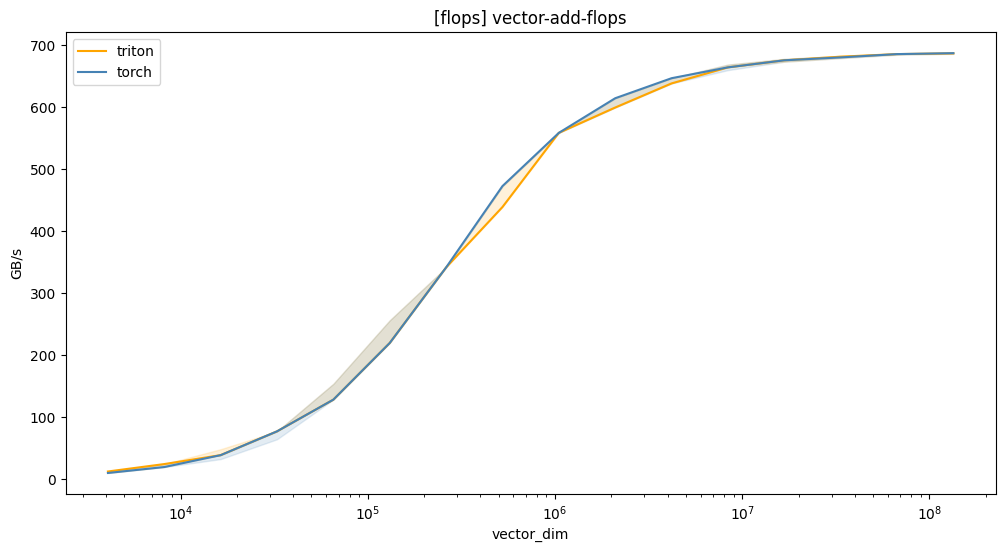

100%|██████████| 1/1 [00:04<00:00,  4.24s/it]

vector-add-flops:
     vector_dim      triton       torch
0        4096.0   12.000000    9.600000
1        8192.0   24.000000   19.200000
2       16384.0   38.400001   38.400001
3       32768.0   76.800002   76.800002
4       65536.0  127.999995  127.999995
5      131072.0  219.428568  219.428568
6      262144.0  341.333321  341.333321
7      524288.0  438.857137  472.615390
8     1048576.0  558.545450  558.545450
9     2097152.0  599.414644  614.400016
10    4194304.0  638.337688  646.736871
11    8388608.0  664.216187  664.216187
12   16777216.0  675.628857  675.628857
13   33554432.0  681.483502  680.304525
14   67108864.0  685.642544  685.642544
15  134217728.0  686.840182  687.140246



In [24]:
vector_add_flops_configs = [Benchmark(
        x_names=['vector_dim'],  # Argument names to use as an x-axis for the plot.
        x_vals=[
            2 ** i for i in range(12, 28, 1)
        ],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['triton', 'torch'],  # Label name for the lines.
        styles=[('orange', '-'), ('steelblue', '--')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='vector-add-flops',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ),]

@perf_report(vector_add_flops_configs)
def flops_benchmark(vector_dim, provider):
    x = torch.rand(vector_dim, device=device, dtype=torch.float32)
    y = torch.rand(vector_dim, device=device, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    
    if provider == 'torch':
        perf_dict = do_bench_flops(lambda: x + y, quantiles=quantiles)
    elif provider == 'triton':
        perf_dict = do_bench_flops(lambda: vector_add_triton(x, y), quantiles=quantiles)
    
    ## post process the perf_dict
    gbps = lambda ms: 12 * vector_dim / ms * 1e-6
    perf_dict['flops'] = list(map(gbps, perf_dict['flops']))
    
    return perf_dict

flops_benchmark.run(print_data=True, show_plots=True, save_path=False)

  0%|          | 0/1 [00:00<?, ?it/s]

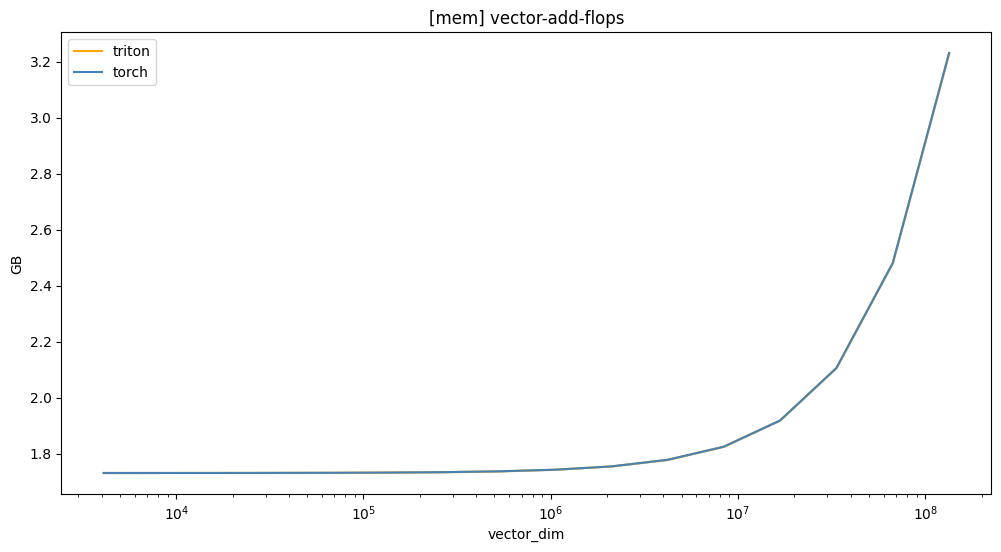

100%|██████████| 1/1 [00:04<00:00,  4.13s/it]

vector-add-flops:
     vector_dim    triton     torch
0        4096.0  1.730507  1.730507
1        8192.0  1.730553  1.730553
2       16384.0  1.730644  1.730644
3       32768.0  1.730827  1.730827
4       65536.0  1.731194  1.731194
5      131072.0  1.731926  1.731926
6      262144.0  1.733391  1.733391
7      524288.0  1.736320  1.736320
8     1048576.0  1.742180  1.742180
9     2097152.0  1.753899  1.753899
10    4194304.0  1.777336  1.777336
11    8388608.0  1.824211  1.824211
12   16777216.0  1.917961  1.917961
13   33554432.0  2.105461  2.105461
14   67108864.0  2.480461  2.480461
15  134217728.0  3.230461  3.230461



In [35]:
vector_add_mem_configs = [Benchmark(
        x_names=['vector_dim'],  # Argument names to use as an x-axis for the plot.
        x_vals=[
            2 ** i for i in range(12, 28, 1)
        ],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['triton', 'torch'],  # Label name for the lines.
        styles=[('orange', '-'), ('steelblue', '--')],  # Line styles.
        ylabel='GB',  # Label name for the y-axis.
        plot_name='vector-add-flops',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ),]

@perf_report(vector_add_mem_configs)
def mem_benchmark(vector_dim, provider):
    x = torch.rand(vector_dim, device=device, dtype=torch.float32)
    y = torch.rand(vector_dim, device=device, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    
    if provider == 'torch':
        perf_dict = do_bench_mem(lambda: x + y, quantiles=quantiles)
    elif provider == 'triton':
        perf_dict = do_bench_mem(lambda: vector_add_triton(x, y), quantiles=quantiles)
    
    ## post process the perf_dict
    gb = lambda m: m / 1024**3
    perf_dict['mem'] = list(map(gb, perf_dict['mem']))
    
    return perf_dict

mem_benchmark.run(print_data=True, show_plots=True, save_path=False)

#### step4-2. softmax flops/mem test

  0%|          | 0/3 [00:00<?, ?it/s]

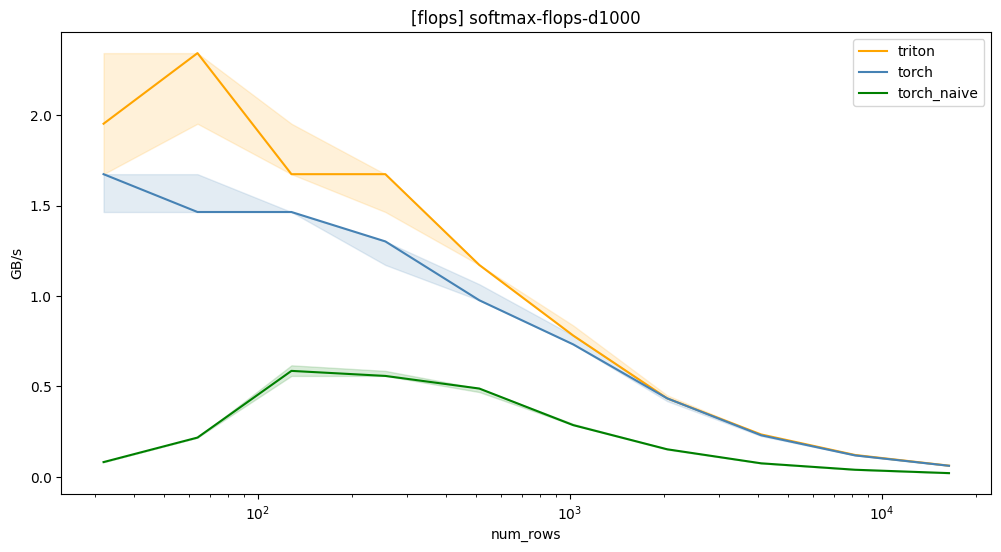

 33%|███▎      | 1/3 [00:05<00:11,  5.58s/it]

softmax-flops-d1000:
   num_rows    triton     torch  torch_naive
0      32.0  1.953125  1.674107     0.081380
1      64.0  2.343750  1.464844     0.217014
2     128.0  1.674107  1.464844     0.585938
3     256.0  1.674107  1.302083     0.558036
4     512.0  1.171875  0.976562     0.488281
5    1024.0  0.781250  0.732422     0.285823
6    2048.0  0.434028  0.434028     0.152192
7    4096.0  0.234375  0.229779     0.074642
8    8192.0  0.120812  0.118371     0.039062
9   16384.0  0.061678  0.061035     0.020416



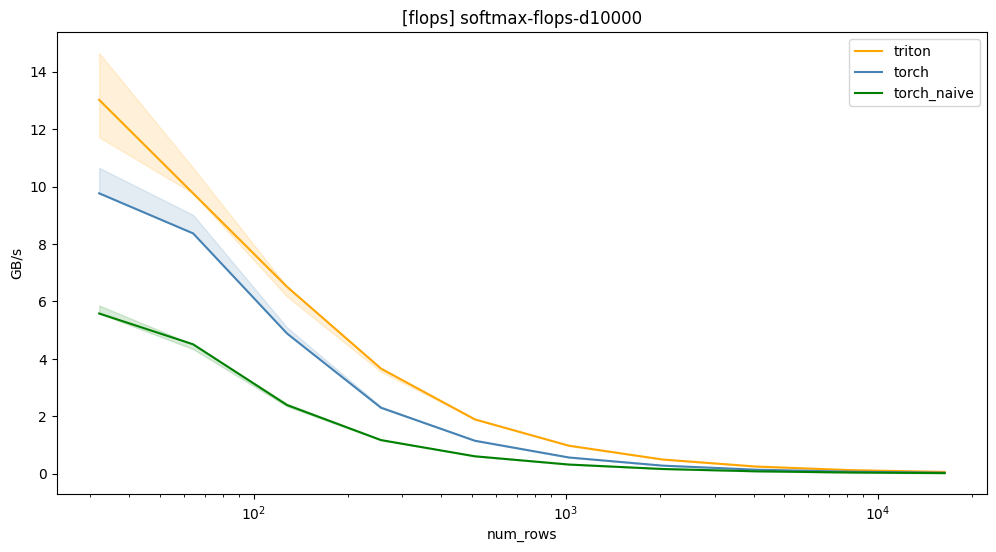

 67%|██████▋   | 2/3 [00:09<00:04,  4.62s/it]

softmax-flops-d10000:
   num_rows     triton     torch  torch_naive
0      32.0  13.020833  9.765625     5.580357
1      64.0   9.765625  8.370536     4.507212
2     128.0   6.510416  4.882812     2.391582
3     256.0   3.662109  2.297794     1.171875
4     512.0   1.890121  1.148897     0.607189
5    1024.0   0.976563  0.566123     0.320184
6    2048.0   0.494462  0.281701     0.164821
7    4096.0   0.248806  0.140009     0.083646
8    8192.0   0.124800  0.069796     0.042139
9   16384.0   0.062467  0.034856     0.021149



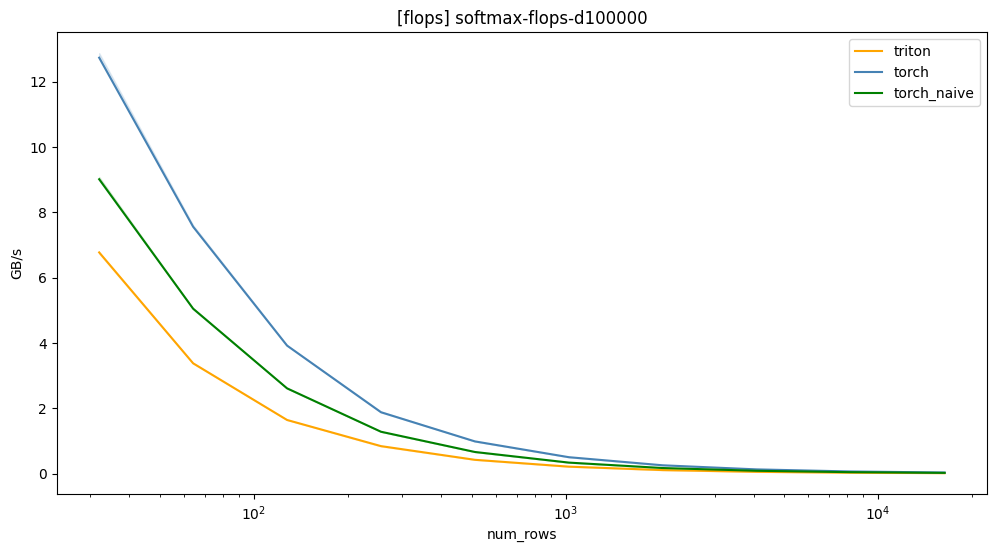

100%|██████████| 3/3 [00:15<00:00,  5.27s/it]

softmax-flops-d100000:
   num_rows    triton      torch  torch_naive
0      32.0  6.773844  12.737771     9.014423
1      64.0  3.377161   7.560484     5.051185
2     128.0  1.641281   3.919314     2.609967
3     256.0  0.840054   1.878005     1.280738
4     512.0  0.420932   0.984769     0.660583
5    1024.0  0.211377   0.501015     0.335492
6    2048.0  0.105875   0.252886     0.169053
7    4096.0  0.052935   0.127405     0.084845
8    8192.0  0.026461   0.064016     0.042415
9   16384.0  0.013230   0.032078     0.021232



In [45]:
vector_dims = [10**i for i in range(3, 6)]
softmax_flops_configs = [Benchmark(
        x_names=['num_rows'],  # Argument names to use as an x-axis for the plot.
        x_vals=[
            2 ** i for i in range(5, 15, 1)
        ],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch', 'torch_naive'],  # Possible values for `line_arg`.
        line_names=['triton', 'torch', 'torch_naive'],  # Label name for the lines.
        styles=[('orange', '-'), ('steelblue', '--'), ('green', '--')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name=f'softmax-flops-d{d}',  # Name for the plot. Used also as a file name for saving the plot.
        args={'vector_dim': d},  # Values for function arguments not in `x_names` and `y_name`.
    ) for d in vector_dims]

@perf_report(softmax_flops_configs)
def flops_benchmark(num_rows, vector_dim, provider):
    x = torch.rand(num_rows, vector_dim, device=device, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    
    if provider == 'torch_naive':
        perf_dict = do_bench_flops(lambda: softmax_torch_naive(x), quantiles=quantiles)
    elif provider == 'torch':
        perf_dict = do_bench_flops(lambda: F.softmax(x, dim=-1), quantiles=quantiles)
    elif provider == 'triton':
        perf_dict = do_bench_flops(lambda: softmax_triton(x), quantiles=quantiles)
    ## post process the perf_dict
    gbps = lambda ms: 12 * vector_dim / ms * 1e-6
    perf_dict['flops'] = list(map(gbps, perf_dict['flops']))
    
    return perf_dict

flops_benchmark.run(print_data=True, show_plots=True, save_path=False)


  0%|          | 0/3 [00:00<?, ?it/s]

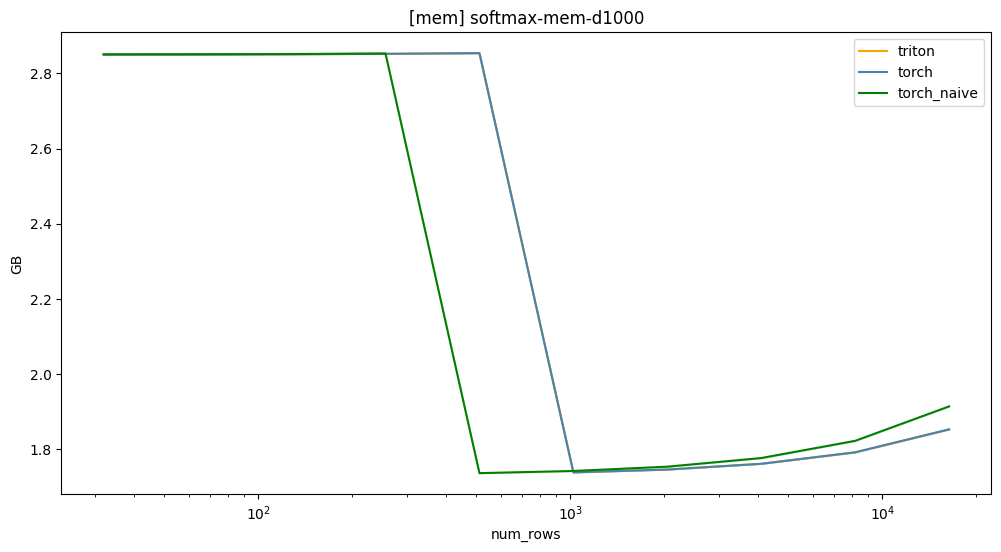

 33%|███▎      | 1/3 [00:03<00:07,  3.89s/it]

softmax-mem-d1000:
   num_rows    triton     torch  torch_naive
0      32.0  2.850079  2.850079     2.850198
1      64.0  2.850317  2.850317     2.850556
2     128.0  2.850794  2.850794     2.851271
3     256.0  2.851748  2.851748     2.852702
4     512.0  2.853655  2.853655     1.736822
5    1024.0  1.738728  1.738728     1.742546
6    2048.0  1.746357  1.746357     1.753994
7    4096.0  1.761616  1.761616     1.776890
8    8192.0  1.792133  1.792133     1.822681
9   16384.0  1.853168  1.853168     1.914265



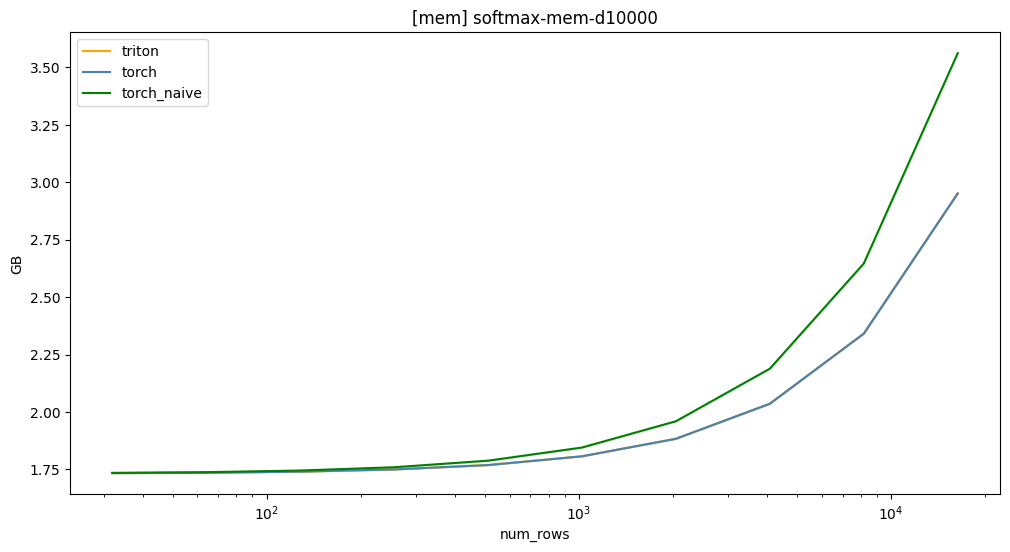

 67%|██████▋   | 2/3 [00:07<00:03,  3.92s/it]

softmax-mem-d10000:
   num_rows    triton     torch  torch_naive
0      32.0  1.734106  1.734106     1.735299
1      64.0  1.735867  1.735867     1.738251
2     128.0  1.740635  1.740635     1.745404
3     256.0  1.750172  1.750172     1.759709
4     512.0  1.769245  1.769245     1.788321
5    1024.0  1.807392  1.807392     1.845543
6    2048.0  1.883686  1.883686     1.959988
7    4096.0  2.036274  2.036274     2.188877
8    8192.0  2.341450  2.341450     2.646656
9   16384.0  2.951801  2.951801     3.562214



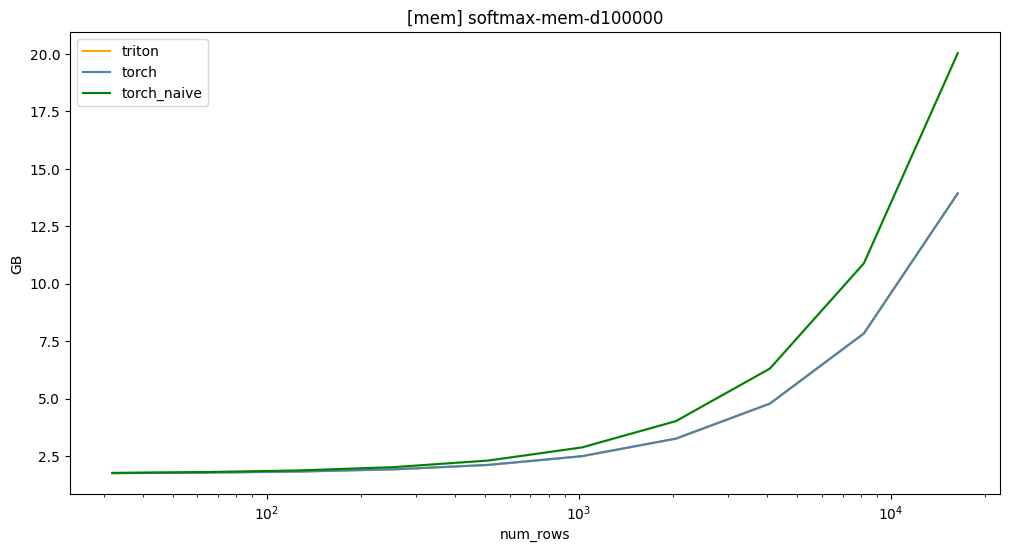

100%|██████████| 3/3 [00:14<00:00,  4.70s/it]

softmax-mem-d100000:
   num_rows     triton      torch  torch_naive
0      32.0   1.754940   1.754940     1.766861
1      64.0   1.778782   1.778782     1.802624
2     128.0   1.826466   1.826466     1.874150
3     256.0   1.921833   1.921833     2.017201
4     512.0   2.112568   2.112568     2.303305
5    1024.0   2.494038   2.494038     2.875511
6    2048.0   3.258442   3.258442     4.021389
7    4096.0   4.782856   4.782856     6.308750
8    8192.0   7.836567   7.836567    10.888355
9   16384.0  13.938129  13.938129    20.041706



In [47]:
vector_dims = [10**i for i in range(3, 6)]
softmax_mem_configs = [Benchmark(
        x_names=['num_rows'],  # Argument names to use as an x-axis for the plot.
        x_vals=[
            2 ** i for i in range(5, 15, 1)
        ],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch', 'torch_naive'],  # Possible values for `line_arg`.
        line_names=['triton', 'torch', 'torch_naive'],  # Label name for the lines.
        styles=[('orange', '-'), ('steelblue', '--'), ('green', '--')],  # Line styles.
        ylabel='GB',  # Label name for the y-axis.
        plot_name=f'softmax-mem-d{d}',  # Name for the plot. Used also as a file name for saving the plot.
        args={'vector_dim': d},  # Values for function arguments not in `x_names` and `y_name`.
    ) for d in vector_dims]


@perf_report(softmax_mem_configs)
def mem_benchmark(num_rows, vector_dim, provider):
    x = torch.rand(num_rows, vector_dim, device=device, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    
    if provider == 'torch_naive':
        perf_dict = do_bench_mem(lambda: softmax_torch_naive(x), quantiles=quantiles)
    elif provider == 'torch':
        perf_dict = do_bench_mem(lambda: F.softmax(x, dim=-1), quantiles=quantiles)
    elif provider == 'triton':
        perf_dict = do_bench_mem(lambda: softmax_triton(x), quantiles=quantiles)
        
    ## post process the perf_dict
    gb = lambda m: m / 1024**3
    perf_dict['mem'] = list(map(gb, perf_dict['mem']))
    
    return perf_dict

mem_benchmark.run(print_data=True, show_plots=True, save_path=False)

#### step4-3. mat-mul flops/mem test

  0%|          | 0/4 [00:00<?, ?it/s]

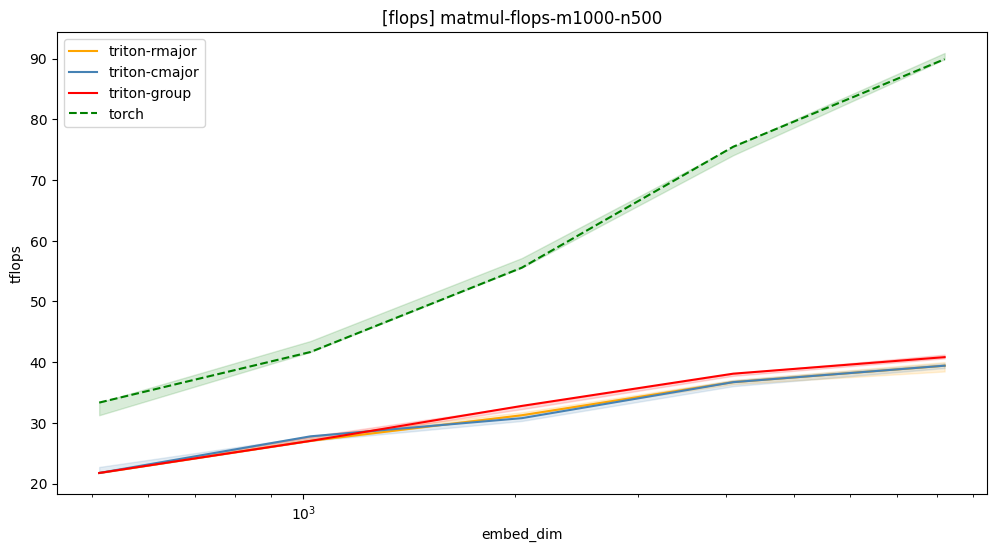

 25%|██▌       | 1/4 [02:27<07:21, 147.11s/it]

matmul-flops-m1000-n500:
   embed_dim  triton-rmajor  triton-cmajor  triton-group      torch
0      512.0      21.739130      21.739130     21.739130  33.333334
1     1024.0      27.027026      27.777777     27.027026  41.666665
2     2048.0      31.250000      30.769231     32.786886  55.555554
3     4096.0      36.697248      36.697248     38.095238  75.471698
4     8192.0      39.408866      39.408866     40.816328  89.887639



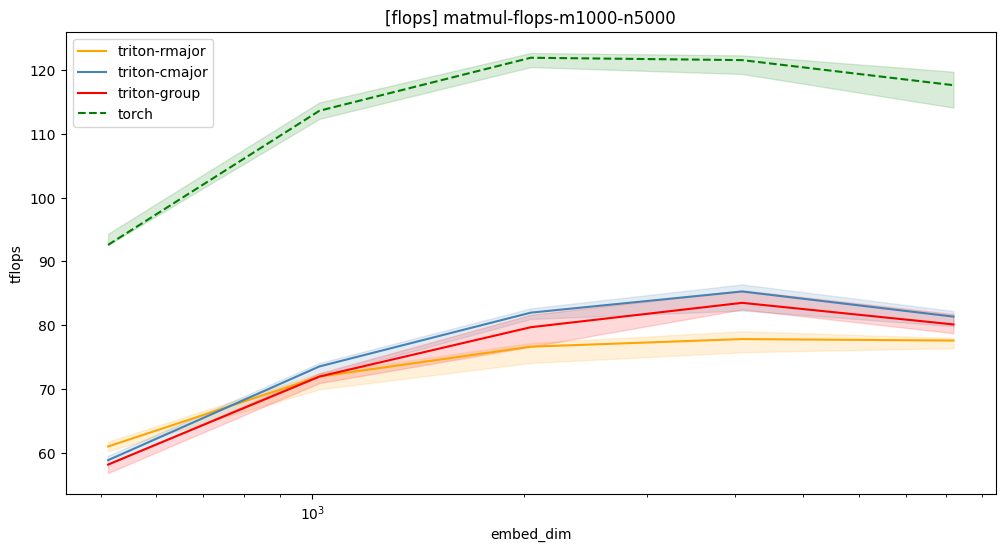

 50%|█████     | 2/4 [04:51<04:51, 145.56s/it]

matmul-flops-m1000-n5000:
   embed_dim  triton-rmajor  triton-cmajor  triton-group       torch
0      512.0      60.975611      58.823530     58.139535   92.592592
1     1024.0      71.942448      73.529410     71.942448  113.636363
2     2048.0      76.628350      81.967215     79.681278  121.951222
3     4096.0      77.821010      85.287848     83.507305  121.580546
4     8192.0      77.594565      81.342142     80.120177  117.647059



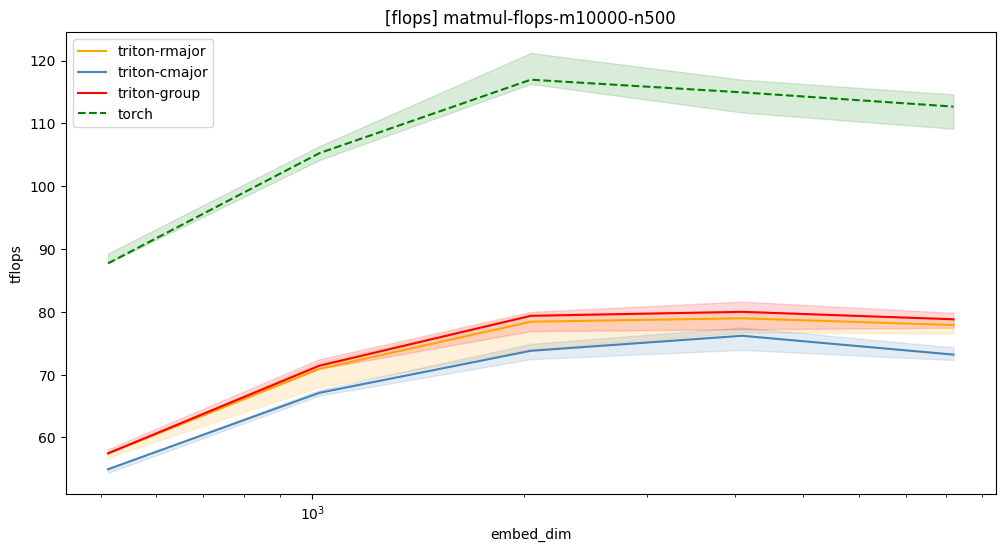

 75%|███████▌  | 3/4 [07:22<02:27, 147.85s/it]

matmul-flops-m10000-n500:
   embed_dim  triton-rmajor  triton-cmajor  triton-group       torch
0      512.0      57.471264      54.945054     57.471264   87.719297
1     1024.0      70.921987      67.114094     71.428570  105.263155
2     2048.0      78.431375      73.800739     79.365080  116.959060
3     4096.0      78.973344      76.190479     79.999996  114.942528
4     8192.0      77.896785      73.193051     78.817730  112.676057



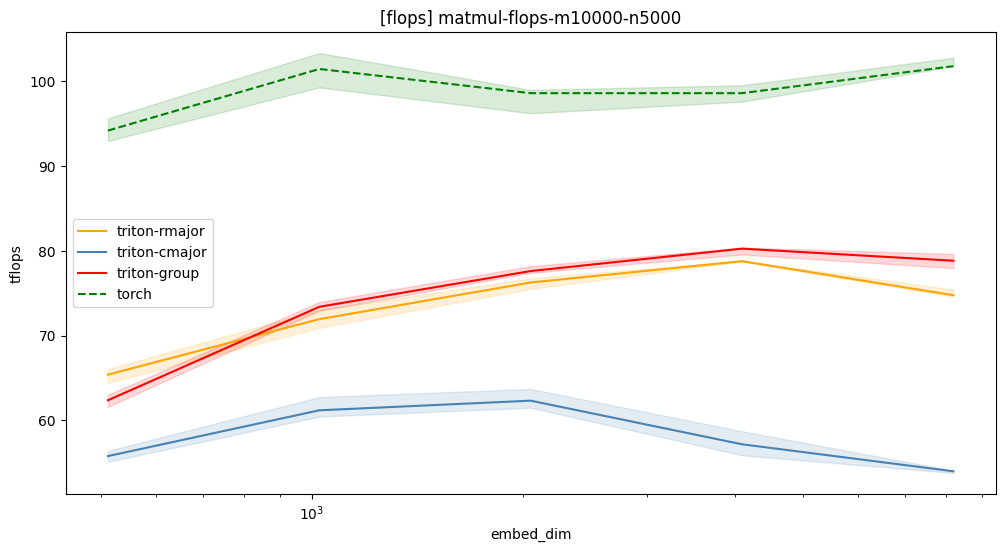

100%|██████████| 4/4 [10:08<00:00, 152.08s/it]

matmul-flops-m10000-n5000:
   embed_dim  triton-rmajor  triton-cmajor  triton-group       torch
0      512.0      65.402224      55.803571     62.383032   94.161954
1     1024.0      71.942447      61.199511     73.394495  101.419872
2     2048.0      76.263106      62.334427     77.609622   98.570732
3     4096.0      78.771169      57.195971     80.248773   98.570720
4     8192.0      74.766352      54.013909     78.825498  101.755281



In [112]:
ms, ns, ks = [10**i for i in range(3, 5)], [10**i // 2 for i in range(3, 5)], [2**i for i in range(9, 14)] # 0.5k ~ 8k

matmul_flops_configs = [Benchmark(
        x_names=['embed_dim'],  # Argument names to use as an x-axis for the plot.
        x_vals=ks,  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton-rmajor', 'triton-cmajor', 'triton-group', 'torch'],  # Possible values for `line_arg`.
        line_names=['triton-rmajor', 'triton-cmajor', 'triton-group', 'torch'],  # Label name for the lines.
        styles=[('orange', '-'), ('steelblue', '-'), ('red', '-'), ('green', '--')],  # Line styles.
        ylabel='tflops',  # Label name for the y-axis.
        plot_name=f'matmul-flops-m{m}-n{n}',  # Name for the plot. Used also as a file name for saving the plot.
        args={'m': m, 'n': n},  # Values for function arguments not in `x_names` and `y_name`.
    ) for m in ms for n in ns]

@perf_report(matmul_flops_configs)
def flops_benchmark(m, n, embed_dim, provider):
    x = torch.randn(m, embed_dim, device=device, dtype=torch.float16)
    y = torch.randn(embed_dim, n, device=device, dtype=torch.float16)
    quantiles = [0.5, 0.2, 0.8]
    
    if provider == 'torch':
        perf_dict = do_bench_flops(lambda: torch.matmul(x, y), quantiles=quantiles)
    else:
        major = 'row' if 'rmajor' in provider else ('col' if 'cmajor' in provider else 'group')
        perf_dict = do_bench_flops(lambda: matmul_triton(x, y, major=major), quantiles=quantiles)
        
    ## post process the perf_dict
    gbps = lambda ms: 2 * m * n * embed_dim  / ms * 1e-9
    perf_dict['flops'] = list(map(gbps, perf_dict['flops']))
    
    return perf_dict

flops_benchmark.run(print_data=True, show_plots=True, save_path=False)


  0%|          | 0/4 [00:00<?, ?it/s]

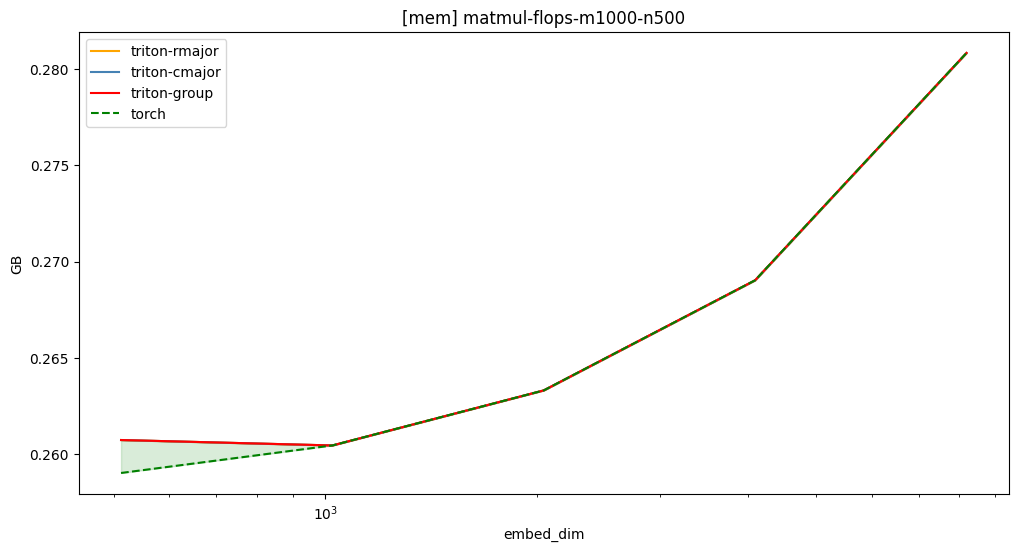

 25%|██▌       | 1/4 [02:08<06:25, 128.63s/it]

matmul-flops-m1000-n500:
   embed_dim  triton-rmajor  triton-cmajor  triton-group     torch
0      512.0       0.260725       0.260725      0.260725  0.259013
1     1024.0       0.260443       0.260443      0.260443  0.260443
2     2048.0       0.263304       0.263304      0.263304  0.263304
3     4096.0       0.269026       0.269026      0.269026  0.269026
4     8192.0       0.280837       0.280837      0.280837  0.280837



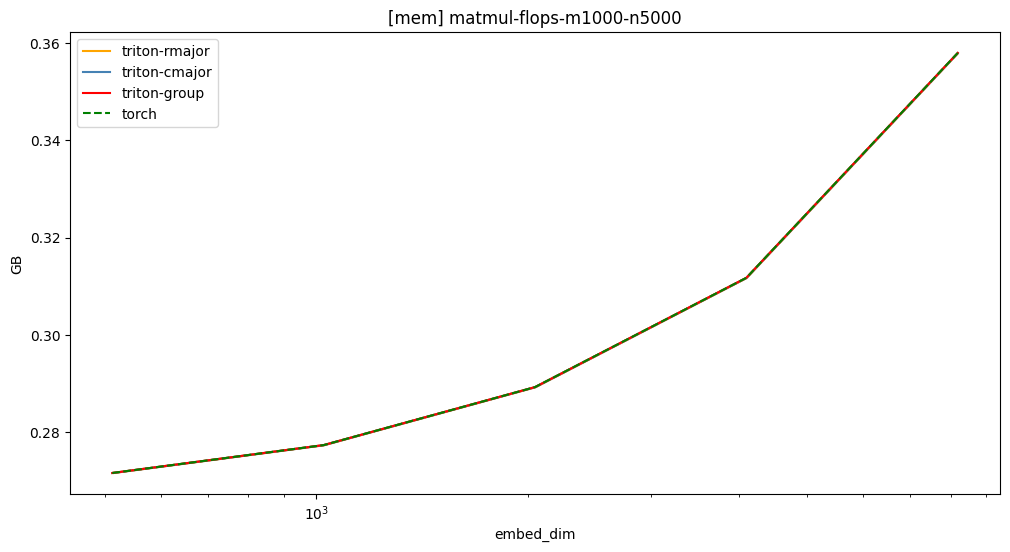

 50%|█████     | 2/4 [04:30<04:32, 136.30s/it]

matmul-flops-m1000-n5000:
   embed_dim  triton-rmajor  triton-cmajor  triton-group     torch
0      512.0       0.271686       0.271686      0.271686  0.271686
1     1024.0       0.277408       0.277408      0.277408  0.277408
2     2048.0       0.289310       0.289310      0.289310  0.289310
3     4096.0       0.311740       0.311740      0.311740  0.311740
4     8192.0       0.357883       0.357883      0.357883  0.357883



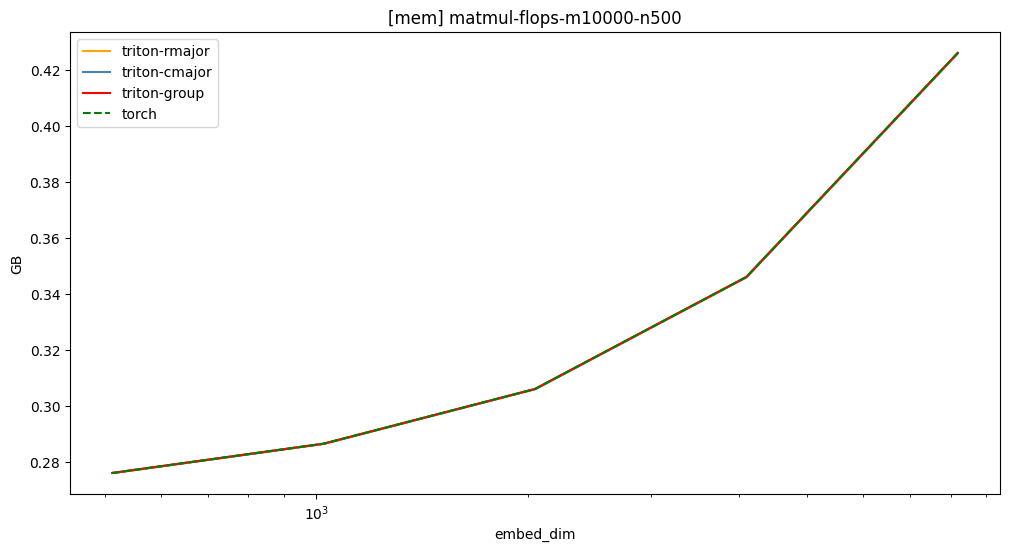

 75%|███████▌  | 3/4 [06:58<02:21, 141.72s/it]

matmul-flops-m10000-n500:
   embed_dim  triton-rmajor  triton-cmajor  triton-group     torch
0      512.0       0.275978       0.275978      0.275978  0.275978
1     1024.0       0.286449       0.286449      0.286449  0.286449
2     2048.0       0.306018       0.306018      0.306018  0.306018
3     4096.0       0.346073       0.346073      0.346073  0.346073
4     8192.0       0.426181       0.426181      0.426181  0.426181



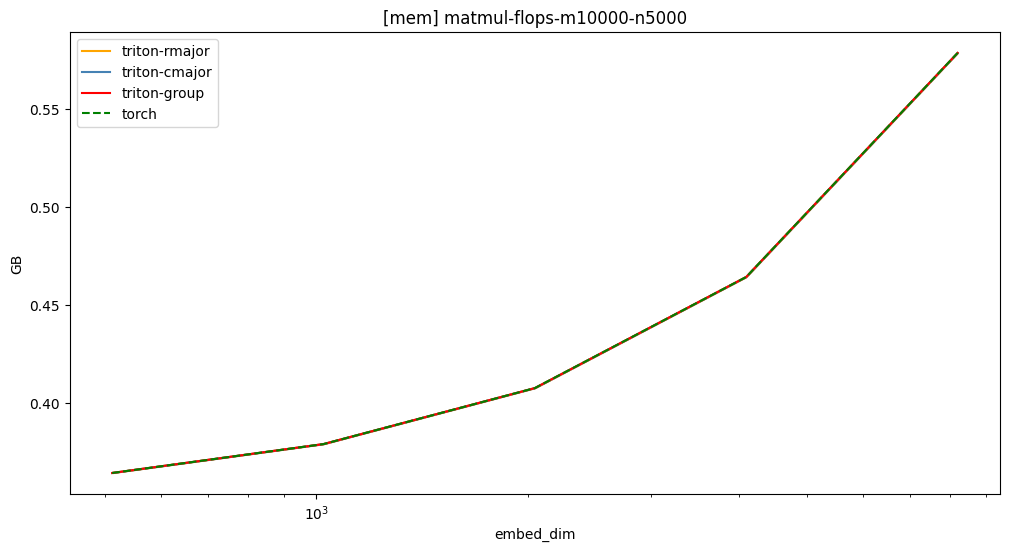

100%|██████████| 4/4 [09:58<00:00, 149.74s/it]

matmul-flops-m10000-n5000:
   embed_dim  triton-rmajor  triton-cmajor  triton-group     torch
0      512.0       0.364088       0.364088      0.364088  0.364088
1     1024.0       0.378851       0.378851      0.378851  0.378851
2     2048.0       0.407461       0.407461      0.407461  0.407461
3     4096.0       0.464224       0.464224      0.464224  0.464224
4     8192.0       0.578665       0.578665      0.578665  0.578665



In [44]:
ms, ns, ks = [10**i for i in range(3, 5)], [10**i // 2 for i in range(3, 5)], [2**i for i in range(9, 14)] # 0.5k ~ 8k

matmul_mem_configs = [Benchmark(
        x_names=['embed_dim'],  # Argument names to use as an x-axis for the plot.
        x_vals=ks,  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton-rmajor', 'triton-cmajor', 'triton-group', 'torch'],  # Possible values for `line_arg`.
        line_names=['triton-rmajor', 'triton-cmajor', 'triton-group', 'torch'],  # Label name for the lines.
        styles=[('orange', '-'), ('steelblue', '-'), ('red', '-'), ('green', '--')],  # Line styles.
        ylabel='GB',  # Label name for the y-axis.
        plot_name=f'matmul-flops-m{m}-n{n}',  # Name for the plot. Used also as a file name for saving the plot.
        args={'m': m, 'n': n},  # Values for function arguments not in `x_names` and `y_name`.
    ) for m in ms for n in ns]

@perf_report(matmul_mem_configs)
def mem_benchmark(m, n, embed_dim, provider):
    x = torch.randn(m, embed_dim, device=device, dtype=torch.float16)
    y = torch.randn(embed_dim, n, device=device, dtype=torch.float16)
    quantiles = [0.5, 0.2, 0.8]
    
    if provider == 'torch':
        perf_dict = do_bench_mem(lambda: torch.matmul(x, y), quantiles=quantiles)
    else:
        major = 'row' if 'rmajor' in provider else ('col' if 'cmajor' in provider else 'group')
        perf_dict = do_bench_mem(lambda: matmul_triton(x, y, major=major), quantiles=quantiles)
        
    ## post process the perf_dict
    gb = lambda m: m / 1024**3
    perf_dict['mem'] = list(map(gb, perf_dict['mem']))
    
    return perf_dict

mem_benchmark.run(print_data=True, show_plots=True, save_path=False)


#### step4-4. dropout flops/mem test

  0%|          | 0/3 [00:00<?, ?it/s]

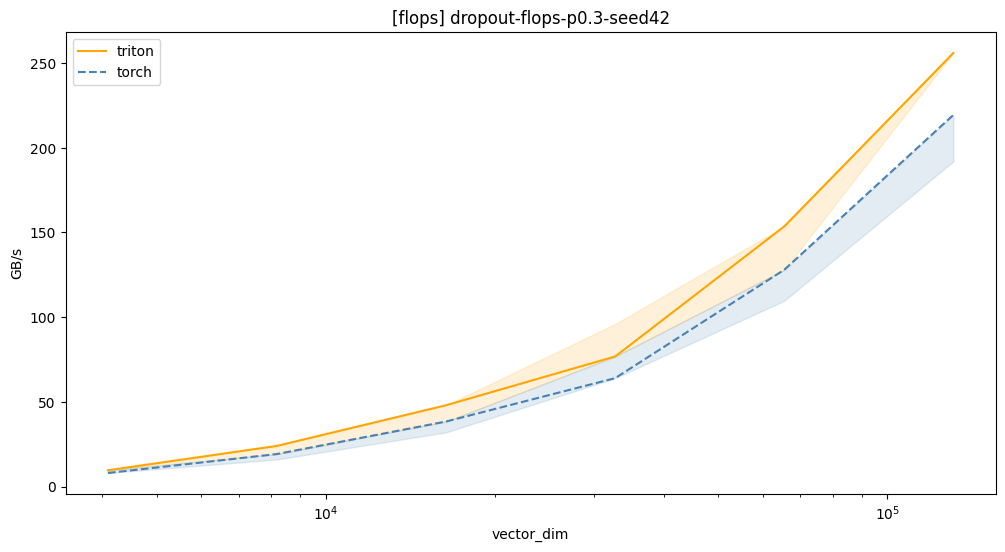

 33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

dropout-flops-p0.3-seed42:
   vector_dim      triton       torch
0      4096.0    9.600000    8.000000
1      8192.0   24.000000   19.200000
2     16384.0   48.000000   38.400001
3     32768.0   76.800002   63.999998
4     65536.0  153.600004  127.999995
5    131072.0  255.999991  219.428568



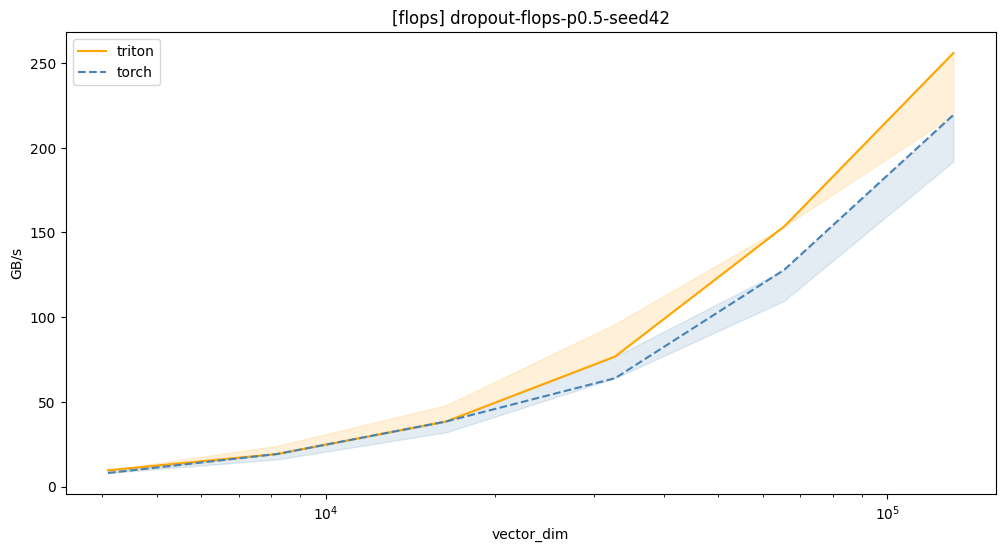

 67%|██████▋   | 2/3 [00:03<00:01,  1.63s/it]

dropout-flops-p0.5-seed42:
   vector_dim      triton       torch
0      4096.0    9.600000    8.000000
1      8192.0   19.200000   19.200000
2     16384.0   38.400001   38.400001
3     32768.0   76.800002   63.999998
4     65536.0  153.600004  127.999995
5    131072.0  255.999991  219.428568



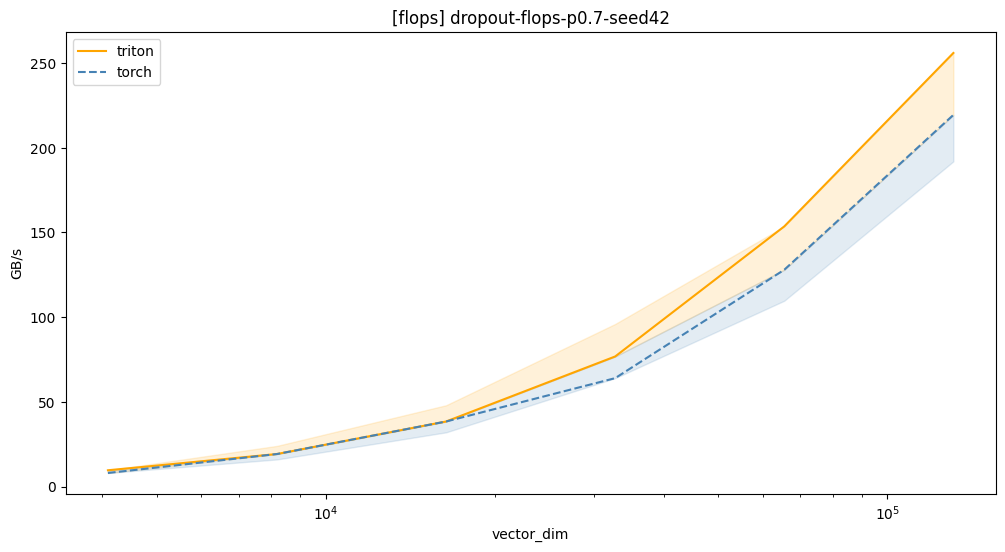

100%|██████████| 3/3 [00:05<00:00,  1.73s/it]

dropout-flops-p0.7-seed42:
   vector_dim      triton       torch
0      4096.0    9.600000    8.000000
1      8192.0   19.200000   19.200000
2     16384.0   38.400001   38.400001
3     32768.0   76.800002   63.999998
4     65536.0  153.600004  127.999995
5    131072.0  255.999991  219.428568



In [128]:
ps, seeds = [i / 10 for i in range(3, 8, 2)], [42]
dropout_flops_configs = [Benchmark(
        x_names=['vector_dim'],  # Argument names to use as an x-axis for the plot.
        x_vals=[
            2 ** i for i in range(12, 18, 1)
        ],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['triton', 'torch'],  # Label name for the lines.
        styles=[('orange', '-'), ('steelblue', '--')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name=f'dropout-flops-p{p}-seed{seed}',  # Name for the plot. Used also as a file name for saving the plot.
        args={'p': p, 'seed': seed},  # Values for function arguments not in `x_names` and `y_name`.
    ) for p in ps for seed in seeds]

@perf_report(dropout_flops_configs)
def flops_benchmark(vector_dim, p, seed, provider):
    x = torch.rand(vector_dim, device=device, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    
    if provider == 'torch':
        torch.manual_seed(seed)
        perf_dict = do_bench_flops(lambda: F.dropout(x, p), quantiles=quantiles)
    elif provider == 'triton':
        perf_dict = do_bench_flops(lambda: dropout_triton(x, p, seed), quantiles=quantiles)
    
    ## post process the perf_dict
    gbps = lambda ms: 12 * vector_dim / ms * 1e-6
    perf_dict['flops'] = list(map(gbps, perf_dict['flops']))
    
    return perf_dict

flops_benchmark.run(print_data=True, show_plots=True, save_path=False)

  0%|          | 0/3 [00:00<?, ?it/s]

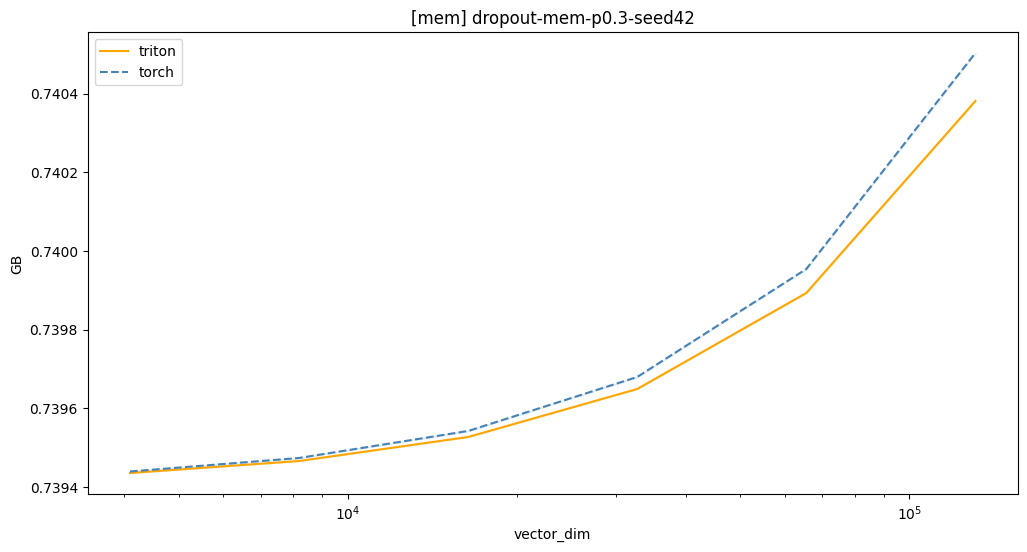

 33%|███▎      | 1/3 [00:01<00:03,  1.63s/it]

dropout-mem-p0.3-seed42:
   vector_dim    triton     torch
0      4096.0  0.739435  0.739439
1      8192.0  0.739466  0.739473
2     16384.0  0.739527  0.739542
3     32768.0  0.739649  0.739679
4     65536.0  0.739893  0.739954
5    131072.0  0.740381  0.740503



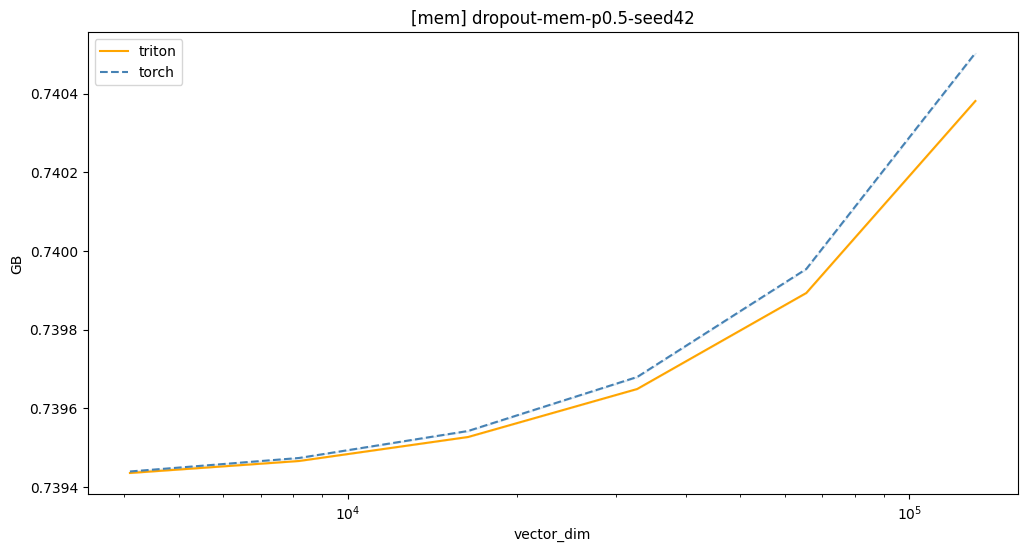

 67%|██████▋   | 2/3 [00:03<00:01,  1.63s/it]

dropout-mem-p0.5-seed42:
   vector_dim    triton     torch
0      4096.0  0.739435  0.739439
1      8192.0  0.739466  0.739473
2     16384.0  0.739527  0.739542
3     32768.0  0.739649  0.739679
4     65536.0  0.739893  0.739954
5    131072.0  0.740381  0.740503



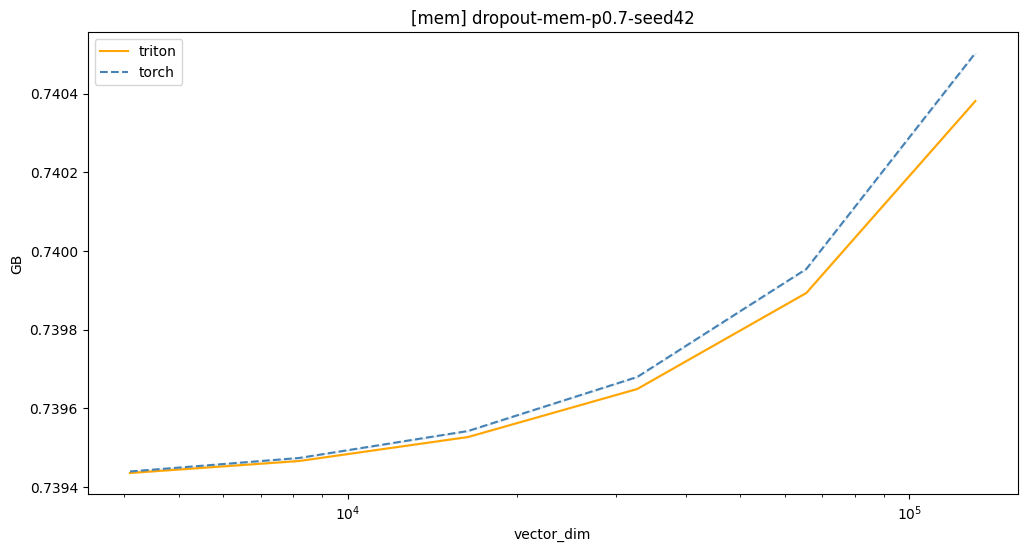

100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

dropout-mem-p0.7-seed42:
   vector_dim    triton     torch
0      4096.0  0.739435  0.739439
1      8192.0  0.739466  0.739473
2     16384.0  0.739527  0.739542
3     32768.0  0.739649  0.739679
4     65536.0  0.739893  0.739954
5    131072.0  0.740381  0.740503



In [130]:
ps, seeds = [i / 10 for i in range(3, 8, 2)], [42]
dropout_flops_configs = [Benchmark(
        x_names=['vector_dim'],  # Argument names to use as an x-axis for the plot.
        x_vals=[
            2 ** i for i in range(12, 18, 1)
        ],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['triton', 'torch'],  # Label name for the lines.
        styles=[('orange', '-'), ('steelblue', '--')],  # Line styles.
        ylabel='GB',  # Label name for the y-axis.
        plot_name=f'dropout-mem-p{p}-seed{seed}',  # Name for the plot. Used also as a file name for saving the plot.
        args={'p': p, 'seed': seed},  # Values for function arguments not in `x_names` and `y_name`.
    ) for p in ps for seed in seeds]

@perf_report(dropout_flops_configs)
def mem_benchmark(vector_dim, p, seed, provider):
    x = torch.rand(vector_dim, device=device, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    
    if provider == 'torch':
        torch.manual_seed(seed)
        perf_dict = do_bench_mem(lambda: F.dropout(x, p), quantiles=quantiles)
    elif provider == 'triton':
        perf_dict = do_bench_mem(lambda: dropout_triton(x, p, seed), quantiles=quantiles)
    
    ## post process the perf_dict
    gb = lambda m: m / 1024**3
    perf_dict['mem'] = list(map(gb, perf_dict['mem']))
    
    return perf_dict

mem_benchmark.run(print_data=True, show_plots=True, save_path=False)

#### step4-5. layer-norm flops/mem test

  0%|          | 0/6 [00:00<?, ?it/s]

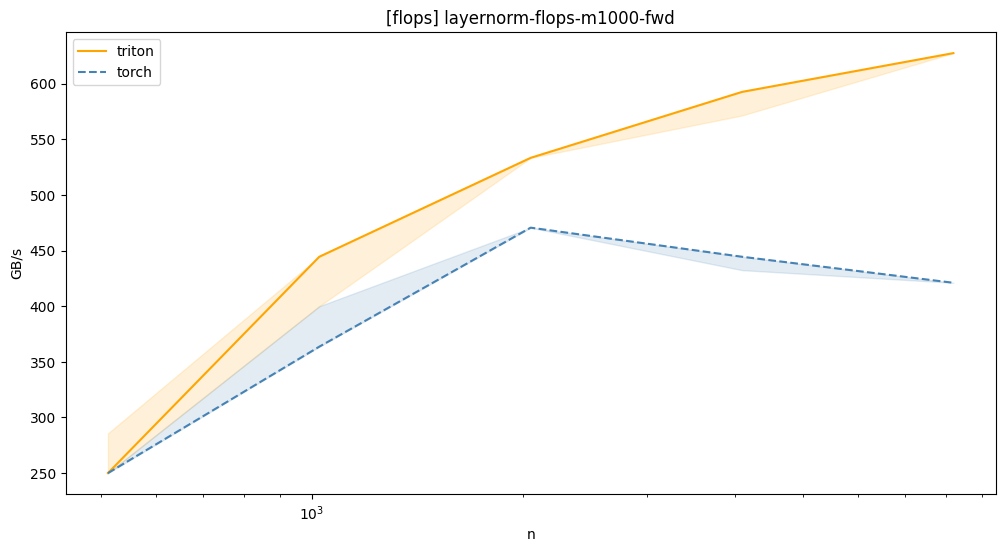

 17%|█▋        | 1/6 [00:07<00:36,  7.24s/it]

layernorm-flops-m1000-fwd:
        n      triton       torch
0   512.0  250.000001  250.000001
1  1024.0  444.444429  363.636361
2  2048.0  533.333347  470.588227
3  4096.0  592.592592  444.444429
4  8192.0  627.450992  421.052650



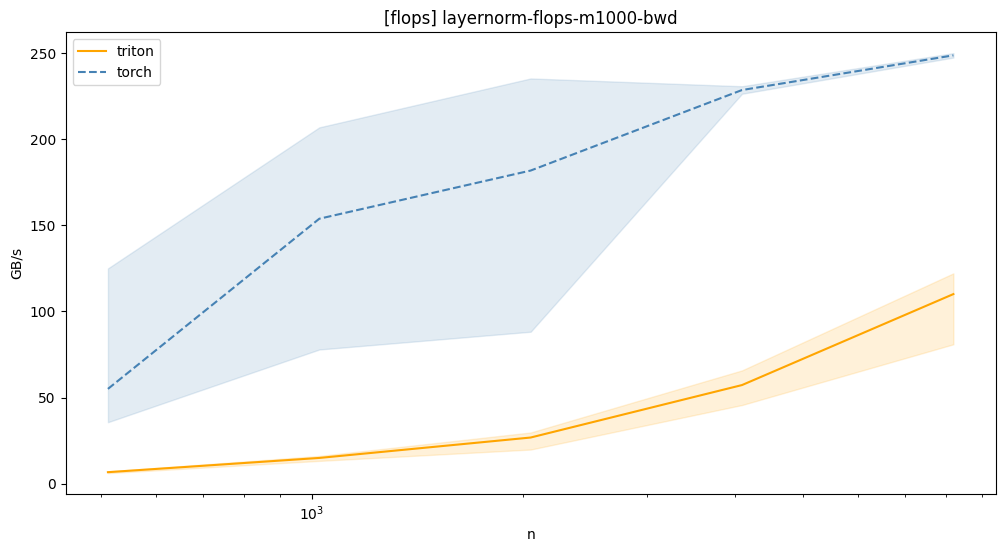

 33%|███▎      | 2/6 [00:18<00:38,  9.61s/it]

layernorm-flops-m1000-bwd:
        n      triton       torch
0   512.0    6.696428   55.045871
1  1024.0   14.962594  153.846159
2  2048.0   26.815642  181.818180
3  4096.0   57.279238  228.571430
4  8192.0  110.091743  248.704663



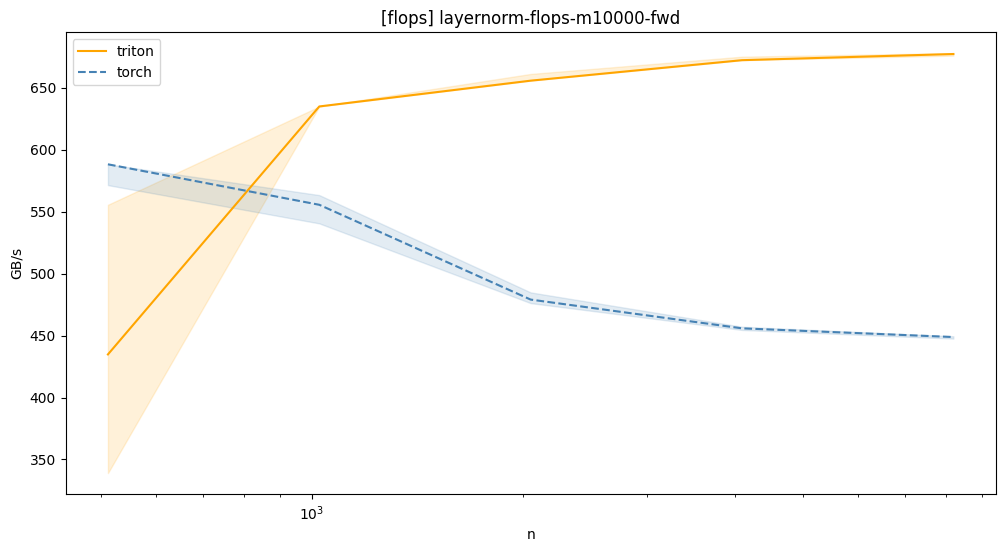

 50%|█████     | 3/6 [00:24<00:23,  7.92s/it]

layernorm-flops-m10000-fwd:
        n      triton       torch
0   512.0  434.782599  588.235284
1  1024.0  634.920640  555.555536
2  2048.0  655.737718  479.041900
3  4096.0  672.268927  455.840462
4  8192.0  677.248693  448.807844



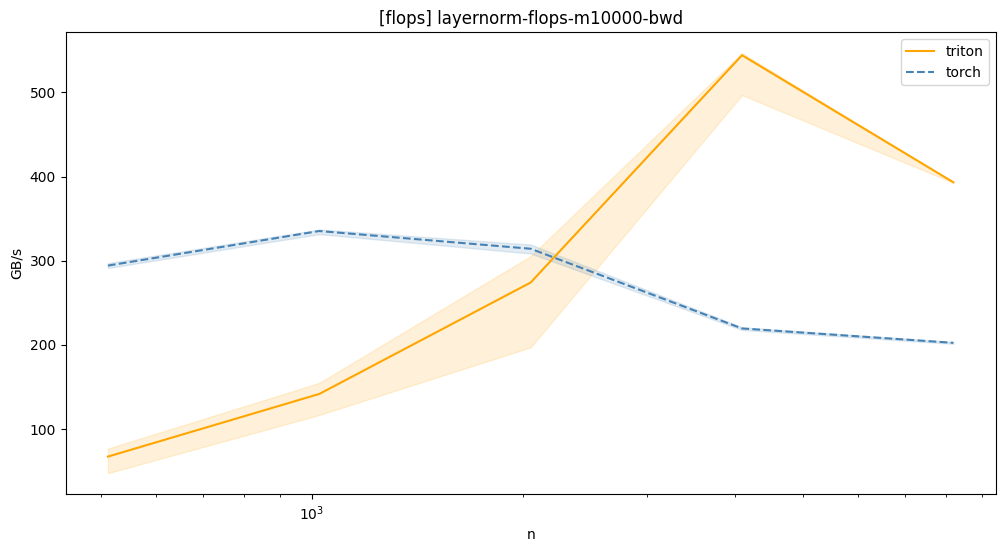

 67%|██████▋   | 4/6 [00:29<00:13,  6.98s/it]

layernorm-flops-m10000-bwd:
        n      triton       torch
0   512.0   67.039106  294.117652
1  1024.0  141.509435  335.195540
2  2048.0  273.972610  314.136127
3  4096.0  544.217673  219.378438
4  8192.0  393.120398  202.275608



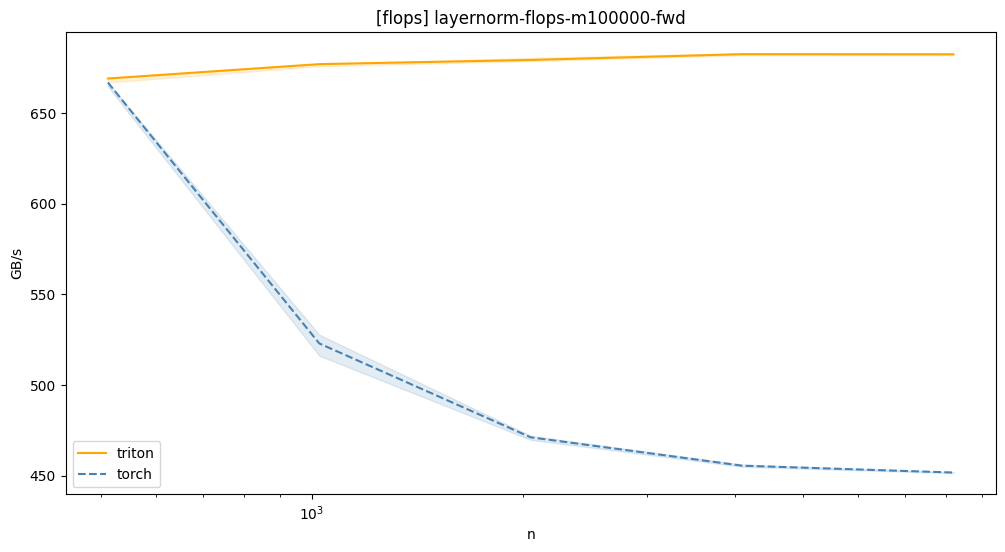

 83%|████████▎ | 5/6 [00:36<00:06,  6.74s/it]

layernorm-flops-m100000-fwd:
        n      triton       torch
0   512.0  668.896306  666.666635
1  1024.0  676.818930  522.875814
2  2048.0  679.117144  471.142519
3  4096.0  682.302793  455.516033
4  8192.0  682.230043  451.722196



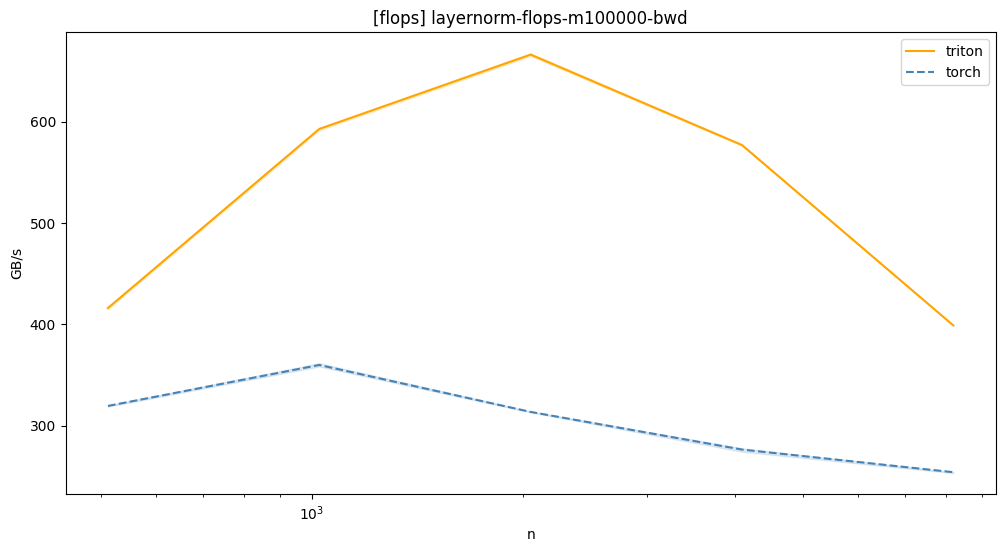

100%|██████████| 6/6 [00:41<00:00,  6.85s/it]

layernorm-flops-m100000-bwd:
        n      triton       torch
0   512.0  416.088755  319.488821
1  1024.0  592.885362  359.928014
2  2048.0  666.296511  313.561533
3  4096.0  576.992442  276.418064
4  8192.0  398.936159  254.075806



In [71]:
ms, ns = [10**i for i in range(3, 6)], [2**i for i in range(9, 14)]
layernorm_flops_configs = [Benchmark(
        x_names=['n'],  # Argument names to use as an x-axis for the plot.
        x_vals=ns, # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch',],  # Possible values for `line_arg`.
        line_names=['triton', 'torch',],  # Label name for the lines.
        styles=[('orange', '-'), ('steelblue', '--'),],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name=f'layernorm-flops-m{m}-{wd}',  # Name for the plot. Used also as a file name for saving the plot.
        args={'m': m, 'wd': wd},  # Values for function arguments not in `x_names` and `y_name`.
    ) for m in ms for wd in ['fwd', 'bwd']]

@perf_report(layernorm_flops_configs)
def flops_benchmark(m, n, wd, provider, eps=1e-5,):
    x = -2.3 + 0.5 * torch.randn(m, n, dtype=torch.float16, device=device, requires_grad=False) # x ~ N(-2.3, 0.5)
    do = .1 * torch.randn_like(x); x.requires_grad_(True)
    weight = torch.rand(n, dtype=torch.float16, device=device, requires_grad=True)
    bias = torch.rand(n, dtype=torch.float16, device=device, requires_grad=True)
    quantiles = [0.5, 0.2, 0.8]
    
    if provider == 'torch': 
        fwd_func = lambda: F.layer_norm(x, (n,), weight, bias, eps)
    elif provider == 'triton':
        fwd_func = lambda: layernorm_triton(x, (n,), weight, bias, eps)
    
    if wd == 'fwd':
        gbps = lambda ms: 2 * x.numel() * x.element_size() / ms * 1e-6
        perf_dict = do_bench_flops(fwd_func, quantiles=quantiles, rep=500) 
    elif wd == 'bwd':
        gbps = lambda ms: 3 * x.numel() * x.element_size() / ms * 1e-6
        o = fwd_func()
        perf_dict = do_bench_flops(lambda: o.backward(do, retain_graph=True), grad_to_none=[x], quantiles=quantiles, rep=500) 
    
    ## post process the perf_dict
    perf_dict['flops'] = list(map(gbps, perf_dict['flops']))
    
    return perf_dict

flops_benchmark.run(print_data=True, show_plots=True, save_path=False)

  0%|          | 0/6 [00:00<?, ?it/s]

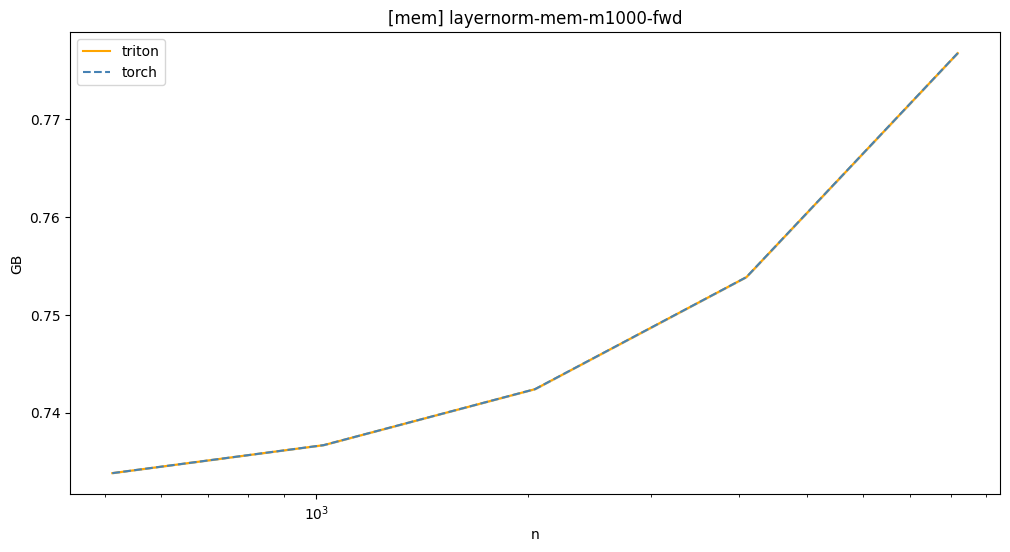

 17%|█▋        | 1/6 [00:05<00:27,  5.53s/it]

layernorm-mem-m1000-fwd:
        n    triton     torch
0   512.0  0.733824  0.733824
1  1024.0  0.736687  0.736687
2  2048.0  0.742413  0.742413
3  4096.0  0.753864  0.753864
4  8192.0  0.776768  0.776768



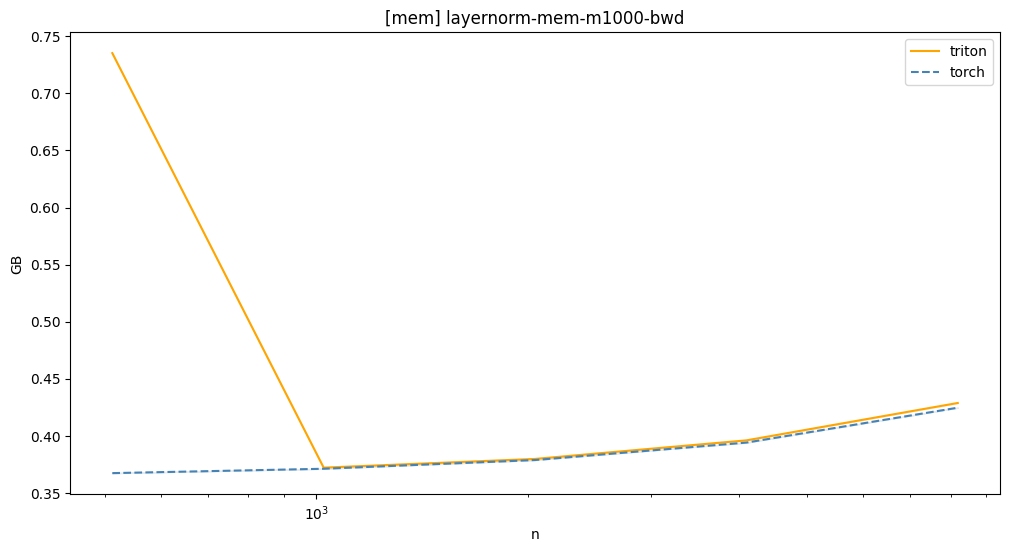

 33%|███▎      | 2/6 [00:12<00:25,  6.28s/it]

layernorm-mem-m1000-bwd:
        n    triton     torch
0   512.0  0.735271  0.367342
1  1024.0  0.372141  0.371162
2  2048.0  0.379781  0.378803
3  4096.0  0.396039  0.394085
4  8192.0  0.428784  0.424648



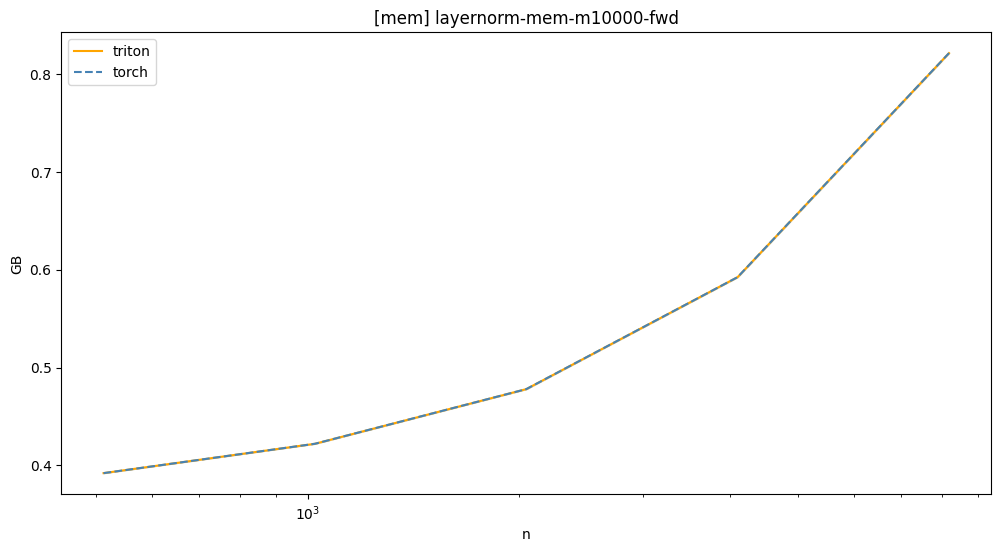

 50%|█████     | 3/6 [00:17<00:17,  5.96s/it]

layernorm-mem-m10000-fwd:
        n    triton     torch
0   512.0  0.392201  0.392201
1  1024.0  0.422187  0.422187
2  2048.0  0.478038  0.478038
3  4096.0  0.592486  0.592486
4  8192.0  0.821383  0.821383



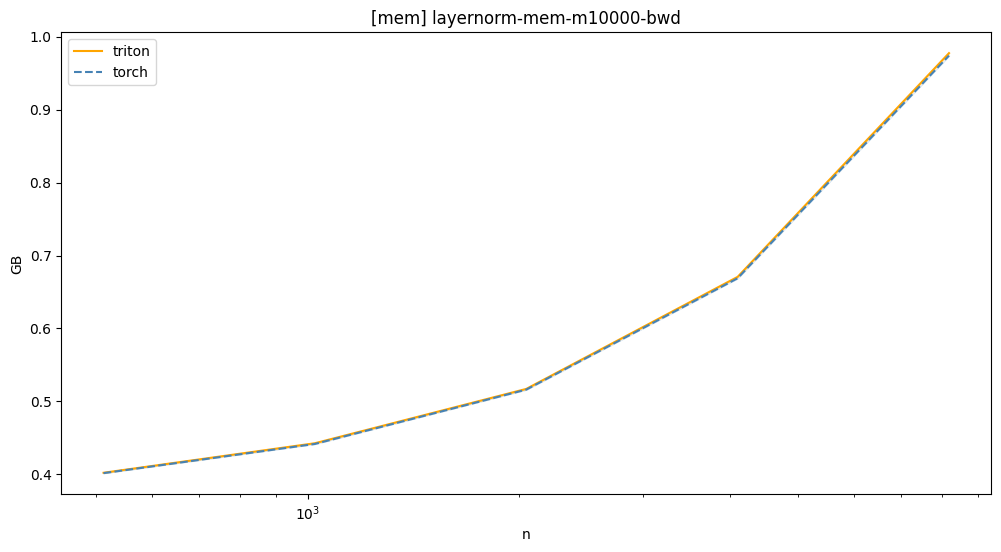

 67%|██████▋   | 4/6 [00:23<00:11,  5.69s/it]

layernorm-mem-m10000-bwd:
        n    triton     torch
0   512.0  0.402232  0.401742
1  1024.0  0.442704  0.441726
2  2048.0  0.517178  0.516200
3  4096.0  0.670765  0.668811
4  8192.0  0.977451  0.974032



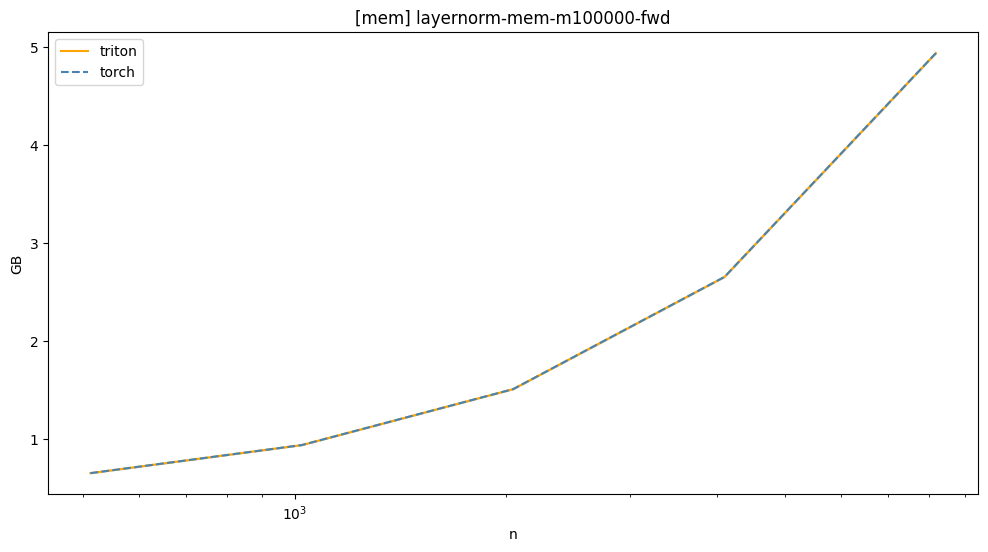

 83%|████████▎ | 5/6 [00:28<00:05,  5.72s/it]

layernorm-mem-m100000-fwd:
        n    triton     torch
0   512.0  0.650364  0.650364
1  1024.0  0.937140  0.937140
2  2048.0  1.508677  1.508677
3  4096.0  2.655291  2.655291
4  8192.0  4.941927  4.941927



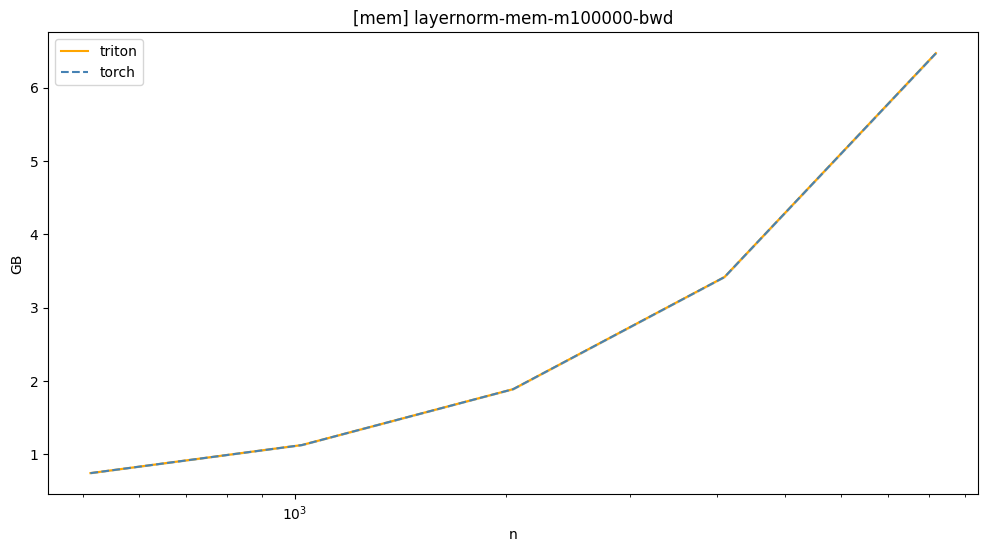

100%|██████████| 6/6 [00:33<00:00,  5.58s/it]

layernorm-mem-m100000-bwd:
        n    triton     torch
0   512.0  0.746225  0.745735
1  1024.0  1.128860  1.127882
2  2048.0  1.891139  1.890162
3  4096.0  3.420215  3.418261
4  8192.0  6.470798  6.467867



In [73]:
ms, ns = [10**i for i in range(3, 6)], [2**i for i in range(9, 14)]
layernorm_mem_configs = [Benchmark(
        x_names=['n'],  # Argument names to use as an x-axis for the plot.
        x_vals=ns, # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch',],  # Possible values for `line_arg`.
        line_names=['triton', 'torch',],  # Label name for the lines.
        styles=[('orange', '-'), ('steelblue', '--'),],  # Line styles.
        ylabel='GB',  # Label name for the y-axis.
        plot_name=f'layernorm-mem-m{m}-{wd}',  # Name for the plot. Used also as a file name for saving the plot.
        args={'m': m, 'wd': wd},  # Values for function arguments not in `x_names` and `y_name`.
    ) for m in ms for wd in ['fwd', 'bwd']]

@perf_report(layernorm_mem_configs)
def mem_benchmark(m, n, wd, provider, eps=1e-5,):
    x = -2.3 + 0.5 * torch.randn(m, n, dtype=torch.float16, device=device, requires_grad=False) # x ~ N(-2.3, 0.5)
    do = .1 * torch.randn_like(x); x.requires_grad_(True)
    weight = torch.rand(n, dtype=torch.float16, device=device, requires_grad=True)
    bias = torch.rand(n, dtype=torch.float16, device=device, requires_grad=True)
    quantiles = [0.5, 0.2, 0.8]
    
    if provider == 'torch': 
        fwd_func = lambda: F.layer_norm(x, (n,), weight, bias, eps)
    elif provider == 'triton':
        fwd_func = lambda: layernorm_triton(x, (n,), weight, bias, eps)
    
    if wd == 'fwd':
        perf_dict = do_bench_mem(fwd_func, quantiles=quantiles, rep=500) 
    elif wd == 'bwd':
        o = fwd_func()
        perf_dict = do_bench_mem(lambda: o.backward(do, retain_graph=True), grad_to_none=[x], quantiles=quantiles, rep=500) 
    
    ## post process the perf_dict
    gb = lambda m: m / 1024**3
    perf_dict['mem'] = list(map(gb, perf_dict['mem']))
    
    return perf_dict

mem_benchmark.run(print_data=True, show_plots=True, save_path=False)

#### step4-6. attention flops/mem test

  0%|          | 0/4 [00:00<?, ?it/s]

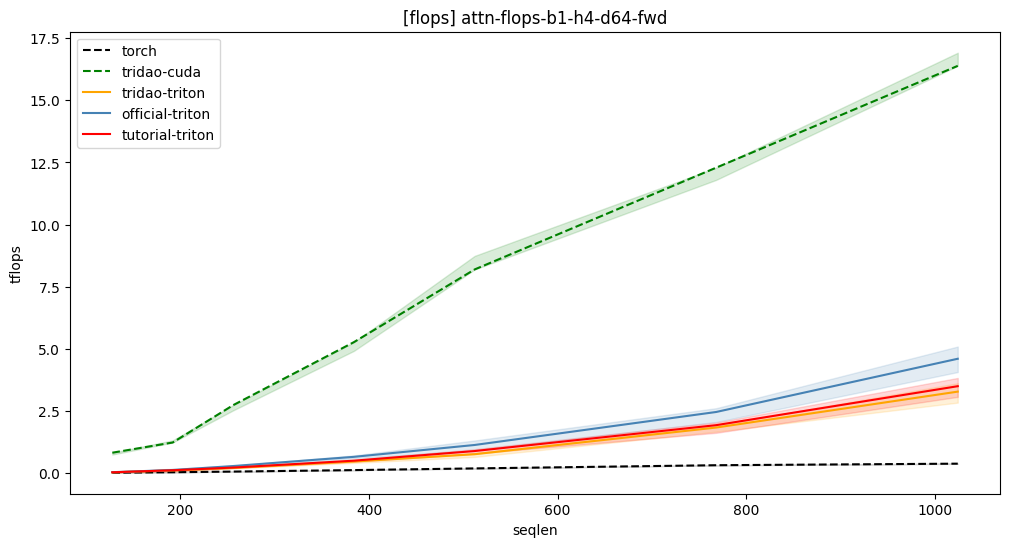

 25%|██▌       | 1/4 [00:05<00:17,  5.75s/it]

attn-flops-b1-h4-d64-fwd:
   seqlen     torch  tridao-cuda  tridao-triton  official-triton  \
0   128.0  0.015574     0.819200       0.029362         0.034860   
1   192.0  0.032973     1.228800       0.107163         0.123291   
2   256.0  0.059578     2.730667       0.204800         0.282483   
3   384.0  0.119301     5.266286       0.463698         0.652460   
4   512.0  0.187246     8.192000       0.757642         1.129931   
5   768.0  0.315752    12.288000       1.831752         2.457600   
6  1024.0  0.378001    16.384000       3.276800         4.599017   

   tutorial-triton  
0         0.031148  
1         0.112734  
2         0.221405  
3         0.498162  
4         0.885622  
5         1.927529  
6         3.495253  



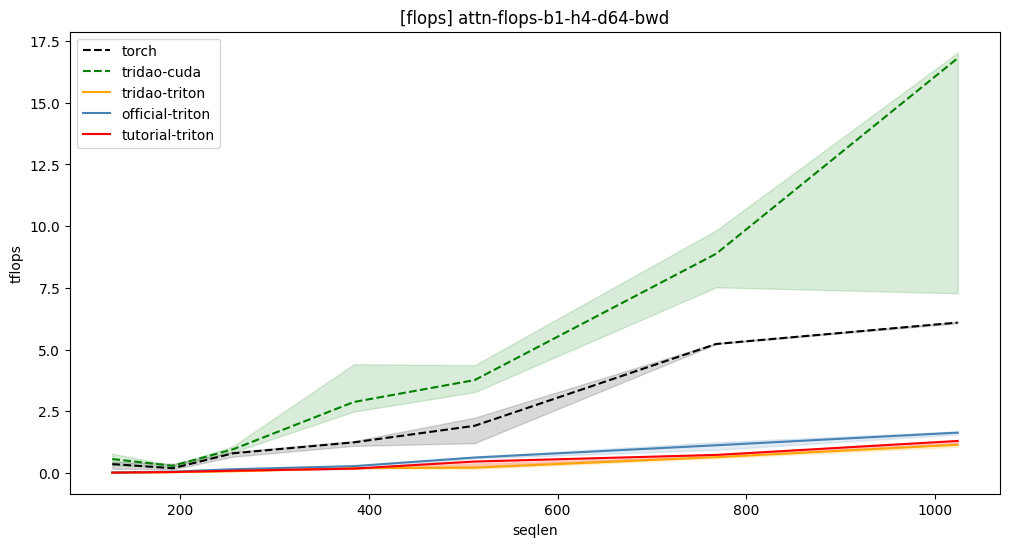

 50%|█████     | 2/4 [00:11<00:11,  5.59s/it]

attn-flops-b1-h4-d64-bwd:
   seqlen     torch  tridao-cuda  tridao-triton  official-triton  \
0   128.0  0.365714     0.568889       0.016637         0.025957   
1   192.0  0.196923     0.297290       0.040104         0.058851   
2   256.0  0.803137     0.963765       0.075782         0.158453   
3   384.0  1.245405     2.880000       0.202996         0.282483   
4   512.0  1.916257     3.766437       0.220141         0.631368   
5   768.0  5.228936     8.882892       0.646453         1.127339   
6  1024.0  6.096372    16.804103       1.148244         1.639425   

   tutorial-triton  
0         0.020128  
1         0.045444  
2         0.097062  
3         0.182315  
4         0.469456  
5         0.737280  
6         1.302903  



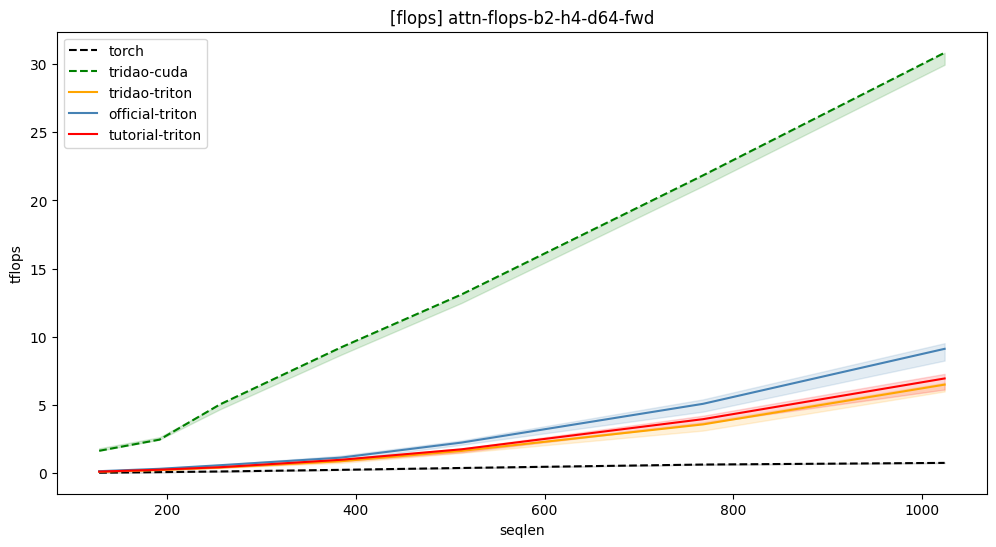

 75%|███████▌  | 3/4 [00:16<00:05,  5.51s/it]

attn-flops-b2-h4-d64-fwd:
   seqlen     torch  tridao-cuda  tridao-triton  official-triton  \
0   128.0  0.030454     1.638400       0.105026         0.141241   
1   192.0  0.072141     2.457600       0.228969         0.317793   
2   256.0  0.120915     5.041231       0.409600         0.579965   
3   384.0  0.240941     9.216000       0.872521         1.134277   
4   512.0  0.378274    13.107200       1.628224         2.240547   
5   768.0  0.629481    21.845333       3.574691         5.084690   
6  1024.0  0.750591    30.840470       6.492730         9.118052   

   tutorial-triton  
0         0.111456  
1         0.251631  
2         0.434013  
3         0.976530  
4         1.747627  
5         3.958550  
6         6.944212  



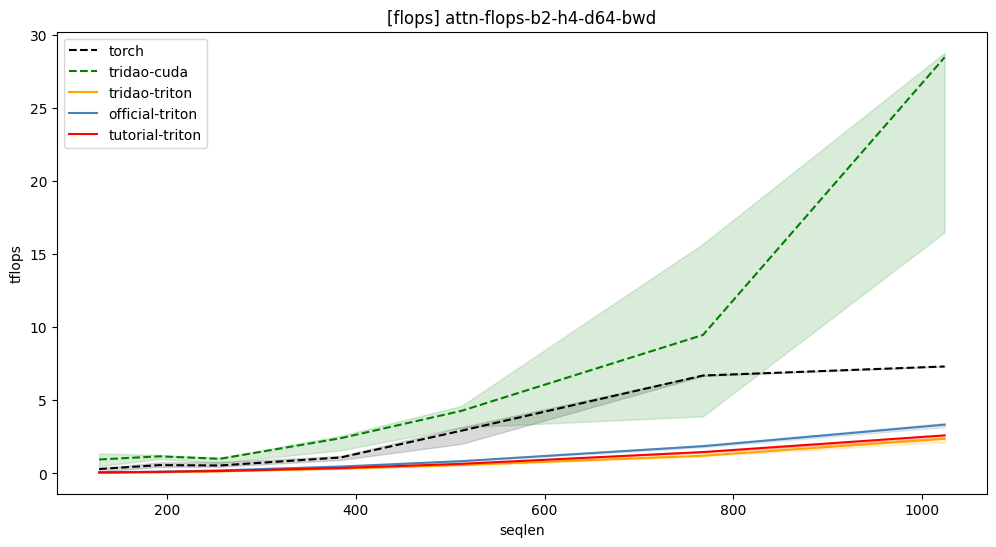

100%|██████████| 4/4 [00:22<00:00,  5.64s/it]

attn-flops-b2-h4-d64-bwd:
   seqlen     torch  tridao-cuda  tridao-triton  official-triton  \
0   128.0  0.301176     0.952558       0.049113         0.078093   
1   192.0  0.567138     1.166582       0.076800         0.112803   
2   256.0  0.542517     0.999024       0.147074         0.205829   
3   384.0  1.090651     2.409412       0.321675         0.468709   
4   512.0  2.925714     4.283399       0.574625         0.838056   
5   768.0  6.702545     9.482702       1.209151         1.864172   
6  1024.0  7.322458    28.493912       2.366989         3.335165   

   tutorial-triton  
0         0.060952  
1         0.106420  
2         0.162218  
3         0.367354  
4         0.654052  
5         1.461407  
6         2.600635  



In [40]:
bs, hs, ss, ds = [1, 2,], [4], [128, 192, 256, 384, 512, 768, 1024], [64]

attn_flops_configs = [Benchmark(
        x_names=['seqlen'],  # Argument names to use as an x-axis for the plot.
        x_vals=ss,  # Different possible values for `x_name`.
        x_log=False,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['torch', 'tridao-cuda', 'tridao-triton', 'official-triton', 'tutorial-triton'],  # Possible values for `line_arg`.
        line_names=['torch', 'tridao-cuda', 'tridao-triton', 'official-triton', 'tutorial-triton'],  # Label name for the lines.
        styles=[('black', '--'), ('green', '--'), ('orange', '-'), ('steelblue', '-'), ('red', '-')],  # Line styles.
        ylabel='tflops',  # Label name for the y-axis.
        plot_name=f'attn-flops-b{b}-h{h}-d{d}-{wd}',  # Name for the plot. Used also as a file name for saving the plot.
        args={'b': b, 'h': h, 'd': d, 'wd': wd},  # Values for function arguments not in `x_names` and `y_name`.
    ) for b in bs for h in hs for d in ds for wd in ['fwd', 'bwd']]

@perf_report(attn_flops_configs)
def flops_benchmark(b, h, d, seqlen, wd, provider):
    quantiles = [0.5, 0.2, 0.8]
    bias = None; causal = True; softmax_scale = None; dropout_p = 0.0; return_attn_probs=False; dtype = torch.float16

    # flash style shape: (b,s,h,d)
    sq = sk = seqlen
    q = torch.randn(b, sq, h, d, device=device, dtype=dtype, requires_grad=False)
    k = torch.randn(b, sk, h, d, device=device, dtype=dtype, requires_grad=False)
    v = torch.randn(b, sk, h, d, device=device, dtype=dtype, requires_grad=False)
    if wd == 'bwd': do = torch.randn_like(q)

    # sdpa style shape: (b,h,s,d)
    transpose_func = lambda x: x.transpose(1,2).contiguous()
    qt, kt, vt = map(transpose_func, [q,k,v])
    if wd == 'bwd': 
        dot = transpose_func(do)
        # require grads
        [x.requires_grad_(True) for x in [q, k, v, do, qt, kt, vt, dot]]
    
    # do the bench
    if provider == 'torch':
        fn = lambda: sdpa_torch_naive(qt, kt, vt, dropout_p=dropout_p, is_causal=causal, scale=softmax_scale, return_attn_probs=return_attn_probs)
        if wd == 'bwd': ot = fn(); fn = lambda: ot.backward(dot, retain_graph=True)
    elif provider == 'tridao-cuda':
        fn = lambda: flash_attn_tridao_cuda(q, k, v, dropout_p=dropout_p, softmax_scale=softmax_scale, causal=causal, return_attn_probs=return_attn_probs)
        if wd == 'bwd': o = fn(); fn = lambda: o.backward(do, retain_graph=True)    
    elif provider == 'tridao-triton':
        fn = lambda: flash_attn_tridao_triton(q, k, v, bias, causal, softmax_scale, return_attn_probs)
        if wd == 'bwd': o = fn(); fn = lambda: o.backward(do, retain_graph=True)    
    elif provider == 'official-triton':
        fn = lambda: flash_attn_official_triton(qt, kt, vt, causal, softmax_scale)
        if wd == 'bwd': ot = fn(); fn = lambda: ot.backward(dot, retain_graph=True)
    elif provider == 'tutorial-triton':
        fn = lambda: flash_attn_tutorial_triton(q, k, v, bias, causal, softmax_scale, return_attn_probs)
        if wd == 'bwd': o = fn(); fn = lambda: o.backward(do, retain_graph=True)    
    
    perf_dict = do_bench_flops(fn, quantiles=quantiles)
        
    ## post process the perf_dict
    flops_per_matmul = 2. * b * h * sq * sk * d
    total_flops = 2 * flops_per_matmul
    if causal: total_flops *= 0.5
    if wd == 'bwd': total_flops *= 2.5  # 2.0(bwd) + 0.5(recompute)
    gbps = lambda ms: total_flops / ms * 1e-9
    perf_dict['flops'] = list(map(gbps, perf_dict['flops']))
    
    return perf_dict

flops_benchmark.run(print_data=True, show_plots=True, save_path=False)


  0%|          | 0/4 [00:00<?, ?it/s]

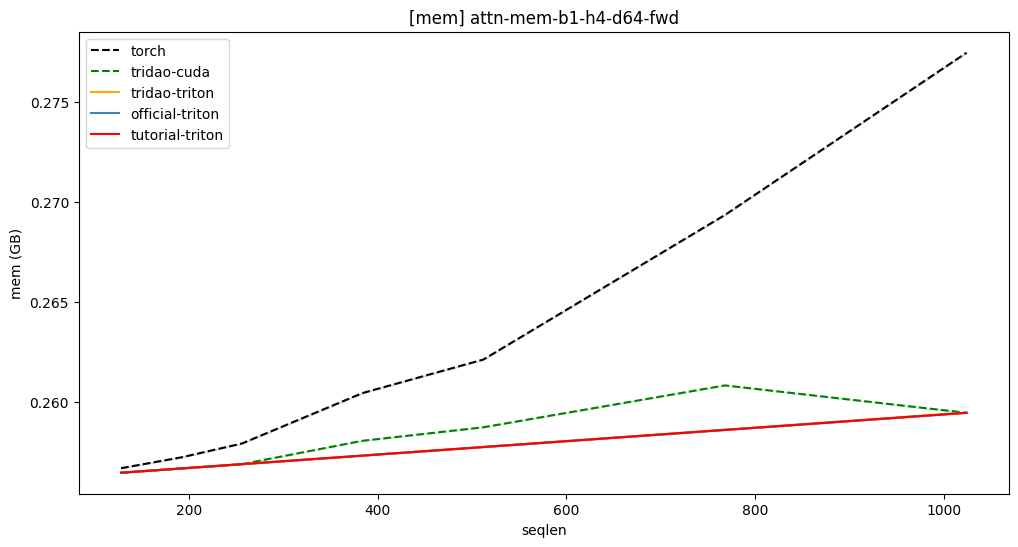

 25%|██▌       | 1/4 [00:06<00:18,  6.21s/it]

attn-mem-b1-h4-d64-fwd:
   seqlen     torch  tridao-cuda  tridao-triton  official-triton  \
0   128.0  0.256657     0.256431       0.256432         0.256430   
1   192.0  0.257203     0.256645       0.256649         0.256645   
2   256.0  0.257893     0.256860       0.256863         0.256859   
3   384.0  0.260426     0.258032       0.257294         0.257288   
4   512.0  0.262105     0.258709       0.257725         0.257718   
5   768.0  0.269352     0.260808       0.258587         0.258576   
6  1024.0  0.277485     0.259435       0.259449         0.259434   

   tutorial-triton  
0         0.256430  
1         0.256646  
2         0.256859  
3         0.257288  
4         0.257718  
5         0.258576  
6         0.259434  



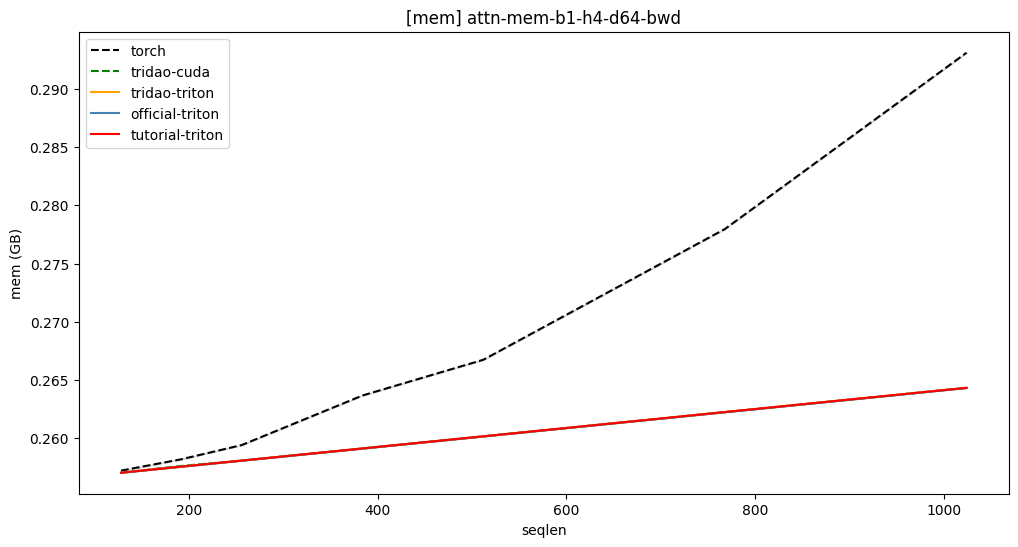

 50%|█████     | 2/4 [00:11<00:11,  5.85s/it]

attn-mem-b1-h4-d64-bwd:
   seqlen     torch  tridao-cuda  tridao-triton  official-triton  \
0   128.0  0.257222     0.257043       0.257042         0.257041   
1   192.0  0.258198     0.257626       0.257565         0.257560   
2   256.0  0.259419     0.258084       0.258084         0.258080   
3   384.0  0.263676     0.259126       0.259125         0.259120   
4   512.0  0.266743     0.260167       0.260167         0.260159   
5   768.0  0.277974     0.262250       0.262249         0.262238   
6  1024.0  0.293110     0.264333       0.264332         0.264317   

   tutorial-triton  
0         0.257042  
1         0.257565  
2         0.258084  
3         0.259125  
4         0.260167  
5         0.262249  
6         0.264332  



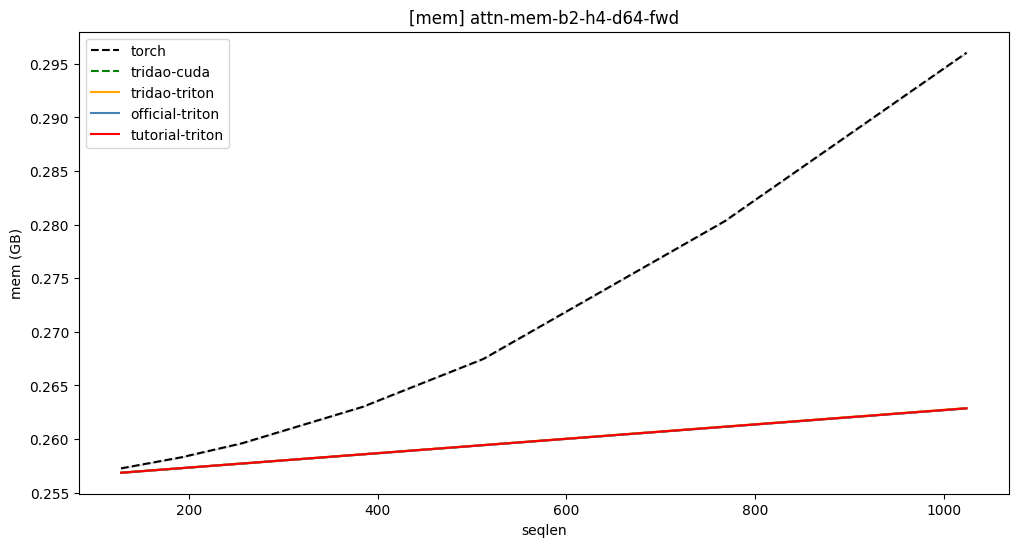

 75%|███████▌  | 3/4 [00:17<00:05,  5.66s/it]

attn-mem-b2-h4-d64-fwd:
   seqlen     torch  tridao-cuda  tridao-triton  official-triton  \
0   128.0  0.257267     0.256860       0.256863         0.256859   
1   192.0  0.258301     0.257289       0.257298         0.257288   
2   256.0  0.259602     0.257718       0.257725         0.257718   
3   384.0  0.263005     0.258576       0.258587         0.258576   
4   512.0  0.267476     0.259435       0.259449         0.259434   
5   768.0  0.280339     0.261151       0.261174         0.261151   
6  1024.0  0.296040     0.262868       0.262898         0.262867   

   tutorial-triton  
0         0.256859  
1         0.257290  
2         0.257718  
3         0.258576  
4         0.259434  
5         0.261151  
6         0.262867  



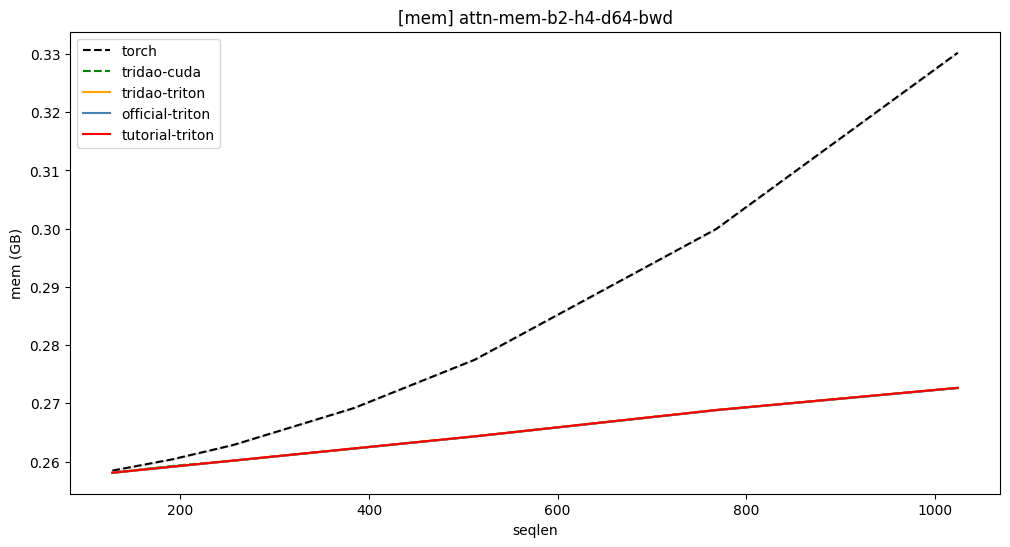

100%|██████████| 4/4 [00:22<00:00,  5.68s/it]

attn-mem-b2-h4-d64-bwd:
   seqlen     torch  tridao-cuda  tridao-triton  official-triton  \
0   128.0  0.258442     0.258084       0.258084         0.258080   
1   192.0  0.260396     0.259250       0.259129         0.259120   
2   256.0  0.262837     0.260167       0.260167         0.260159   
3   384.0  0.269185     0.262250       0.262249         0.262238   
4   512.0  0.277485     0.264333       0.264332         0.264317   
5   768.0  0.299946     0.268849       0.268849         0.268826   
6  1024.0  0.330220     0.272664       0.272664         0.272633   

   tutorial-triton  
0         0.258084  
1         0.259129  
2         0.260167  
3         0.262249  
4         0.264332  
5         0.268849  
6         0.272664  



In [41]:
bs, hs, ss, ds = [1, 2,], [4], [128, 192, 256, 384, 512, 768, 1024], [64]

attn_mem_configs = [Benchmark(
        x_names=['seqlen'],  # Argument names to use as an x-axis for the plot.
        x_vals=ss,  # Different possible values for `x_name`.
        x_log=False,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['torch', 'tridao-cuda', 'tridao-triton', 'official-triton', 'tutorial-triton'],  # Possible values for `line_arg`.
        line_names=['torch', 'tridao-cuda', 'tridao-triton', 'official-triton', 'tutorial-triton'],  # Label name for the lines.
        styles=[('black', '--'), ('green', '--'), ('orange', '-'), ('steelblue', '-'), ('red', '-')],  # Line styles.
        ylabel='mem (GB)',  # Label name for the y-axis.
        plot_name=f'attn-mem-b{b}-h{h}-d{d}-{wd}',  # Name for the plot. Used also as a file name for saving the plot.
        args={'b': b, 'h': h, 'd': d, 'wd': wd},  # Values for function arguments not in `x_names` and `y_name`.
    ) for b in bs for h in hs for d in ds for wd in ['fwd', 'bwd']]

@perf_report(attn_mem_configs)
def mem_benchmark(b, h, d, seqlen, wd, provider):
    quantiles = [0.5, 0.2, 0.8]
    bias = None; causal = True; softmax_scale = None; dropout_p = 0.0; return_attn_probs=False; dtype = torch.float16

    # flash style shape: (b,s,h,d)
    sq = sk = seqlen
    q = torch.randn(b, sq, h, d, device=device, dtype=dtype, requires_grad=False)
    k = torch.randn(b, sk, h, d, device=device, dtype=dtype, requires_grad=False)
    v = torch.randn(b, sk, h, d, device=device, dtype=dtype, requires_grad=False)
    if wd == 'bwd': do = torch.randn_like(q)

    # sdpa style shape: (b,h,s,d)
    transpose_func = lambda x: x.transpose(1,2).contiguous()
    qt, kt, vt = map(transpose_func, [q,k,v])
    if wd == 'bwd': 
        dot = transpose_func(do)
        # require grads
        [x.requires_grad_(True) for x in [q, k, v, do, qt, kt, vt, dot]]
    
    # do the bench
    if provider == 'torch':
        fn = lambda: sdpa_torch_naive(qt, kt, vt, dropout_p=dropout_p, is_causal=causal, scale=softmax_scale, return_attn_probs=return_attn_probs)
        if wd == 'bwd': ot = fn(); fn = lambda: ot.backward(dot, retain_graph=True)
    elif provider == 'tridao-cuda':
        fn = lambda: flash_attn_tridao_cuda(q, k, v, dropout_p=dropout_p, softmax_scale=softmax_scale, causal=causal, return_attn_probs=return_attn_probs)
        if wd == 'bwd': o = fn(); fn = lambda: o.backward(do, retain_graph=True)    
    elif provider == 'tridao-triton':
        fn = lambda: flash_attn_tridao_triton(q, k, v, bias, causal, softmax_scale, return_attn_probs)
        if wd == 'bwd': o = fn(); fn = lambda: o.backward(do, retain_graph=True)    
    elif provider == 'official-triton':
        fn = lambda: flash_attn_official_triton(qt, kt, vt, causal, softmax_scale)
        if wd == 'bwd': ot = fn(); fn = lambda: ot.backward(dot, retain_graph=True)
    elif provider == 'tutorial-triton':
        fn = lambda: flash_attn_tutorial_triton(q, k, v, bias, causal, softmax_scale, return_attn_probs)
        if wd == 'bwd': o = fn(); fn = lambda: o.backward(do, retain_graph=True)    
    
    perf_dict = do_bench_mem(fn, quantiles=quantiles)
        
    ## post process the perf_dict
    gb = lambda m: m / 1024**3
    perf_dict['mem'] = list(map(gb, perf_dict['mem']))
    
    return perf_dict

mem_benchmark.run(print_data=True, show_plots=True, save_path=False)
